# $U(1)$ Gauge Model using L2HMC in graph mode

--------------------------------------------------------------------
### TODO:
* [ ] Look at performance on Cooley (longer training runs).
* [ ] Fit observables to Eq. \ref{eq:therm_time} to determine the thermalization time $\tau$.

\begin{equation} 
f(t) \equiv A \exp^{-t / \tau}+ \,\, B
\label{eq:therm_time}
\end{equation}
* [ ] Look at defining a distance metric as the difference in topological charge between two samples and see what effect adding this as an additional term to the loss function has on the models' ability to tunnel between topological sectors.

--------------------------------------------------------------------

In [1]:
import os
import sys
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.special import i0, i1

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import utils.gauge_model_helpers as helpers
from utils.data_utils import (
    calc_avg_vals_errors, block_resampling, jackknife_err
)
from gauge_model import (
    GaugeModel, check_else_make_dir, save_params_to_pkl_file
)

tfe = tf.contrib.eager
%autoreload 2
%matplotlib notebook

#from gauge_model import GaugeModel
#%reload_ext gauge_model.GaugeModel
#from gauge_model import GaugeModel
#
#from dynamics.gauge_dynamics import GaugeDynamics
#%reload_ext dynamics.gauge_dynamics
#from dynamics.gauge_dynamics import GaugeDynamics

## Define parameters

In [5]:
tf.reset_default_graph()

In [ ]:
 %run ../gauge_model.py \
    --time_size 16 \
    --space_size 16 \
    --num_samples 5 \
    --num_steps 1 \
    --eps 0.2 \
    --annealing \
    --annealing_factor 0.9999 \
    --beta_init 3. \
    --beta_final 12. \
    --train_steps 20000 \
    --save_steps 1000 \
    --print_steps 1 \
    --learning_rate
    --training_samples_steps 1000 \
    --training_samples_length 100 \
    --conv_net \
    --metric 'l2' \
    --aux \
    --eps_trainable \

Creating directory for new run: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_96/
Creating directory: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_96/samples_history.
Creating directory: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_96/samples_history/training.
Creating directory: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_96/train_samples.
time_size: 16
space_size: 16
link_type: U1
dim: 2
num_samples: 5
rand: False
data_format: channels_last
num_steps: 1
eps: 0.2
loss_scale: 0.1
loss_eps: 0.0001
learning_rate_init: 0.0001
learning_rate_decay_steps: 100
learning_rate_decay_rate: 0.96
annealing: True
annealing_steps: 200
annealing_factor: 0.9999
beta_init: 3.0
beta_final: 12.0
train_steps: 20000
save_steps: 1000
logging_steps: 50
print_steps: 1
training_samples_steps: 1000
training_samples_length: 100
conv_net: True
hmc: False
eps_trainable: True
metric: l2
aux: True
clip_grads: False
clip_value: 100
beta: 3.0
---------------------------------------------------------------------

    65/20000    -9.749e+04      0.5884       0.002625       0.2002         3.02         0.0001    
    66/20000    -1.003e+05      0.6721       6.499e-05      0.2002         3.02         0.0001    
    67/20000    -8.513e+04      0.6584       0.0001253      0.2003         3.02         0.0001    
    68/20000    -1.009e+05      0.5848       0.0003429      0.2003         3.02         0.0001    
    69/20000    -9.275e+04      0.6634       0.0002016      0.2003         3.021        0.0001    
    70/20000    -1.014e+05      0.7438       0.0001455      0.2004         3.021        0.0001    
    71/20000    -8.814e+04      0.6528       2.356e-05      0.2005         3.021        0.0001    
    72/20000    -9.872e+04      0.5666       0.0002246      0.2005         3.022        0.0001    
    73/20000    -9.794e+04      0.7578       0.000125       0.2006         3.022        0.0001    
    74/20000    -9.802e+04      0.7356       0.000554       0.2007         3.022        0.0001    
    75/200

   148/20000    -1.033e+05      0.8876        0.00063       0.2019         3.045        9.6e-05   
   149/20000    -9.861e+04      0.6829       0.0005155      0.2019         3.045        9.6e-05   
   150/20000     -1.02e+05      0.5936       0.000587       0.2019         3.045        9.6e-05   
   151/20000    -1.014e+05      0.5495       1.931e-05      0.2019         3.046        9.6e-05   
   152/20000    -1.018e+05      0.6168       0.0007541      0.2019         3.046        9.6e-05   
   153/20000    -1.014e+05       0.634       0.0003866      0.2019         3.046        9.6e-05   
   154/20000    -1.013e+05      0.6111       0.0008011      0.2019         3.047        9.6e-05   
   155/20000    -1.041e+05       0.65        9.861e-05      0.2019         3.047        9.6e-05   
   156/20000    -1.031e+05      0.6038       0.000745       0.2019         3.047        9.6e-05   
   157/20000    -1.008e+05      0.5477       0.0007643      0.2019         3.047        9.6e-05   
   158/200

   231/20000    -1.066e+05      0.5851        0.2837        0.2005         3.07        9.216e-05  
   232/20000     -1.07e+05      0.5756        0.2535        0.2004         3.07        9.216e-05  
   233/20000    -1.052e+05      0.6269        0.3806        0.2004         3.071       9.216e-05  
   234/20000    -1.108e+05      0.5871        0.6455        0.2004         3.071       9.216e-05  
   235/20000    -1.054e+05       0.673        0.3633        0.2004         3.071       9.216e-05  
   236/20000    -1.068e+05      0.9136        0.4558        0.2004         3.072       9.216e-05  
   237/20000    -1.044e+05      0.8845        0.2284        0.2004         3.072       9.216e-05  
   238/20000    -1.051e+05      0.8783        0.3275        0.2003         3.072       9.216e-05  
   239/20000    -1.059e+05      0.5215        0.3232        0.2003         3.073       9.216e-05  
   240/20000    -1.019e+05      0.5264        0.2901        0.2003         3.073       9.216e-05  
   241/200

   314/20000    -1.051e+05      0.4969        0.3123        0.1981         3.096       8.847e-05  
   315/20000    -1.057e+05       0.601        0.4345        0.1981         3.096       8.847e-05  
   316/20000    -1.046e+05      0.6155        0.6063        0.1981         3.096       8.847e-05  
   317/20000    -1.098e+05      0.6346        0.6179        0.1981         3.097       8.847e-05  
   318/20000    -1.044e+05      0.5315        0.08423        0.198         3.097       8.847e-05  
   319/20000    -1.064e+05      0.5141        0.4385         0.198         3.097       8.847e-05  
   320/20000    -1.052e+05      0.5496        0.2911         0.198         3.098       8.847e-05  
   321/20000    -1.079e+05      0.5216        0.5504         0.198         3.098       8.847e-05  
   322/20000    -1.048e+05      0.5337        0.4374         0.198         3.098       8.847e-05  
   323/20000    -1.064e+05       0.546        0.6324        0.1979         3.098       8.847e-05  
   324/200

   397/20000    -1.052e+05      0.5998        0.5505        0.1957         3.122       8.847e-05  
   398/20000     -1.03e+05      0.5202        0.6325        0.1957         3.122       8.847e-05  
   399/20000    -1.002e+05      0.5739        0.2589        0.1956         3.122       8.847e-05  
   400/20000    -1.037e+05      0.5745        0.3814        0.1956         3.122       8.493e-05  
   401/20000    -1.055e+05      0.6093        0.6736        0.1956         3.123       8.493e-05  
   402/20000    -1.073e+05      0.5611        0.7916        0.1955         3.123       8.493e-05  
   403/20000    -1.045e+05      0.6661        0.6576        0.1955         3.123       8.493e-05  
   404/20000    -1.047e+05      0.5796        0.6233        0.1955         3.124       8.493e-05  
   405/20000    -1.052e+05      0.6126        0.7449        0.1954         3.124       8.493e-05  
   406/20000    -1.009e+05       1.139        0.3636        0.1954         3.124       8.493e-05  
   407/200

   480/20000    -1.006e+05      0.6173        0.4018        0.1933         3.148       8.493e-05  
   481/20000    -1.046e+05      0.5616        0.5908        0.1933         3.148       8.493e-05  
   482/20000    -1.042e+05      0.5587        0.4952        0.1933         3.148       8.493e-05  
   483/20000    -1.051e+05      0.5017        0.5745        0.1932         3.148       8.493e-05  
   484/20000    -1.039e+05      0.5818        0.1702        0.1932         3.149       8.493e-05  
   485/20000    -1.047e+05      0.6018        0.4878        0.1932         3.149       8.493e-05  
   486/20000    -1.047e+05      0.5498        0.5774        0.1932         3.149       8.493e-05  
   487/20000    -1.061e+05      0.4704         0.582        0.1931         3.15        8.493e-05  
   488/20000     -1.05e+05      0.5392        0.2334        0.1931         3.15        8.493e-05  
   489/20000    -1.078e+05      0.6429         0.444        0.1931         3.15        8.493e-05  
   490/200

   563/20000    -1.054e+05      0.5273        0.5793        0.1914         3.174       8.154e-05  
   564/20000    -1.015e+05      0.5011        0.3809        0.1914         3.174       8.154e-05  
   565/20000     -1.04e+05      0.6026        0.4883        0.1914         3.174       8.154e-05  
   566/20000    -1.021e+05      0.5978         0.316        0.1913         3.175       8.154e-05  
   567/20000    -1.037e+05      0.5285        0.3401        0.1913         3.175       8.154e-05  
   568/20000    -1.055e+05      0.5243        0.5627        0.1913         3.175       8.154e-05  
   569/20000    -1.078e+05      0.5186        0.7048        0.1913         3.176       8.154e-05  
   570/20000    -1.044e+05      0.5486         0.623        0.1912         3.176       8.154e-05  
   571/20000    -1.039e+05      0.5481        0.2173        0.1912         3.176       8.154e-05  
   572/20000    -1.053e+05      0.5507        0.6058        0.1912         3.177       8.154e-05  
   573/200

   646/20000    -1.042e+05      0.5223        0.5343        0.1896          3.2        7.828e-05  
   647/20000    -1.064e+05      0.5401        0.7251        0.1896         3.201       7.828e-05  
   648/20000    -1.062e+05      0.4999        0.8572        0.1896         3.201       7.828e-05  
   649/20000    -1.042e+05      0.5506        0.4883        0.1895         3.201       7.828e-05  
   650/20000    -1.054e+05      0.5406        0.5756        0.1895         3.201       7.828e-05  
   651/20000    -1.034e+05       0.581        0.6137        0.1895         3.202       7.828e-05  
   652/20000    -9.593e+04      0.5194        0.3134        0.1895         3.202       7.828e-05  
   653/20000    -1.019e+05      0.5598        0.4221        0.1894         3.202       7.828e-05  
   654/20000    -1.011e+05      0.5353        0.6155        0.1894         3.203       7.828e-05  
   655/20000    -1.067e+05      0.4497        0.5428        0.1894         3.203       7.828e-05  
   656/200

   729/20000     -1.04e+05      0.6028         0.538        0.1878         3.227       7.514e-05  
   730/20000    -1.043e+05      0.5703        0.8137        0.1878         3.227       7.514e-05  
   731/20000    -1.003e+05      0.5056        0.5185        0.1878         3.228       7.514e-05  
   732/20000    -1.059e+05      0.4918         0.608        0.1877         3.228       7.514e-05  
   733/20000     -1.02e+05      0.4818         0.544        0.1877         3.228       7.514e-05  
   734/20000     -9.95e+04      0.4636        0.3428        0.1877         3.228       7.514e-05  
   735/20000    -1.019e+05      0.5169        0.6846        0.1877         3.229       7.514e-05  
   736/20000    -1.033e+05      0.5098        0.7002        0.1877         3.229       7.514e-05  
   737/20000    -1.053e+05      0.5126         0.52         0.1876         3.229       7.514e-05  
   738/20000    -1.003e+05       0.51         0.3725        0.1876         3.23        7.514e-05  
   739/200

   812/20000    -1.015e+05      0.5677        0.5683        0.1861         3.254       7.214e-05  
   813/20000    -1.029e+05      0.5045        0.4732        0.1861         3.254       7.214e-05  
   814/20000    -1.012e+05      0.6206        0.6841        0.1861         3.254       7.214e-05  
   815/20000    -1.003e+05      0.5834        0.5168         0.186         3.255       7.214e-05  
   816/20000    -1.012e+05      0.6752        0.6447         0.186         3.255       7.214e-05  
   817/20000    -1.025e+05      0.6428        0.6224         0.186         3.255       7.214e-05  
   818/20000    -1.017e+05      0.5652        0.3396         0.186         3.256       7.214e-05  
   819/20000    -1.061e+05       1.072        0.6175        0.1859         3.256       7.214e-05  
   820/20000    -1.076e+05      0.9686        0.6596        0.1859         3.256       7.214e-05  
   821/20000     -1.02e+05      0.8738        0.4672        0.1859         3.257       7.214e-05  
   822/200

   895/20000    -1.055e+05      0.5111        0.4875        0.1846         3.281       7.214e-05  
   896/20000     -1.03e+05      0.4697        0.6042        0.1846         3.281       7.214e-05  
   897/20000    -9.968e+04      0.5546        0.4536        0.1845         3.282       7.214e-05  
   898/20000    -9.399e+04      0.5467        0.3788        0.1845         3.282       7.214e-05  
   899/20000    -1.021e+05      0.5674        0.2202        0.1845         3.282       7.214e-05  
   900/20000    -1.061e+05      0.5559        0.6365        0.1845         3.283       6.925e-05  
   901/20000    -1.045e+05      0.5248        0.4496        0.1845         3.283       6.925e-05  
   902/20000    -1.013e+05      0.5223        0.4566        0.1845         3.283       6.925e-05  
   903/20000    -1.034e+05       0.517        0.5022        0.1844         3.284       6.925e-05  
   904/20000    -9.928e+04      0.5139        0.4078        0.1844         3.284       6.925e-05  
   905/200

   978/20000    -1.032e+05      0.5328        0.5001         0.183         3.308       6.925e-05  
   979/20000    -1.037e+05      0.5223        0.1883         0.183         3.309       6.925e-05  
   980/20000    -1.038e+05      0.6152        0.2846         0.183         3.309       6.925e-05  
   981/20000    -1.043e+05      0.5565        0.4896         0.183         3.309       6.925e-05  
   982/20000    -1.038e+05      0.5651        0.3818         0.183         3.31        6.925e-05  
   983/20000    -1.015e+05      0.6214        0.6171         0.183         3.31        6.925e-05  
   984/20000    -1.035e+05      0.5962        0.6515         0.183         3.31        6.925e-05  
   985/20000     -1.05e+05      0.5504        0.8128         0.183         3.311       6.925e-05  
   986/20000    -1.035e+05      0.5155        0.6438         0.183         3.311       6.925e-05  
   987/20000    -1.022e+05      0.5634        0.5512         0.183         3.311       6.925e-05  
   988/200

  1033/20000    -1.072e+05      0.8216        0.4388        0.1821         3.326       6.648e-05  
  1034/20000    -1.048e+05      0.9899        0.6548        0.1821         3.327       6.648e-05  
  1035/20000    -1.047e+05      0.7417        0.5704        0.1821         3.327       6.648e-05  
  1036/20000    -9.993e+04      0.8211        0.5226        0.1821         3.327       6.648e-05  
  1037/20000    -1.019e+05      0.9512        0.3744         0.182         3.328       6.648e-05  
  1038/20000    -9.871e+04      0.8268        0.3735         0.182         3.328       6.648e-05  
  1039/20000    -1.003e+05      0.7025        0.3817         0.182         3.328       6.648e-05  
  1040/20000    -1.055e+05      0.6381          0.4          0.182         3.329       6.648e-05  
  1041/20000    -1.011e+05      0.6664        0.4171         0.182         3.329       6.648e-05  
  1042/20000    -1.025e+05      0.6534        0.3788        0.1819         3.329       6.648e-05  
  1043/200

  1116/20000    -1.015e+05      0.5173        0.4682        0.1805         3.354       6.382e-05  
  1117/20000     -1.03e+05      0.5459        0.7462        0.1805         3.355       6.382e-05  
  1118/20000    -1.004e+05      0.5043        0.6166        0.1805         3.355       6.382e-05  
  1119/20000    -1.071e+05      0.6471        0.8826        0.1805         3.355       6.382e-05  
  1120/20000    -1.041e+05      0.7379        0.4845        0.1805         3.356       6.382e-05  
  1121/20000    -1.007e+05      0.5903         0.663        0.1804         3.356       6.382e-05  
  1122/20000    -1.033e+05      0.5232        0.3993        0.1804         3.356       6.382e-05  
  1123/20000    -1.033e+05      0.6013        0.5017        0.1804         3.357       6.382e-05  
  1124/20000     -1.04e+05      0.5448        0.6171        0.1804         3.357       6.382e-05  
  1125/20000    -1.048e+05      0.6133        0.4335        0.1803         3.357       6.382e-05  
  1126/200

  1199/20000    -1.062e+05       1.072        0.6955        0.1788         3.382       6.382e-05  
  1200/20000    -1.066e+05       1.218        0.7792        0.1788         3.383       6.127e-05  
  1201/20000    -1.044e+05       1.139        0.8946        0.1788         3.383       6.127e-05  
  1202/20000    -1.027e+05       0.81         0.5523        0.1788         3.383       6.127e-05  
  1203/20000    -9.947e+04       1.038        0.5454        0.1788         3.384       6.127e-05  
  1204/20000    -1.058e+05       1.08         0.6334        0.1788         3.384       6.127e-05  
  1205/20000    -1.014e+05       1.015        0.4845        0.1787         3.384       6.127e-05  
  1206/20000    -1.017e+05      0.8332        0.6005        0.1787         3.385       6.127e-05  
  1207/20000    -1.028e+05      0.8694        0.5759        0.1787         3.385       6.127e-05  
  1208/20000    -1.021e+05       1.18         0.5489        0.1787         3.385       6.127e-05  
  1209/200

  1282/20000    -1.035e+05       0.596         0.475        0.1776         3.41        6.127e-05  
  1283/20000    -1.052e+05      0.6352        0.5856        0.1776         3.411       6.127e-05  
  1284/20000    -1.045e+05      0.5634        0.9367        0.1776         3.411       6.127e-05  
  1285/20000    -1.047e+05      0.5978        0.8387        0.1775         3.411       6.127e-05  
  1286/20000    -1.035e+05       1.07         0.5208        0.1775         3.412       6.127e-05  
  1287/20000    -1.048e+05       0.67         0.5451        0.1775         3.412       6.127e-05  
  1288/20000    -1.049e+05      0.6448        0.7237        0.1775         3.412       6.127e-05  
  1289/20000    -1.036e+05      0.6998        0.8624        0.1775         3.413       6.127e-05  
  1290/20000    -1.026e+05       0.577         0.532        0.1775         3.413       6.127e-05  
  1291/20000    -1.032e+05      0.5233        0.6777        0.1775         3.413       6.127e-05  
  1292/200

  1365/20000    -1.056e+05      0.9764        0.7886         0.176         3.439       5.882e-05  
  1366/20000    -1.032e+05       1.008        0.5449         0.176         3.439       5.882e-05  
  1367/20000    -1.074e+05      0.9536        0.6587        0.1759         3.439       5.882e-05  
  1368/20000    -1.056e+05      0.9409        0.8034        0.1759         3.44        5.882e-05  
  1369/20000    -1.061e+05      0.9566        0.5422        0.1759         3.44        5.882e-05  
  1370/20000      -1e+05         1.097        0.6194        0.1759         3.441       5.882e-05  
  1371/20000    -1.019e+05       1.229        0.5384        0.1759         3.441       5.882e-05  
  1372/20000    -1.037e+05       1.048        0.4094        0.1759         3.441       5.882e-05  
  1373/20000    -1.024e+05       1.049        0.5982        0.1758         3.442       5.882e-05  
  1374/20000    -1.088e+05       1.026        0.9107        0.1758         3.442       5.882e-05  
  1375/200

  1448/20000    -1.036e+05      0.4646        0.3724        0.1746         3.467       5.647e-05  
  1449/20000    -1.046e+05      0.6047           1          0.1746         3.468       5.647e-05  
  1450/20000    -1.012e+05      0.5207        0.3198        0.1746         3.468       5.647e-05  
  1451/20000    -1.028e+05      0.5347        0.5378        0.1746         3.468       5.647e-05  
  1452/20000    -1.013e+05      0.4949        0.6019        0.1745         3.469       5.647e-05  
  1453/20000    -9.905e+04      0.5316        0.3927        0.1745         3.469       5.647e-05  
  1454/20000    -1.039e+05      0.6387        0.6238        0.1745         3.47        5.647e-05  
  1455/20000    -9.792e+04      0.6521        0.4335        0.1745         3.47        5.647e-05  
  1456/20000    -1.033e+05      0.5805        0.7804        0.1745         3.47        5.647e-05  
  1457/20000    -1.063e+05      0.5982        0.5218        0.1745         3.471       5.647e-05  
  1458/200

  1531/20000    -1.033e+05      0.5713        0.4636         0.173         3.496       5.421e-05  
  1532/20000    -1.016e+05      0.5468        0.5268        0.1729         3.497       5.421e-05  
  1533/20000    -9.956e+04      0.5677        0.2948        0.1729         3.497       5.421e-05  
  1534/20000    -1.045e+05      0.5616        0.4836        0.1729         3.497       5.421e-05  
  1535/20000    -1.031e+05      0.5614        0.5241        0.1729         3.498       5.421e-05  
  1536/20000     -1.1e+05       0.5737        0.9082        0.1728         3.498       5.421e-05  
  1537/20000    -1.052e+05       0.525        0.4545        0.1728         3.498       5.421e-05  
  1538/20000    -1.014e+05      0.5513        0.5519        0.1728         3.499       5.421e-05  
  1539/20000     -1.04e+05      0.5265        0.4799        0.1728         3.499       5.421e-05  
  1540/20000    -1.028e+05      0.5576        0.4506        0.1728         3.499       5.421e-05  
  1541/200

  1614/20000    -1.041e+05      0.5754        0.6288        0.1711         3.525       5.204e-05  
  1615/20000    -9.868e+04      0.5574        0.3634        0.1711         3.526       5.204e-05  
  1616/20000    -1.018e+05       0.53         0.5577        0.1711         3.526       5.204e-05  
  1617/20000    -1.031e+05      0.6765        0.6807         0.171         3.527       5.204e-05  
  1618/20000    -1.072e+05       0.668        0.7302         0.171         3.527       5.204e-05  
  1619/20000    -1.078e+05      0.6532        0.4784         0.171         3.527       5.204e-05  
  1620/20000    -1.005e+05      0.7297        0.5476         0.171         3.528       5.204e-05  
  1621/20000    -1.024e+05      0.9049        0.5629         0.171         3.528       5.204e-05  
  1622/20000    -1.067e+05      0.6306        0.4138        0.1709         3.528       5.204e-05  
  1623/20000    -1.017e+05      0.7724        0.5239        0.1709         3.529       5.204e-05  
  1624/200

  1697/20000    -1.023e+05      0.5351        0.3849        0.1698         3.555       5.204e-05  
  1698/20000    -1.037e+05      0.5231        0.7096        0.1697         3.555       5.204e-05  
  1699/20000    -1.068e+05       0.468        0.6234        0.1697         3.556       5.204e-05  
  1700/20000    -1.046e+05       0.619        0.7036        0.1697         3.556       4.996e-05  
  1701/20000     -1.03e+05      0.5004        0.6921        0.1697         3.556       4.996e-05  
  1702/20000    -1.054e+05      0.5106        0.4118        0.1697         3.557       4.996e-05  
  1703/20000    -9.901e+04      0.5326        0.6825        0.1696         3.557       4.996e-05  
  1704/20000    -1.041e+05       0.536        0.5415        0.1696         3.557       4.996e-05  
  1705/20000    -1.029e+05      0.5185        0.5171        0.1696         3.558       4.996e-05  
  1706/20000    -1.041e+05      0.5324        0.7088        0.1696         3.558       4.996e-05  
  1707/200

  1780/20000    -1.043e+05      0.7015        0.4496        0.1681         3.585       4.996e-05  
  1781/20000    -1.056e+05      0.5753        0.6663        0.1681         3.585       4.996e-05  
  1782/20000    -1.037e+05      0.6666        0.4822         0.168         3.585       4.996e-05  
  1783/20000    -1.041e+05      0.5957        0.6853         0.168         3.586       4.996e-05  
  1784/20000    -1.034e+05      0.5334        0.5762         0.168         3.586       4.996e-05  
  1785/20000    -1.027e+05      0.6016        0.5821         0.168         3.586       4.996e-05  
  1786/20000    -1.022e+05      0.6259         0.696         0.168         3.587       4.996e-05  
  1787/20000    -1.036e+05      0.6048        0.5622        0.1679         3.587       4.996e-05  
  1788/20000    -1.039e+05      0.5422         0.367        0.1679         3.587       4.996e-05  
  1789/20000    -1.046e+05      0.5262        0.5484        0.1679         3.588       4.996e-05  
  1790/200

  1863/20000    -1.018e+05      0.5088        0.6147        0.1665         3.614       4.796e-05  
  1864/20000    -1.047e+05      0.5673        0.5561        0.1665         3.615       4.796e-05  
  1865/20000    -1.053e+05      0.5537        0.7505        0.1665         3.615       4.796e-05  
  1866/20000    -1.041e+05      0.5474        0.7884        0.1665         3.615       4.796e-05  
  1867/20000    -9.852e+04      0.5266        0.6854        0.1665         3.616       4.796e-05  
  1868/20000    -1.048e+05      0.5069        0.7434        0.1665         3.616       4.796e-05  
  1869/20000     -1.04e+05      0.5726        0.4604        0.1664         3.617       4.796e-05  
  1870/20000    -1.026e+05      0.5301        0.3869        0.1664         3.617       4.796e-05  
  1871/20000    -1.037e+05      0.6178         0.484        0.1664         3.617       4.796e-05  
  1872/20000    -1.011e+05      0.5452        0.6538        0.1664         3.618       4.796e-05  
  1873/200

  1946/20000     -1.03e+05      0.5969        0.3938        0.1652         3.645       4.604e-05  
  1947/20000    -1.046e+05       0.632        0.8687        0.1652         3.645       4.604e-05  
  1948/20000    -1.027e+05      0.6055        0.4558        0.1652         3.645       4.604e-05  
  1949/20000    -1.036e+05      0.5593        0.3915        0.1652         3.646       4.604e-05  
  1950/20000    -1.007e+05      0.5411        0.7148        0.1652         3.646       4.604e-05  
  1951/20000    -1.037e+05      0.5166        0.8503        0.1652         3.646       4.604e-05  
  1952/20000    -1.026e+05      0.5783        0.5845        0.1651         3.647       4.604e-05  
  1953/20000    -1.036e+05      0.5549        0.7502        0.1651         3.647       4.604e-05  
  1954/20000    -1.061e+05       0.524        0.7097        0.1651         3.647       4.604e-05  
  1955/20000    -1.022e+05      0.5577        0.7187        0.1651         3.648       4.604e-05  
  1956/200

  2001/20000    -1.053e+05      0.5142        0.4621        0.1641         3.665       4.42e-05   
  2002/20000    -1.037e+05      0.4916        0.7103        0.1641         3.665       4.42e-05   
  2003/20000     -1.01e+05      0.5357         0.754        0.1641         3.665       4.42e-05   
  2004/20000     -1.05e+05      0.5793        0.3031        0.1641         3.666       4.42e-05   
  2005/20000    -1.044e+05      0.6642        0.3948         0.164         3.666       4.42e-05   
  2006/20000    -1.044e+05      0.6573         0.735         0.164         3.666       4.42e-05   
  2007/20000    -1.025e+05       0.575        0.7993         0.164         3.667       4.42e-05   
  2008/20000    -1.036e+05      0.6158        0.6078         0.164         3.667       4.42e-05   
  2009/20000    -1.071e+05      0.5252        0.6977         0.164         3.668       4.42e-05   
  2010/20000    -9.974e+04      0.6658        0.5939        0.1639         3.668       4.42e-05   
  2011/200

  2084/20000    -1.034e+05       0.516        0.6248        0.1625         3.695       4.42e-05   
  2085/20000    -1.037e+05      0.5303        0.7994        0.1625         3.696       4.42e-05   
  2086/20000     -1.03e+05      0.5765        0.6663        0.1624         3.696       4.42e-05   
  2087/20000    -1.019e+05      0.8043        0.4539        0.1624         3.696       4.42e-05   
  2088/20000    -1.056e+05      0.6516        0.4766        0.1624         3.697       4.42e-05   
  2089/20000    -1.049e+05      0.5699        0.5016        0.1624         3.697       4.42e-05   
  2090/20000    -1.049e+05      0.5825         0.749        0.1624         3.697       4.42e-05   
  2091/20000    -1.004e+05      0.6957        0.4465        0.1623         3.698       4.42e-05   
  2092/20000    -1.003e+05      0.5422        0.5486        0.1623         3.698       4.42e-05   
  2093/20000    -1.005e+05       0.559        0.6695        0.1623         3.698       4.42e-05   
  2094/200

  2167/20000    -1.043e+05      0.5401        0.5642        0.1609         3.726       4.243e-05  
  2168/20000    -1.044e+05      0.5732        0.7975        0.1609         3.726       4.243e-05  
  2169/20000    -1.052e+05       0.566        0.5578        0.1608         3.727       4.243e-05  
  2170/20000    -1.025e+05      0.5596        0.6709        0.1608         3.727       4.243e-05  
  2171/20000    -1.048e+05      0.5376        0.8729        0.1608         3.727       4.243e-05  
  2172/20000     -1.01e+05       0.585        0.4785        0.1608         3.728       4.243e-05  
  2173/20000    -1.038e+05      0.5246        0.7478        0.1608         3.728       4.243e-05  
  2174/20000    -1.042e+05      0.5972        0.4449        0.1608         3.729       4.243e-05  
  2175/20000    -1.015e+05      0.5422        0.7182        0.1607         3.729       4.243e-05  
  2176/20000    -1.048e+05      0.5753        0.4716        0.1607         3.729       4.243e-05  
  2177/200

  2250/20000    -1.019e+05      0.6063        0.5109        0.1594         3.757       4.073e-05  
  2251/20000    -1.004e+05      0.4908        0.5646        0.1594         3.757       4.073e-05  
  2252/20000     -1.03e+05      0.5349        0.6951        0.1594         3.758       4.073e-05  
  2253/20000    -1.024e+05      0.5755        0.5637        0.1594         3.758       4.073e-05  
  2254/20000    -1.006e+05      0.6163        0.4179        0.1594         3.759       4.073e-05  
  2255/20000     -1.02e+05      0.5776        0.5983        0.1594         3.759       4.073e-05  
  2256/20000    -1.019e+05      0.5846        0.6147        0.1593         3.759       4.073e-05  
  2257/20000    -1.023e+05      0.7096        0.8681        0.1593         3.76        4.073e-05  
  2258/20000    -1.035e+05      0.6295        0.7816        0.1593         3.76        4.073e-05  
  2259/20000    -1.044e+05      0.5312        0.8039        0.1593         3.76        4.073e-05  
  2260/200

  2333/20000    -1.048e+05       1.286        0.8933        0.1581         3.788       3.911e-05  
  2334/20000    -1.034e+05       1.032        0.6932        0.1581         3.789       3.911e-05  
  2335/20000    -1.015e+05       1.118        0.8107         0.158         3.789       3.911e-05  
  2336/20000    -1.045e+05       1.089        0.7252         0.158         3.789       3.911e-05  
  2337/20000    -1.068e+05       0.845        0.7452         0.158         3.79        3.911e-05  
  2338/20000    -1.023e+05      0.8067        0.6343         0.158         3.79        3.911e-05  
  2339/20000    -9.933e+04       1.038        0.4665         0.158         3.791       3.911e-05  
  2340/20000     -1.02e+05       1.034        0.5933         0.158         3.791       3.911e-05  
  2341/20000    -1.027e+05      0.8321        0.4595         0.158         3.791       3.911e-05  
  2342/20000    -1.028e+05      0.9485        0.4256        0.1579         3.792       3.911e-05  
  2343/200

  2416/20000    -1.037e+05      0.7348        0.5476        0.1566         3.82        3.754e-05  
  2417/20000    -1.033e+05      0.7056         0.468        0.1566         3.82        3.754e-05  
  2418/20000    -1.038e+05      0.5654        0.5443        0.1566         3.821       3.754e-05  
  2419/20000    -1.031e+05      0.5752        0.2573        0.1566         3.821       3.754e-05  
  2420/20000    -1.025e+05      0.5845         0.668        0.1566         3.821       3.754e-05  
  2421/20000    -1.025e+05      0.6163        0.8172        0.1565         3.822       3.754e-05  
  2422/20000    -1.017e+05      0.5986        0.6361        0.1565         3.822       3.754e-05  
  2423/20000    -1.018e+05      0.6201         0.529        0.1565         3.823       3.754e-05  
  2424/20000    -1.041e+05      0.6173        0.6879        0.1565         3.823       3.754e-05  
  2425/20000    -1.035e+05      0.5844        0.5097        0.1565         3.823       3.754e-05  
  2426/200

  2499/20000     -1.06e+05      0.5123        0.6167        0.1552         3.852       3.754e-05  
  2500/20000    -1.045e+05       0.536        0.7283        0.1552         3.852       3.604e-05  
  2501/20000    -1.045e+05      0.5575        0.6442        0.1552         3.853       3.604e-05  
  2502/20000    -1.052e+05      0.5681        0.7802        0.1552         3.853       3.604e-05  
  2503/20000    -1.022e+05      0.5978        0.7125        0.1552         3.853       3.604e-05  
  2504/20000    -9.967e+04      0.5508        0.4331        0.1552         3.854       3.604e-05  
  2505/20000    -1.059e+05      0.5457        0.7309        0.1552         3.854       3.604e-05  
  2506/20000    -1.012e+05      0.5397        0.7182        0.1552         3.854       3.604e-05  
  2507/20000    -1.028e+05      0.5664        0.5673        0.1551         3.855       3.604e-05  
  2508/20000    -1.018e+05      0.5602        0.4985        0.1551         3.855       3.604e-05  
  2509/200

  2582/20000    -1.034e+05      0.6818        0.4956        0.1542         3.884       3.604e-05  
  2583/20000     -1.05e+05      0.6014        0.6387        0.1542         3.884       3.604e-05  
  2584/20000    -1.074e+05      0.5216        0.8012        0.1541         3.885       3.604e-05  
  2585/20000    -1.022e+05      0.5687        0.7426        0.1541         3.885       3.604e-05  
  2586/20000    -1.022e+05      0.7594        0.6162        0.1541         3.885       3.604e-05  
  2587/20000    -1.035e+05      0.6227        0.7119        0.1541         3.886       3.604e-05  
  2588/20000    -1.049e+05      0.6381         0.729        0.1541         3.886       3.604e-05  
  2589/20000     -1.05e+05      0.5885        0.6851        0.1541         3.887       3.604e-05  
  2590/20000    -1.036e+05      0.6071        0.5569        0.1541         3.887       3.604e-05  
  2591/20000    -1.021e+05      0.6155        0.6223         0.154         3.887       3.604e-05  
  2592/200

  2665/20000    -1.001e+05      0.5356        0.4919        0.1531         3.916       3.46e-05   
  2666/20000     -9.95e+04      0.4965        0.5629        0.1531         3.917       3.46e-05   
  2667/20000    -1.007e+05       0.488        0.5206        0.1531         3.917       3.46e-05   
  2668/20000    -1.005e+05      0.5059        0.7987        0.1531         3.917       3.46e-05   
  2669/20000    -1.063e+05      0.5025         0.427        0.1531         3.918       3.46e-05   
  2670/20000    -1.045e+05      0.5103        0.7143        0.1532         3.918       3.46e-05   
  2671/20000    -1.092e+05      0.5315        0.5866        0.1532         3.919       3.46e-05   
  2672/20000     -1.03e+05      0.5233        0.6176        0.1532         3.919       3.46e-05   
  2673/20000    -1.042e+05      0.4944        0.9147        0.1532         3.919       3.46e-05   
  2674/20000    -1.069e+05      0.4958        0.6458        0.1532         3.92        3.46e-05   
  2675/200

  2748/20000    -1.067e+05      0.5673        0.5609        0.1522         3.949       3.321e-05  
  2749/20000     -1.04e+05      0.6202        0.4715        0.1522         3.949       3.321e-05  
  2750/20000    -1.025e+05       0.614        0.5973        0.1521         3.95        3.321e-05  
  2751/20000    -1.025e+05      0.5467        0.6014        0.1521         3.95        3.321e-05  
  2752/20000    -1.055e+05      0.6635        0.6775        0.1521         3.95        3.321e-05  
  2753/20000    -1.033e+05      0.7663        0.6172        0.1521         3.951       3.321e-05  
  2754/20000    -1.034e+05      0.5598        0.5461        0.1521         3.951       3.321e-05  
  2755/20000    -1.028e+05      0.6676         0.534        0.1521         3.952       3.321e-05  
  2756/20000    -1.056e+05      0.6555        0.8427        0.1521         3.952       3.321e-05  
  2757/20000    -1.067e+05      0.6239        0.6668        0.1521         3.952       3.321e-05  
  2758/200

  2831/20000    -1.036e+05      0.6322        0.5761        0.1511         3.982       3.189e-05  
  2832/20000    -1.004e+05      0.6105        0.7276         0.151         3.982       3.189e-05  
  2833/20000    -1.041e+05      0.5821        0.8187         0.151         3.983       3.189e-05  
  2834/20000    -1.041e+05      0.6477        0.7776         0.151         3.983       3.189e-05  
  2835/20000    -1.025e+05      0.9194        0.9287         0.151         3.983       3.189e-05  
  2836/20000    -1.038e+05      0.7481         0.493         0.151         3.984       3.189e-05  
  2837/20000    -9.982e+04      0.5486        0.5811         0.151         3.984       3.189e-05  
  2838/20000    -9.794e+04       0.719        0.6349         0.151         3.985       3.189e-05  
  2839/20000    -1.027e+05      0.7319        0.8113         0.151         3.985       3.189e-05  
  2840/20000    -1.027e+05      0.8091         0.483        0.1509         3.985       3.189e-05  
  2841/200

  2914/20000    -1.031e+05      0.7251        0.7716        0.1502         4.015       3.061e-05  
  2915/20000    -1.053e+05      0.5997        0.7735        0.1501         4.015       3.061e-05  
  2916/20000    -1.028e+05       0.562        0.5794        0.1501         4.016       3.061e-05  
  2917/20000    -1.011e+05       0.567        0.4634        0.1501         4.016       3.061e-05  
  2918/20000    -1.053e+05      0.5856        0.8529        0.1501         4.017       3.061e-05  
  2919/20000    -1.057e+05       0.591        0.6408        0.1501         4.017       3.061e-05  
  2920/20000    -1.018e+05      0.5984        0.7774        0.1501         4.017       3.061e-05  
  2921/20000    -1.031e+05      0.6705        0.6164        0.1501         4.018       3.061e-05  
  2922/20000    -1.053e+05       1.077        0.6849        0.1501         4.018       3.061e-05  
  2923/20000    -1.021e+05      0.9219        0.5244        0.1501         4.019       3.061e-05  
  2924/200

  2997/20000    -1.053e+05       0.679        0.6765        0.1491         4.048       3.061e-05  
  2998/20000    -1.039e+05      0.6206        0.6008        0.1491         4.049       3.061e-05  
Saving checkpoint to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_96/model.ckpt

  2999/20000    -1.045e+05       1.141        0.7392        0.1491         4.049       3.061e-05  
--------------------------------------------------------------------------------

Evaluating sampler for 100 steps at beta = 12.0.
Running (trained) L2HMC sampler for 100 steps...
step:      0/100    accept prob (avg):     1     step size: 0.1491 	 time/step: 0.2828

accept prob:  [1. 1. 1. 1. 1.]


step:     10/100    accept prob (avg):  0.01832  step size: 0.1491 	 time/step: 0.1301

accept prob:  [2.1018619e-02 2.1400442e-03 6.8362184e-02 1.4860496e-05 7.8279038e-05]


step:     20/100    accept prob (avg): 0.009256  step size: 0.1491 	 time/step: 0.1405

accept prob:  [4.0379688e-04 1.1669862e-04 9.2244381e-

  3052/20000     -1.03e+05       1.022        0.6839        0.1486         4.071       2.939e-05  
  3053/20000    -1.023e+05       1.23         0.6556        0.1486         4.071       2.939e-05  
  3054/20000    -1.022e+05       1.246        0.3446        0.1486         4.072       2.939e-05  
  3055/20000    -1.087e+05       1.206        0.6203        0.1486         4.072       2.939e-05  
  3056/20000    -1.081e+05      0.9382        0.6161        0.1486         4.072       2.939e-05  
  3057/20000    -9.863e+04      0.9559        0.5371        0.1486         4.073       2.939e-05  
  3058/20000    -1.036e+05      0.9403        0.6488        0.1486         4.073       2.939e-05  
  3059/20000     -1.04e+05       1.016        0.7104        0.1486         4.074       2.939e-05  
  3060/20000    -1.025e+05       1.099         0.706        0.1486         4.074       2.939e-05  
  3061/20000    -1.086e+05      0.9168        0.7231        0.1486         4.074       2.939e-05  
  3062/200

  3135/20000    -1.017e+05      0.6698        0.5721        0.1476         4.105       2.821e-05  
  3136/20000    -1.049e+05      0.7696        0.6115        0.1476         4.105       2.821e-05  
  3137/20000    -1.031e+05       0.718        0.9826        0.1476         4.106       2.821e-05  
  3138/20000    -1.026e+05      0.7074        0.6809        0.1476         4.106       2.821e-05  
  3139/20000    -1.013e+05      0.6554        0.9648        0.1476         4.106       2.821e-05  
  3140/20000     -9.63e+04      0.8853        0.8239        0.1476         4.107       2.821e-05  
  3141/20000    -1.012e+05      0.7472        0.5607        0.1476         4.107       2.821e-05  
  3142/20000    -1.038e+05      0.6734        0.5925        0.1476         4.108       2.821e-05  
  3143/20000    -1.037e+05      0.6796         0.733        0.1476         4.108       2.821e-05  
  3144/20000    -1.012e+05      0.6681        0.5036        0.1476         4.108       2.821e-05  
  3145/200

  3218/20000     -1.07e+05       1.142        0.8522        0.1469         4.139       2.708e-05  
  3219/20000    -1.073e+05       1.076        0.7309        0.1469         4.139       2.708e-05  
  3220/20000    -9.992e+04       1.354        0.5755        0.1469         4.14        2.708e-05  
  3221/20000     -1.05e+05       1.03         0.5693        0.1469         4.14        2.708e-05  
  3222/20000    -9.995e+04      0.8078        0.6498        0.1469         4.141       2.708e-05  
  3223/20000    -1.041e+05      0.7914        0.6916        0.1469         4.141       2.708e-05  
  3224/20000    -1.048e+05      0.7847        0.8394        0.1469         4.141       2.708e-05  
  3225/20000     -9.94e+04      0.9425        0.6626        0.1468         4.142       2.708e-05  
  3226/20000    -1.048e+05       0.841         0.557        0.1468         4.142       2.708e-05  
  3227/20000    -9.912e+04      0.7058        0.9466        0.1468         4.143       2.708e-05  
  3228/200

  3301/20000    -1.047e+05      0.5912        0.8302        0.1464         4.173        2.6e-05   
  3302/20000    -1.055e+05      0.5986        0.8395        0.1464         4.174        2.6e-05   
  3303/20000    -1.027e+05       0.607        0.9079        0.1464         4.174        2.6e-05   
  3304/20000    -1.021e+05      0.6232        0.7614        0.1464         4.175        2.6e-05   
  3305/20000    -1.036e+05      0.6585        0.7036        0.1464         4.175        2.6e-05   
  3306/20000    -1.046e+05      0.7314         0.671        0.1464         4.175        2.6e-05   
  3307/20000    -1.004e+05      0.6575        0.4392        0.1464         4.176        2.6e-05   
  3308/20000    -1.043e+05      0.6011        0.6992        0.1463         4.176        2.6e-05   
  3309/20000    -1.058e+05      0.6243        0.8309        0.1463         4.177        2.6e-05   
  3310/20000    -1.039e+05      0.6067        0.7616        0.1463         4.177        2.6e-05   
  3311/200

  3384/20000    -1.009e+05      0.6708        0.5447        0.1456         4.208        2.6e-05   
  3385/20000    -1.055e+05      0.6592         0.772        0.1456         4.209        2.6e-05   
  3386/20000    -1.065e+05      0.6056        0.7952        0.1456         4.209        2.6e-05   
  3387/20000    -9.947e+04      0.6439        0.8956        0.1455         4.209        2.6e-05   
  3388/20000     -1.02e+05      0.6767        0.6263        0.1455         4.21         2.6e-05   
  3389/20000    -1.014e+05       0.607        0.7375        0.1455         4.21         2.6e-05   
  3390/20000    -1.056e+05      0.5496        0.8836        0.1455         4.211        2.6e-05   
  3391/20000    -1.027e+05      0.6171        0.7739        0.1455         4.211        2.6e-05   
  3392/20000    -1.029e+05       0.581         0.864        0.1455         4.212        2.6e-05   
  3393/20000    -1.034e+05      0.6447        0.7065        0.1455         4.212        2.6e-05   
  3394/200

  3467/20000    -1.028e+05       0.839        0.5803        0.1449         4.243       2.496e-05  
  3468/20000    -1.075e+05      0.7855           1          0.1449         4.244       2.496e-05  
  3469/20000    -1.041e+05      0.7505        0.6134        0.1449         4.244       2.496e-05  
  3470/20000    -1.042e+05      0.7537        0.6947        0.1449         4.245       2.496e-05  
  3471/20000     -1.03e+05      0.7341        0.6987        0.1449         4.245       2.496e-05  
  3472/20000    -1.011e+05       0.673        0.8476        0.1449         4.245       2.496e-05  
  3473/20000    -1.042e+05      0.7895        0.7285        0.1449         4.246       2.496e-05  
  3474/20000     -1.07e+05       0.725        0.9483        0.1449         4.246       2.496e-05  
  3475/20000    -1.034e+05      0.8098        0.7495        0.1449         4.247       2.496e-05  
  3476/20000    -1.026e+05      0.7349        0.5293        0.1449         4.247       2.496e-05  
  3477/200

  3550/20000    -1.011e+05      0.7512         0.356        0.1442         4.279       2.396e-05  
  3551/20000    -1.049e+05      0.7344        0.9215        0.1442         4.279       2.396e-05  
  3552/20000    -1.008e+05      0.6215        0.6758        0.1441         4.279       2.396e-05  
  3553/20000    -1.026e+05      0.6299        0.7736        0.1441         4.28        2.396e-05  
  3554/20000    -1.055e+05      0.6199        0.7078        0.1441         4.28        2.396e-05  
  3555/20000    -1.029e+05      0.6384        0.5657        0.1441         4.281       2.396e-05  
  3556/20000    -1.042e+05      0.6328        0.6877        0.1441         4.281       2.396e-05  
  3557/20000    -1.037e+05       0.695        0.5554        0.1441         4.282       2.396e-05  
  3558/20000    -1.032e+05      0.5715        0.8106        0.1441         4.282       2.396e-05  
  3559/20000    -1.034e+05      0.6797        0.8221        0.1441         4.282       2.396e-05  
  3560/200

  3633/20000    -1.034e+05       0.708        0.8108        0.1434         4.314        2.3e-05   
  3634/20000    -1.043e+05      0.7221        0.3552        0.1433         4.315        2.3e-05   
  3635/20000    -1.038e+05      0.6591        0.7673        0.1433         4.315        2.3e-05   
  3636/20000    -9.551e+04      0.6159        0.7013        0.1433         4.316        2.3e-05   
  3637/20000    -1.027e+05      0.7154        0.6581        0.1433         4.316        2.3e-05   
  3638/20000    -1.028e+05      0.7934        0.6021        0.1433         4.316        2.3e-05   
  3639/20000    -9.968e+04      0.7735        0.6045        0.1433         4.317        2.3e-05   
  3640/20000    -1.022e+05      0.6744        0.9991        0.1433         4.317        2.3e-05   
  3641/20000    -1.069e+05      0.7109        0.7836        0.1433         4.318        2.3e-05   
  3642/20000    -1.018e+05      0.6548        0.6467        0.1433         4.318        2.3e-05   
  3643/200

  3716/20000    -1.076e+05      0.7362        0.6837        0.1428         4.35        2.208e-05  
  3717/20000    -1.015e+05      0.8258        0.6831        0.1428         4.351       2.208e-05  
  3718/20000    -1.018e+05      0.8199         0.812        0.1428         4.351       2.208e-05  
  3719/20000    -1.018e+05      0.6889        0.7853        0.1428         4.352       2.208e-05  
  3720/20000     -1.03e+05      0.6105        0.6939        0.1428         4.352       2.208e-05  
  3721/20000    -1.026e+05      0.6716        0.7176        0.1428         4.352       2.208e-05  
  3722/20000    -9.999e+04       1.118        0.7084        0.1428         4.353       2.208e-05  
  3723/20000    -1.027e+05      0.7237        0.7258        0.1428         4.353       2.208e-05  
  3724/20000    -1.022e+05      0.6958        0.6113        0.1428         4.354       2.208e-05  
  3725/20000    -1.042e+05       0.644        0.7696        0.1428         4.354       2.208e-05  
  3726/200

  3799/20000    -1.044e+05      0.5222        0.8202        0.1423         4.386       2.208e-05  
  3800/20000     -1.05e+05      0.5823        0.5381        0.1423         4.387       2.12e-05   
  3801/20000    -1.072e+05      0.5944        0.7778        0.1423         4.387       2.12e-05   
  3802/20000    -1.007e+05      0.5978        0.8054        0.1423         4.388       2.12e-05   
  3803/20000     -1.04e+05      0.5713        0.7173        0.1423         4.388       2.12e-05   
  3804/20000     -1.07e+05      0.5949         0.83         0.1423         4.389       2.12e-05   
  3805/20000    -1.016e+05      0.6179        0.7088        0.1423         4.389       2.12e-05   
  3806/20000    -1.038e+05      0.6053        0.7809        0.1423         4.39        2.12e-05   
  3807/20000    -1.032e+05      0.6591        0.7782        0.1423         4.39        2.12e-05   
  3808/20000    -1.006e+05      0.6391        0.6768        0.1423         4.39        2.12e-05   
  3809/200

  3882/20000    -1.039e+05      0.5095        0.7592        0.1416         4.423       2.12e-05   
  3883/20000     -1.02e+05      0.5294        0.5415        0.1416         4.424       2.12e-05   
  3884/20000    -1.003e+05      0.5198        0.8445        0.1416         4.424       2.12e-05   
  3885/20000    -1.075e+05      0.5635        0.7712        0.1416         4.424       2.12e-05   
  3886/20000    -1.033e+05      0.6281        0.6992        0.1416         4.425       2.12e-05   
  3887/20000    -1.042e+05      0.5361        0.7657        0.1416         4.425       2.12e-05   
  3888/20000    -1.058e+05      0.5096        0.7289        0.1416         4.426       2.12e-05   
  3889/20000     -1.05e+05       0.529        0.7716        0.1416         4.426       2.12e-05   
  3890/20000    -1.044e+05      0.5491        0.7303        0.1416         4.427       2.12e-05   
  3891/20000    -1.027e+05      0.6269        0.8119        0.1415         4.427       2.12e-05   
  3892/200

  3965/20000    -1.029e+05      0.6112        0.8564        0.1409         4.46        2.035e-05  
  3966/20000     -1.02e+05      0.6333        0.7325        0.1409         4.46        2.035e-05  
  3967/20000    -1.013e+05      0.5753        0.7725        0.1409         4.461       2.035e-05  
  3968/20000    -1.049e+05      0.5756        0.7373        0.1408         4.461       2.035e-05  
  3969/20000    -1.028e+05      0.5561         0.637        0.1408         4.462       2.035e-05  
  3970/20000    -1.015e+05      0.5657        0.9206        0.1408         4.462       2.035e-05  
  3971/20000    -1.029e+05      0.5317        0.7954        0.1408         4.463       2.035e-05  
  3972/20000    -1.016e+05      0.5272        0.6252        0.1408         4.463       2.035e-05  
  3973/20000    -1.014e+05      0.5426        0.8339        0.1408         4.463       2.035e-05  
  3974/20000    -1.008e+05       0.623        0.4265        0.1408         4.464       2.035e-05  
  3975/200

  4020/20000    -1.041e+05      0.5032        0.6698        0.1404         4.485       1.954e-05  
  4021/20000    -1.022e+05      0.4864        0.8378        0.1404         4.485       1.954e-05  
  4022/20000    -1.052e+05      0.4835        0.7602        0.1404         4.485       1.954e-05  
  4023/20000    -1.063e+05      0.5532        0.8281        0.1404         4.486       1.954e-05  
  4024/20000    -9.937e+04      0.5495        0.5376        0.1403         4.486       1.954e-05  
  4025/20000    -1.039e+05      0.5067        0.8662        0.1403         4.487       1.954e-05  
  4026/20000    -1.038e+05       0.49         0.8678        0.1403         4.487       1.954e-05  
  4027/20000    -1.027e+05      0.7003         0.638        0.1403         4.488       1.954e-05  
  4028/20000     -1.04e+05      0.5535        0.8592        0.1403         4.488       1.954e-05  
  4029/20000    -1.071e+05      0.5149        0.7506        0.1403         4.489       1.954e-05  
  4030/200

  4103/20000    -1.029e+05      0.5242        0.8522        0.1396         4.522       1.876e-05  
  4104/20000    -1.033e+05       0.822        0.7188        0.1396         4.522       1.876e-05  
  4105/20000    -1.053e+05      0.5078        0.7759        0.1396         4.523       1.876e-05  
  4106/20000    -1.024e+05      0.5284        0.6147        0.1396         4.523       1.876e-05  
  4107/20000    -1.061e+05      0.5422        0.6819        0.1396         4.524       1.876e-05  
  4108/20000    -1.007e+05      0.5995        0.8919        0.1396         4.524       1.876e-05  
  4109/20000    -1.057e+05      0.5643        0.7742        0.1396         4.525       1.876e-05  
  4110/20000    -1.063e+05      0.4918        0.5987        0.1396         4.525       1.876e-05  
  4111/20000     -1.04e+05      0.5139        0.8501        0.1396         4.526       1.876e-05  
  4112/20000    -1.056e+05       0.543        0.5836        0.1396         4.526       1.876e-05  
  4113/200

  4186/20000    -1.068e+05      0.5147         0.776        0.1391         4.56        1.876e-05  
  4187/20000    -1.056e+05      0.5151        0.9953        0.1391         4.56        1.876e-05  
  4188/20000    -1.035e+05      0.5176        0.7232        0.1391         4.561       1.876e-05  
  4189/20000    -1.042e+05      0.5547          0.7         0.1391         4.561       1.876e-05  
  4190/20000    -1.028e+05      0.4753        0.5771        0.1391         4.561       1.876e-05  
  4191/20000    -1.068e+05      0.5367        0.6982        0.1391         4.562       1.876e-05  
  4192/20000    -1.048e+05       0.502        0.5655        0.1391         4.562       1.876e-05  
  4193/20000    -1.014e+05      0.5177         0.679        0.1391         4.563       1.876e-05  
  4194/20000    -1.055e+05      0.4896        0.6858        0.1391         4.563       1.876e-05  
  4195/20000    -1.038e+05      0.5382        0.7067        0.1391         4.564       1.876e-05  
  4196/200

  4269/20000    -1.065e+05      0.5677        0.7754        0.1384         4.598        1.8e-05   
  4270/20000    -1.018e+05      0.5631        0.3799        0.1384         4.598        1.8e-05   
  4271/20000    -1.009e+05      0.5187        0.6662        0.1384         4.599        1.8e-05   
  4272/20000    -1.028e+05      0.5089        0.7509        0.1384         4.599        1.8e-05   
  4273/20000     -1.06e+05      0.5531        0.8204        0.1384         4.599        1.8e-05   
  4274/20000    -1.039e+05      0.5292        0.8758        0.1384          4.6         1.8e-05   
  4275/20000    -1.067e+05      0.4429        0.5454        0.1383          4.6         1.8e-05   
  4276/20000    -1.027e+05      0.5122        0.5673        0.1383         4.601        1.8e-05   
  4277/20000    -1.016e+05      0.5593        0.5338        0.1383         4.601        1.8e-05   
  4278/20000    -1.041e+05       0.569        0.6016        0.1383         4.602        1.8e-05   
  4279/200

  4352/20000    -1.022e+05      0.6193        0.9049        0.1377         4.636       1.728e-05  
  4353/20000    -1.006e+05      0.7167        0.7298        0.1377         4.636       1.728e-05  
  4354/20000    -1.029e+05      0.8132        0.6785        0.1377         4.637       1.728e-05  
  4355/20000    -9.945e+04      0.6478        0.7057        0.1377         4.637       1.728e-05  
  4356/20000    -1.049e+05      0.7777        0.5362        0.1377         4.638       1.728e-05  
  4357/20000    -1.063e+05      0.6761        0.6678        0.1376         4.638       1.728e-05  
  4358/20000    -1.026e+05      0.7657        0.8033        0.1376         4.639       1.728e-05  
  4359/20000    -1.079e+05      0.7955        0.8076        0.1376         4.639       1.728e-05  
  4360/20000    -1.034e+05      0.7163        0.6968        0.1376         4.64        1.728e-05  
  4361/20000    -1.025e+05      0.7499        0.9797        0.1376         4.64        1.728e-05  
  4362/200

  4435/20000     -1.04e+05      0.5277        0.7449        0.1371         4.675       1.659e-05  
  4436/20000     -1.07e+05      0.5333        0.7526        0.1371         4.675       1.659e-05  
  4437/20000    -1.028e+05      0.5549        0.7178        0.1371         4.675       1.659e-05  
  4438/20000     -1.03e+05      0.5321        0.8739        0.1371         4.676       1.659e-05  
  4439/20000    -1.033e+05      0.6059        0.4716        0.1371         4.676       1.659e-05  
  4440/20000    -1.027e+05      0.5179        0.7465        0.1371         4.677       1.659e-05  
  4441/20000    -1.008e+05      0.5306        0.7995        0.1371         4.677       1.659e-05  
  4442/20000    -1.004e+05      0.4835        0.7227        0.1371         4.678       1.659e-05  
  4443/20000    -1.024e+05      0.4594        0.7662        0.1371         4.678       1.659e-05  
  4444/20000    -1.046e+05      0.4877        0.5705        0.1371         4.679       1.659e-05  
  4445/200

  4518/20000    -1.037e+05       0.489        0.5982        0.1368         4.714       1.593e-05  
  4519/20000     -1.07e+05      0.5191        0.7289        0.1367         4.714       1.593e-05  
  4520/20000    -1.016e+05      0.5551        0.7207        0.1367         4.714       1.593e-05  
  4521/20000    -1.031e+05      0.5694        0.8982        0.1367         4.715       1.593e-05  
  4522/20000    -1.024e+05       1.131        0.8905        0.1367         4.715       1.593e-05  
  4523/20000     -1.05e+05       0.505        0.6288        0.1367         4.716       1.593e-05  
  4524/20000    -1.062e+05      0.5345        0.5651        0.1367         4.716       1.593e-05  
  4525/20000    -1.034e+05      0.5618        0.7409        0.1367         4.717       1.593e-05  
  4526/20000    -1.052e+05      0.4926        0.7651        0.1367         4.717       1.593e-05  
  4527/20000    -1.023e+05      0.4728        0.6788        0.1367         4.718       1.593e-05  
  4528/200

  4601/20000    -1.014e+05      0.4938        0.7593        0.1362         4.753       1.529e-05  
  4602/20000     -1.05e+05      0.5404        0.6702        0.1361         4.753       1.529e-05  
  4603/20000    -1.029e+05      0.5721        0.6471        0.1361         4.754       1.529e-05  
  4604/20000    -1.014e+05      0.5963        0.5565        0.1361         4.754       1.529e-05  
  4605/20000    -1.049e+05       0.919        0.6829        0.1361         4.755       1.529e-05  
  4606/20000    -1.044e+05      0.7106        0.7983        0.1361         4.755       1.529e-05  
  4607/20000    -1.009e+05      0.5153        0.7383        0.1361         4.756       1.529e-05  
  4608/20000    -1.057e+05      0.5389        0.7781        0.1361         4.756       1.529e-05  
  4609/20000     -1.05e+05      0.6095        0.7776        0.1361         4.757       1.529e-05  
  4610/20000    -1.037e+05      0.5552        0.6039        0.1361         4.757       1.529e-05  
  4611/200

  4684/20000    -1.069e+05      0.6007        0.7631        0.1356         4.792       1.529e-05  
  4685/20000    -1.057e+05      0.5522        0.8294        0.1356         4.793       1.529e-05  
  4686/20000    -1.061e+05      0.5282        0.7412        0.1356         4.793       1.529e-05  
  4687/20000    -1.016e+05       0.554        0.7876        0.1356         4.794       1.529e-05  
  4688/20000    -1.067e+05      0.5837        0.5807        0.1356         4.794       1.529e-05  
  4689/20000    -1.011e+05      0.9637        0.4971        0.1356         4.795       1.529e-05  
  4690/20000    -1.057e+05      0.8909        0.4383        0.1356         4.795       1.529e-05  
  4691/20000    -1.067e+05       1.056        0.8886        0.1356         4.796       1.529e-05  
  4692/20000    -1.039e+05       0.954        0.6267        0.1356         4.796       1.529e-05  
  4693/20000    -1.043e+05      0.8731        0.8201        0.1356         4.797       1.529e-05  
  4694/200

  4767/20000    -1.029e+05      0.4691        0.7529        0.1352         4.832       1.468e-05  
  4768/20000    -1.034e+05      0.5107        0.7555        0.1351         4.833       1.468e-05  
  4769/20000    -1.034e+05      0.4812        0.7074        0.1351         4.833       1.468e-05  
  4770/20000    -1.007e+05      0.5316        0.5261        0.1351         4.834       1.468e-05  
  4771/20000    -1.062e+05      0.5118        0.8239        0.1351         4.834       1.468e-05  
  4772/20000     -1.04e+05      0.5513        0.5907        0.1351         4.835       1.468e-05  
  4773/20000    -1.055e+05      0.4879        0.8322        0.1351         4.835       1.468e-05  
  4774/20000    -1.032e+05      0.5406        0.6403        0.1351         4.836       1.468e-05  
  4775/20000    -1.018e+05       0.59         0.8152        0.1351         4.836       1.468e-05  
  4776/20000    -1.007e+05      0.5586        0.8645        0.1351         4.837       1.468e-05  
  4777/200

  4850/20000    -1.034e+05      0.5568        0.5378        0.1346         4.873       1.409e-05  
  4851/20000    -1.019e+05      0.5963        0.5813        0.1346         4.873       1.409e-05  
  4852/20000    -1.006e+05      0.6005        0.7194        0.1346         4.874       1.409e-05  
  4853/20000    -1.001e+05      0.6083        0.8154        0.1346         4.874       1.409e-05  
  4854/20000    -1.021e+05       0.684         0.949        0.1346         4.875       1.409e-05  
  4855/20000    -1.044e+05      0.5893         0.874        0.1345         4.875       1.409e-05  
  4856/20000    -1.056e+05      0.6728        0.7653        0.1345         4.876       1.409e-05  
  4857/20000    -9.773e+04      0.5649        0.5602        0.1345         4.876       1.409e-05  
  4858/20000    -9.989e+04       0.594        0.7112        0.1345         4.877       1.409e-05  
  4859/20000    -1.035e+05      0.7703        0.5461        0.1345         4.877       1.409e-05  
  4860/200

  4933/20000    -1.034e+05      0.6042        0.8025        0.1341         4.913       1.353e-05  
  4934/20000    -1.062e+05      0.7682        0.9689        0.1341         4.914       1.353e-05  
  4935/20000    -1.041e+05      0.5625        0.5421        0.1341         4.914       1.353e-05  
  4936/20000    -1.046e+05      0.7751        0.8102        0.1341         4.915       1.353e-05  
  4937/20000    -1.023e+05      0.8858        0.7581        0.1341         4.915       1.353e-05  
  4938/20000    -1.057e+05       0.894        0.4984        0.1341         4.916       1.353e-05  
  4939/20000    -1.036e+05        0.6         0.6931         0.134         4.916       1.353e-05  
  4940/20000    -1.057e+05       0.508        0.6265         0.134         4.917       1.353e-05  
  4941/20000    -1.009e+05      0.5255        0.8037         0.134         4.917       1.353e-05  
  4942/20000    -1.053e+05      0.5261        0.6349         0.134         4.918       1.353e-05  
  4943/200

step:     90/100    accept prob (avg):  0.02836  step size: 0.1339 	 time/step: 0.1307

accept prob:  [1.1823036e-01 6.2277439e-05 2.1551203e-03 1.0188668e-03 2.0350797e-02]



Samples saved to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_96/samples_history/training/samples_history_5000_TRAIN_100.pkl.
Accept probabilities saved to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_96/samples_history/training/accept_prob_history_5000_TRAIN_100.pkl.

 Time to complete run: 16.505547046661377 seconds.
--------------------------------------------------------------------------------

  done. took: 16.510107040405273.
--------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
     STEP           LOSS       TIME/STEP      ACCEPT %        EPS           BETA           LR      
--------------------------------------------------------------------------------------------------

  5073/20000    -1.073e+05      0.5801        0.7863        0.1334         4.983       1.299e-05  
  5074/20000    -1.015e+05      0.5543        0.6482        0.1334         4.983       1.299e-05  
  5075/20000    -1.056e+05      0.5618        0.6426        0.1334         4.984       1.299e-05  
  5076/20000    -1.048e+05      0.5942        0.8691        0.1334         4.984       1.299e-05  
  5077/20000    -1.043e+05      0.5612        0.6992        0.1334         4.985       1.299e-05  
  5078/20000    -1.006e+05      0.5454        0.7364        0.1334         4.985       1.299e-05  
  5079/20000    -1.054e+05      0.5564        0.7458        0.1334         4.986       1.299e-05  
  5080/20000    -1.041e+05      0.5416        0.7627        0.1334         4.986       1.299e-05  
  5081/20000    -1.029e+05      0.5619        0.7397        0.1334         4.987       1.299e-05  
  5082/20000    -9.865e+04      0.5772        0.6879        0.1334         4.987       1.299e-05  
  5083/200

  5156/20000    -1.015e+05      0.5725        0.5208         0.133         5.024       1.247e-05  
  5157/20000    -1.027e+05      0.5759         0.728         0.133         5.025       1.247e-05  
  5158/20000    -1.035e+05      0.5776         0.373         0.133         5.025       1.247e-05  
  5159/20000    -1.051e+05      0.5863        0.5666        0.1329         5.026       1.247e-05  
  5160/20000    -1.054e+05      0.5906        0.7653        0.1329         5.026       1.247e-05  
  5161/20000    -1.068e+05      0.5595        0.8719        0.1329         5.027       1.247e-05  
  5162/20000    -1.054e+05      0.5875         0.679        0.1329         5.027       1.247e-05  
  5163/20000    -1.017e+05      0.5785         0.752        0.1329         5.028       1.247e-05  
  5164/20000    -1.063e+05      0.6405        0.7419        0.1329         5.028       1.247e-05  
  5165/20000     -9.96e+04      0.5867        0.7219        0.1329         5.029       1.247e-05  
  5166/200

  5239/20000    -1.036e+05      0.6309        0.7626        0.1325         5.066       1.197e-05  
  5240/20000    -1.055e+05      0.6998        0.5938        0.1325         5.066       1.197e-05  
  5241/20000    -1.011e+05      0.6585        0.8441        0.1325         5.067       1.197e-05  
  5242/20000    -1.025e+05      0.6302        0.5006        0.1325         5.067       1.197e-05  
  5243/20000    -1.033e+05       0.775        0.7442        0.1324         5.068       1.197e-05  
  5244/20000    -1.013e+05      0.6776        0.9513        0.1324         5.068       1.197e-05  
  5245/20000    -1.041e+05      0.6475         0.919        0.1324         5.069       1.197e-05  
  5246/20000    -1.075e+05      0.6843        0.8342        0.1324         5.069       1.197e-05  
  5247/20000    -1.016e+05      0.6365         0.698        0.1324         5.07        1.197e-05  
  5248/20000    -1.034e+05      0.7077        0.6373        0.1324         5.07        1.197e-05  
  5249/200

  5322/20000    -1.053e+05      0.6377         0.837         0.132         5.108       1.149e-05  
  5323/20000    -1.041e+05      0.6699        0.8097         0.132         5.109       1.149e-05  
  5324/20000    -1.042e+05       0.684        0.9027         0.132         5.109       1.149e-05  
  5325/20000    -1.008e+05      0.9041        0.6211         0.132         5.11        1.149e-05  
  5326/20000    -1.075e+05      0.6254        0.8082         0.132         5.11        1.149e-05  
  5327/20000     -1.01e+05      0.7341        0.6588         0.132         5.111       1.149e-05  
  5328/20000    -1.027e+05       0.711        0.6357         0.132         5.111       1.149e-05  
  5329/20000    -1.035e+05       0.591        0.8232         0.132         5.112       1.149e-05  
  5330/20000    -1.056e+05      0.6146        0.9166         0.132         5.112       1.149e-05  
  5331/20000    -1.024e+05      0.6586        0.9157         0.132         5.113       1.149e-05  
  5332/200

  5405/20000    -1.055e+05      0.5468        0.7364        0.1315         5.151       1.103e-05  
  5406/20000    -9.992e+04      0.5548        0.7763        0.1315         5.151       1.103e-05  
  5407/20000    -1.031e+05      0.5186        0.9019        0.1315         5.152       1.103e-05  
  5408/20000    -1.035e+05      0.4939        0.6992        0.1315         5.152       1.103e-05  
  5409/20000    -1.058e+05      0.5684         0.711        0.1315         5.153       1.103e-05  
  5410/20000    -1.006e+05      0.5619        0.8208        0.1315         5.153       1.103e-05  
  5411/20000    -1.024e+05      0.6621        0.6253        0.1315         5.154       1.103e-05  
  5412/20000    -9.813e+04      0.5958        0.7326        0.1315         5.154       1.103e-05  
  5413/20000     -1.05e+05      0.5787        0.6705        0.1315         5.155       1.103e-05  
  5414/20000    -1.014e+05      0.5679        0.6265        0.1315         5.155       1.103e-05  
  5415/200

  5488/20000    -1.017e+05      0.7206        0.8138        0.1311         5.194       1.103e-05  
  5489/20000    -1.017e+05      0.6898        0.8397        0.1311         5.194       1.103e-05  
  5490/20000    -1.051e+05      0.6631        0.6376        0.1311         5.195       1.103e-05  
  5491/20000    -1.052e+05       0.662         0.727        0.1311         5.195       1.103e-05  
  5492/20000    -1.023e+05      0.7453        0.8607        0.1311         5.196       1.103e-05  
  5493/20000    -9.931e+04      0.7145        0.7718        0.1311         5.196       1.103e-05  
  5494/20000    -9.906e+04      0.7145        0.6792        0.1311         5.197       1.103e-05  
  5495/20000    -1.059e+05      0.6829        0.6915        0.1311         5.197       1.103e-05  
  5496/20000     -1.09e+05      0.6832        0.7558        0.1311         5.198       1.103e-05  
  5497/20000    -1.064e+05      0.7933        0.8877        0.1311         5.198       1.103e-05  
  5498/200

  5571/20000    -1.031e+05      0.6614        0.4996        0.1308         5.237       1.059e-05  
  5572/20000    -1.033e+05      0.6291         0.776        0.1308         5.237       1.059e-05  
  5573/20000    -1.043e+05      0.6451        0.6532        0.1307         5.238       1.059e-05  
  5574/20000    -1.059e+05      0.5874        0.4683        0.1307         5.239       1.059e-05  
  5575/20000    -1.083e+05      0.5588        0.7384        0.1307         5.239       1.059e-05  
  5576/20000    -1.037e+05      0.5982        0.8369        0.1307         5.24        1.059e-05  
  5577/20000    -1.036e+05      0.6206        0.7336        0.1307         5.24        1.059e-05  
  5578/20000    -9.942e+04      0.5229        0.7881        0.1307         5.241       1.059e-05  
  5579/20000    -1.092e+05      0.5791        0.7603        0.1307         5.241       1.059e-05  
  5580/20000    -1.033e+05      0.5075        0.7458        0.1307         5.242       1.059e-05  
  5581/200

  5654/20000    -1.044e+05       0.525        0.6885        0.1304         5.281       1.017e-05  
  5655/20000    -1.007e+05      0.5374        0.4921        0.1303         5.281       1.017e-05  
  5656/20000    -1.049e+05      0.5574        0.7172        0.1303         5.282       1.017e-05  
  5657/20000    -1.068e+05      0.5761        0.7673        0.1303         5.282       1.017e-05  
  5658/20000    -1.021e+05      0.5789        0.7121        0.1303         5.283       1.017e-05  
  5659/20000    -1.013e+05      0.6182        0.7013        0.1303         5.283       1.017e-05  
  5660/20000    -1.044e+05      0.5696         0.615        0.1303         5.284       1.017e-05  
  5661/20000    -1.029e+05      0.5587         0.626        0.1303         5.284       1.017e-05  
  5662/20000    -1.056e+05      0.5123         0.855        0.1303         5.285       1.017e-05  
  5663/20000    -1.052e+05      0.5348        0.6803        0.1303         5.285       1.017e-05  
  5664/200

  5737/20000    -1.024e+05      0.5542        0.8142        0.1298         5.325       9.76e-06   
  5738/20000    -1.033e+05      0.5567        0.7365        0.1298         5.325       9.76e-06   
  5739/20000    -1.024e+05      0.5255        0.6413        0.1298         5.326       9.76e-06   
  5740/20000    -1.031e+05      0.5249        0.7248        0.1298         5.326       9.76e-06   
  5741/20000    -1.045e+05       0.491        0.4955        0.1298         5.327       9.76e-06   
  5742/20000    -1.036e+05       0.542        0.7385        0.1298         5.327       9.76e-06   
  5743/20000    -1.043e+05      0.5311        0.6749        0.1298         5.328       9.76e-06   
  5744/20000    -1.051e+05      0.5041        0.8188        0.1298         5.328       9.76e-06   
  5745/20000    -1.014e+05      0.4909        0.7343        0.1298         5.329       9.76e-06   
  5746/20000    -1.004e+05      0.5103         0.969        0.1298         5.329       9.76e-06   
  5747/200

  5820/20000    -1.003e+05      0.5142         0.631        0.1293         5.369       9.37e-06   
  5821/20000     -1.06e+05      0.5266        0.7773        0.1293         5.37        9.37e-06   
  5822/20000     -9.91e+04      0.5586        0.6865        0.1293         5.37        9.37e-06   
  5823/20000    -1.061e+05      0.6747        0.7288        0.1293         5.371       9.37e-06   
  5824/20000    -1.044e+05      0.6553        0.5039        0.1293         5.371       9.37e-06   
  5825/20000    -1.048e+05      0.5216         0.644        0.1293         5.372       9.37e-06   
  5826/20000    -1.056e+05       0.514        0.7352        0.1293         5.372       9.37e-06   
  5827/20000    -9.596e+04      0.5455        0.8696        0.1293         5.373       9.37e-06   
  5828/20000     -1.04e+05      0.5647         0.736        0.1293         5.373       9.37e-06   
  5829/20000    -1.048e+05      0.4883        0.8434        0.1293         5.374       9.37e-06   
  5830/200

  5903/20000    -1.034e+05      0.5298        0.6868         0.129         5.414       8.995e-06  
  5904/20000    -1.043e+05      0.6361        0.8166         0.129         5.414       8.995e-06  
  5905/20000    -1.056e+05      0.5823        0.8162         0.129         5.415       8.995e-06  
  5906/20000    -1.063e+05       1.015        0.8184         0.129         5.415       8.995e-06  
  5907/20000    -1.037e+05      0.5569        0.9457        0.1289         5.416       8.995e-06  
  5908/20000    -1.029e+05      0.5714        0.8469        0.1289         5.416       8.995e-06  
  5909/20000    -1.019e+05      0.5655        0.7578        0.1289         5.417       8.995e-06  
  5910/20000    -1.052e+05      0.5736        0.8321        0.1289         5.418       8.995e-06  
  5911/20000    -1.047e+05      0.5525        0.7687        0.1289         5.418       8.995e-06  
  5912/20000    -1.028e+05      0.6231        0.7395        0.1289         5.419       8.995e-06  
  5913/200

  5986/20000    -1.041e+05      0.5239        0.7345        0.1286         5.459       8.995e-06  
  5987/20000    -1.041e+05      0.6337        0.7762        0.1286         5.459       8.995e-06  
  5988/20000    -1.046e+05      0.9577        0.7036        0.1286         5.46        8.995e-06  
  5989/20000    -1.015e+05      0.6652         0.667        0.1286         5.461       8.995e-06  
  5990/20000    -1.071e+05      0.5556        0.7374        0.1286         5.461       8.995e-06  
  5991/20000    -1.054e+05      0.5276        0.9805        0.1286         5.462       8.995e-06  
  5992/20000    -1.055e+05      0.6756        0.8356        0.1286         5.462       8.995e-06  
  5993/20000    -1.056e+05      0.8544        0.7848        0.1286         5.463       8.995e-06  
  5994/20000    -1.031e+05      0.5541         0.757        0.1286         5.463       8.995e-06  
  5995/20000    -1.061e+05       0.516        0.6637        0.1286         5.464       8.995e-06  
  5996/200

  6042/20000    -1.041e+05      0.5555        0.8671        0.1284         5.49        8.635e-06  
  6043/20000    -1.013e+05      0.6207        0.8315        0.1284         5.49        8.635e-06  
  6044/20000    -1.056e+05      0.5353        0.6349        0.1283         5.491       8.635e-06  
  6045/20000    -1.047e+05      0.5212        0.9249        0.1283         5.491       8.635e-06  
  6046/20000    -1.014e+05      0.4789        0.6724        0.1283         5.492       8.635e-06  
  6047/20000    -1.033e+05      0.5448        0.7877        0.1283         5.492       8.635e-06  
  6048/20000    -9.948e+04      0.9418        0.5705        0.1283         5.493       8.635e-06  
  6049/20000    -1.073e+05      0.8124        0.7308        0.1283         5.493       8.635e-06  
  6050/20000    -9.989e+04      0.8501        0.7006        0.1283         5.494       8.635e-06  
  6051/20000    -1.037e+05      0.4746        0.9381        0.1283         5.494       8.635e-06  
  6052/200

  6125/20000    -1.013e+05      0.5187        0.7224         0.128         5.535       8.29e-06   
  6126/20000     -1.02e+05      0.5785        0.8389         0.128         5.536       8.29e-06   
  6127/20000    -9.721e+04      0.5663        0.6471         0.128         5.536       8.29e-06   
  6128/20000    -1.013e+05      0.5147        0.4915         0.128         5.537       8.29e-06   
  6129/20000    -1.044e+05      0.5722        0.7655         0.128         5.537       8.29e-06   
  6130/20000    -1.007e+05      0.5115        0.7438         0.128         5.538       8.29e-06   
  6131/20000    -1.012e+05      0.5293        0.5924         0.128         5.539       8.29e-06   
  6132/20000    -1.023e+05      0.5393        0.5004         0.128         5.539       8.29e-06   
  6133/20000    -1.034e+05      0.5112        0.7405         0.128         5.54        8.29e-06   
  6134/20000    -1.026e+05      0.5438        0.9624         0.128         5.54        8.29e-06   
  6135/200

  6208/20000    -1.032e+05      0.5176        0.7656        0.1277         5.581       7.958e-06  
  6209/20000    -1.063e+05      0.5437        0.8941        0.1277         5.582       7.958e-06  
  6210/20000    -1.069e+05       0.506        0.9635        0.1277         5.583       7.958e-06  
  6211/20000    -1.015e+05       0.509        0.5902        0.1277         5.583       7.958e-06  
  6212/20000    -1.017e+05      0.5493        0.6057        0.1277         5.584       7.958e-06  
  6213/20000    -1.045e+05      0.5992        0.7854        0.1276         5.584       7.958e-06  
  6214/20000    -1.011e+05       0.521        0.9321        0.1276         5.585       7.958e-06  
  6215/20000    -1.028e+05       0.514        0.6355        0.1276         5.585       7.958e-06  
  6216/20000    -1.058e+05      0.4909        0.8268        0.1276         5.586       7.958e-06  
  6217/20000    -1.051e+05      0.5581        0.9017        0.1276         5.586       7.958e-06  
  6218/200

  6291/20000    -1.037e+05      0.5467        0.8264        0.1276         5.628       7.958e-06  
  6292/20000    -1.013e+05      0.5933        0.7869        0.1276         5.629       7.958e-06  
  6293/20000     -1.03e+05      0.5017        0.5123        0.1276         5.629       7.958e-06  
  6294/20000    -1.055e+05      0.5201        0.8977        0.1276         5.63        7.958e-06  
  6295/20000    -1.019e+05      0.4953        0.6542        0.1275         5.63        7.958e-06  
  6296/20000    -1.079e+05      0.5126        0.9283        0.1275         5.631       7.958e-06  
  6297/20000    -1.021e+05      0.5335        0.7813        0.1275         5.631       7.958e-06  
  6298/20000    -1.074e+05      0.5415        0.7625        0.1275         5.632       7.958e-06  
  6299/20000    -1.012e+05      0.5851        0.5531        0.1275         5.632       7.958e-06  
  6300/20000    -9.937e+04      0.5531        0.6903        0.1275         5.633       7.64e-06   
  6301/200

  6374/20000    -1.042e+05      0.8325         0.768        0.1273         5.675       7.64e-06   
  6375/20000    -1.042e+05      0.8231        0.7693        0.1273         5.675       7.64e-06   
  6376/20000    -1.063e+05      0.7072        0.9082        0.1273         5.676       7.64e-06   
  6377/20000    -1.026e+05      0.7488        0.9055        0.1273         5.677       7.64e-06   
  6378/20000    -1.037e+05      0.5826        0.5468        0.1273         5.677       7.64e-06   
  6379/20000    -1.086e+05      0.6552        0.5788        0.1273         5.678       7.64e-06   
  6380/20000    -1.053e+05      0.6657         0.92         0.1273         5.678       7.64e-06   
  6381/20000    -1.054e+05      0.5267         0.887        0.1273         5.679       7.64e-06   
  6382/20000    -1.025e+05      0.5806        0.7503        0.1272         5.679       7.64e-06   
  6383/20000    -1.043e+05      0.5148        0.8689        0.1272         5.68        7.64e-06   
  6384/200

  6457/20000    -1.032e+05      0.5612        0.7123         0.127         5.722       7.334e-06  
  6458/20000     -1.03e+05      0.5529        0.5952         0.127         5.723       7.334e-06  
  6459/20000    -1.004e+05      0.9026        0.6292         0.127         5.723       7.334e-06  
  6460/20000    -1.046e+05      0.8833        0.6639         0.127         5.724       7.334e-06  
  6461/20000    -1.069e+05      0.7215        0.6755         0.127         5.724       7.334e-06  
  6462/20000    -1.063e+05      0.5605        0.9459         0.127         5.725       7.334e-06  
  6463/20000    -1.034e+05      0.5338        0.6011         0.127         5.726       7.334e-06  
  6464/20000     -1.05e+05      0.6137        0.8771        0.1269         5.726       7.334e-06  
  6465/20000    -1.034e+05      0.9901         0.847        0.1269         5.727       7.334e-06  
  6466/20000    -1.005e+05      0.9167        0.5199        0.1269         5.727       7.334e-06  
  6467/200

  6540/20000    -1.035e+05      0.5076        0.8333        0.1268         5.77        7.041e-06  
  6541/20000    -1.035e+05      0.5058        0.6497        0.1268         5.77        7.041e-06  
  6542/20000    -1.018e+05      0.4949        0.6016        0.1268         5.771       7.041e-06  
  6543/20000    -1.039e+05      0.4946        0.8363        0.1267         5.772       7.041e-06  
  6544/20000    -1.036e+05      0.5619        0.6465        0.1267         5.772       7.041e-06  
  6545/20000    -1.059e+05      0.5824        0.6733        0.1267         5.773       7.041e-06  
  6546/20000    -1.015e+05      0.5087        0.6391        0.1267         5.773       7.041e-06  
  6547/20000    -1.035e+05      0.5025        0.8954        0.1267         5.774       7.041e-06  
  6548/20000    -1.107e+05      0.4845        0.8084        0.1267         5.774       7.041e-06  
  6549/20000    -1.001e+05      0.5085        0.9551        0.1267         5.775       7.041e-06  
  6550/200

  6623/20000    -1.049e+05      0.5531         0.672        0.1265         5.818       6.759e-06  
  6624/20000    -1.059e+05      0.5651        0.7154        0.1265         5.819       6.759e-06  
  6625/20000    -1.038e+05      0.5023        0.7305        0.1265         5.819       6.759e-06  
  6626/20000    -1.033e+05      0.5048        0.6377        0.1265         5.82        6.759e-06  
  6627/20000     -1.04e+05      0.4769        0.9649        0.1265         5.82        6.759e-06  
  6628/20000    -1.039e+05      0.4592         0.704        0.1265         5.821       6.759e-06  
  6629/20000      -1e+05        0.5685        0.5727        0.1265         5.821       6.759e-06  
  6630/20000     -1.05e+05      0.4854        0.7661        0.1265         5.822       6.759e-06  
  6631/20000    -1.015e+05      0.5151        0.6684        0.1265         5.823       6.759e-06  
  6632/20000     -1.01e+05      0.9443        0.5316        0.1265         5.823       6.759e-06  
  6633/200

  6706/20000    -1.049e+05      0.5627        0.6353        0.1262         5.866       6.489e-06  
  6707/20000    -1.046e+05       0.54         0.7543        0.1262         5.867       6.489e-06  
  6708/20000    -1.057e+05      0.5573        0.5994        0.1262         5.868       6.489e-06  
  6709/20000    -1.028e+05      0.5412        0.8244        0.1262         5.868       6.489e-06  
  6710/20000    -1.065e+05       0.549        0.8927        0.1262         5.869       6.489e-06  
  6711/20000    -1.023e+05      0.6098        0.6191        0.1262         5.869       6.489e-06  
  6712/20000    -1.035e+05       0.586         0.724        0.1262         5.87        6.489e-06  
  6713/20000    -1.043e+05      0.8791        0.8904        0.1262         5.871       6.489e-06  
  6714/20000     -9.85e+04      0.9014        0.7357        0.1262         5.871       6.489e-06  
  6715/20000    -1.051e+05      0.5357        0.6815        0.1262         5.872       6.489e-06  
  6716/200

  6789/20000     -9.97e+04       0.541        0.7381        0.1259         5.915       6.489e-06  
  6790/20000    -1.016e+05      0.5745        0.6016        0.1259         5.916       6.489e-06  
  6791/20000    -9.973e+04      0.5243        0.8041        0.1259         5.917       6.489e-06  
  6792/20000    -1.062e+05       0.711        0.8476        0.1259         5.917       6.489e-06  
  6793/20000    -1.042e+05      0.5752        0.7844        0.1259         5.918       6.489e-06  
  6794/20000     -1.03e+05      0.6338        0.6409        0.1259         5.918       6.489e-06  
  6795/20000      -1e+05        0.5668        0.7906        0.1259         5.919       6.489e-06  
  6796/20000    -1.062e+05      0.5843        0.8699        0.1259         5.919       6.489e-06  
  6797/20000    -1.024e+05      0.6324        0.5948        0.1259         5.92        6.489e-06  
  6798/20000    -1.068e+05      0.6061        0.6824        0.1259         5.921       6.489e-06  
  6799/200

  6872/20000    -1.041e+05       0.951        0.7175        0.1257         5.965       6.229e-06  
  6873/20000    -1.052e+05      0.8472        0.9399        0.1257         5.965       6.229e-06  
  6874/20000    -1.059e+05       0.806         0.665        0.1257         5.966       6.229e-06  
  6875/20000    -1.016e+05      0.6225        0.6912        0.1257         5.966       6.229e-06  
  6876/20000    -1.013e+05      0.5411        0.6123        0.1257         5.967       6.229e-06  
  6877/20000    -1.028e+05      0.5425        0.8024        0.1257         5.968       6.229e-06  
  6878/20000     -1.01e+05       0.654        0.4566        0.1257         5.968       6.229e-06  
  6879/20000    -1.018e+05      0.6251        0.8271        0.1257         5.969       6.229e-06  
  6880/20000    -1.068e+05      0.5979        0.7484        0.1256         5.969       6.229e-06  
  6881/20000    -1.059e+05      0.5334        0.5081        0.1256         5.97        6.229e-06  
  6882/200

  6955/20000    -1.041e+05      0.5674        0.9491        0.1255         6.014       5.98e-06   
  6956/20000    -1.059e+05      0.5694        0.7251        0.1255         6.015       5.98e-06   
  6957/20000    -1.074e+05      0.5602        0.7846        0.1255         6.016       5.98e-06   
  6958/20000    -1.031e+05      0.5253        0.8159        0.1255         6.016       5.98e-06   
  6959/20000    -1.028e+05      0.4942        0.4123        0.1255         6.017       5.98e-06   
  6960/20000    -1.055e+05      0.5506        0.8563        0.1255         6.017       5.98e-06   
  6961/20000    -9.891e+04      0.5521        0.8861        0.1255         6.018       5.98e-06   
  6962/20000    -1.032e+05      0.5083        0.6678        0.1255         6.019       5.98e-06   
  6963/20000    -1.023e+05      0.5293        0.7385        0.1255         6.019       5.98e-06   
  6964/20000    -1.039e+05      0.4782         0.697        0.1255         6.02        5.98e-06   
  6965/200

  7011/20000    -1.004e+05       0.481        0.7158        0.1254         6.048       5.741e-06  
  7012/20000     -1.04e+05      0.5052        0.7113        0.1254         6.049       5.741e-06  
  7013/20000    -1.013e+05      0.5565        0.7289        0.1254         6.049       5.741e-06  
  7014/20000    -1.027e+05      0.5018        0.9123        0.1254         6.05        5.741e-06  
  7015/20000    -1.027e+05      0.4744        0.5834        0.1254         6.051       5.741e-06  
  7016/20000    -1.015e+05      0.4884        0.7569        0.1254         6.051       5.741e-06  
  7017/20000    -1.032e+05      0.5249        0.6907        0.1254         6.052       5.741e-06  
  7018/20000    -1.043e+05      0.5553        0.6982        0.1254         6.052       5.741e-06  
  7019/20000    -9.990e+04      0.5536        0.7331        0.1254         6.053       5.741e-06  
  7020/20000    -1.042e+05      0.7147        0.7414        0.1254         6.054       5.741e-06  
  7021/200

  7094/20000    -9.924e+04      0.4891        0.7723        0.1252         6.099       5.741e-06  
  7095/20000    -1.037e+05      0.5731        0.6927        0.1252         6.099       5.741e-06  
  7096/20000    -1.018e+05      0.5728        0.7585        0.1252          6.1        5.741e-06  
  7097/20000    -1.032e+05      0.4531        0.7509        0.1252          6.1        5.741e-06  
  7098/20000    -1.024e+05      0.4909        0.8058        0.1252         6.101       5.741e-06  
  7099/20000    -1.017e+05      0.5632        0.6844        0.1252         6.102       5.741e-06  
  7100/20000    -1.022e+05      0.6037        0.8275        0.1252         6.102       5.511e-06  
  7101/20000    -1.037e+05      0.9856        0.6338        0.1252         6.103       5.511e-06  
  7102/20000    -1.003e+05      0.5436        0.6165        0.1252         6.103       5.511e-06  
  7103/20000     -1.03e+05      0.5027        0.7672        0.1252         6.104       5.511e-06  
  7104/200

  7177/20000    -1.005e+05      0.6701         0.838         0.125         6.149       5.511e-06  
  7178/20000    -1.052e+05      0.7434        0.6881         0.125         6.15        5.511e-06  
  7179/20000    -9.973e+04       0.698        0.8379         0.125         6.151       5.511e-06  
  7180/20000    -1.079e+05      0.5864           1           0.125         6.151       5.511e-06  
  7181/20000    -1.016e+05      0.7068        0.6777         0.125         6.152       5.511e-06  
  7182/20000     -1.05e+05       1.051        0.7966         0.125         6.152       5.511e-06  
  7183/20000    -1.058e+05       1.03         0.5766         0.125         6.153       5.511e-06  
  7184/20000    -1.045e+05      0.6265        0.7758         0.125         6.154       5.511e-06  
  7185/20000    -1.023e+05      0.6078        0.5594         0.125         6.154       5.511e-06  
  7186/20000    -1.058e+05      0.6374        0.4914         0.125         6.155       5.511e-06  
  7187/200

  7260/20000    -1.008e+05      0.6935        0.6666        0.1248         6.201       5.291e-06  
  7261/20000    -1.045e+05      0.6076         0.782        0.1248         6.201       5.291e-06  
  7262/20000     -1.03e+05      0.7038        0.7092        0.1248         6.202       5.291e-06  
  7263/20000    -1.058e+05      0.5753        0.8344        0.1248         6.202       5.291e-06  
  7264/20000    -1.016e+05      0.5655         0.757        0.1248         6.203       5.291e-06  
  7265/20000    -1.039e+05      0.5695        0.8908        0.1248         6.204       5.291e-06  
  7266/20000    -1.055e+05      0.6035        0.4794        0.1248         6.204       5.291e-06  
  7267/20000    -1.083e+05       0.623        0.6854        0.1248         6.205       5.291e-06  
  7268/20000     -1.03e+05       0.596        0.9862        0.1248         6.206       5.291e-06  
  7269/20000    -1.038e+05      0.5954         0.666        0.1247         6.206       5.291e-06  
  7270/200

  7343/20000    -1.027e+05      0.6269        0.7062        0.1245         6.252       5.079e-06  
  7344/20000    -1.054e+05      0.6076        0.8551        0.1245         6.253       5.079e-06  
  7345/20000    -9.645e+04      0.6331        0.7154        0.1245         6.254       5.079e-06  
  7346/20000    -9.946e+04       0.643        0.6979        0.1245         6.254       5.079e-06  
  7347/20000    -1.025e+05      0.6582        0.7515        0.1245         6.255       5.079e-06  
  7348/20000    -1.039e+05       0.576        0.7231        0.1246         6.255       5.079e-06  
  7349/20000    -1.078e+05      0.6756        0.8353        0.1246         6.256       5.079e-06  
  7350/20000    -9.922e+04      0.6491        0.5953        0.1246         6.257       5.079e-06  
  7351/20000    -9.904e+04      0.5068        0.6691        0.1246         6.257       5.079e-06  
  7352/20000    -1.049e+05      0.4811        0.4997        0.1246         6.258       5.079e-06  
  7353/200

  7426/20000    -1.023e+05      0.5667        0.8923        0.1244         6.304       4.876e-06  
  7427/20000    -1.072e+05      0.6337        0.9047        0.1244         6.305       4.876e-06  
  7428/20000    -1.037e+05      0.6319        0.7192        0.1244         6.306       4.876e-06  
  7429/20000    -1.033e+05       0.611        0.7605        0.1244         6.306       4.876e-06  
  7430/20000    -1.025e+05      0.5733        0.5889        0.1244         6.307       4.876e-06  
  7431/20000    -1.036e+05       0.597        0.4983        0.1244         6.308       4.876e-06  
  7432/20000    -1.061e+05       0.891        0.8191        0.1244         6.308       4.876e-06  
  7433/20000     -1.04e+05      0.8338        0.7147        0.1244         6.309       4.876e-06  
  7434/20000    -1.074e+05      0.7147        0.6558        0.1244         6.309       4.876e-06  
  7435/20000    -1.033e+05      0.8608        0.7725        0.1244         6.31        4.876e-06  
  7436/200

  7509/20000    -1.067e+05      0.6556        0.6532        0.1243         6.357       4.681e-06  
  7510/20000    -1.038e+05      0.8129         0.662        0.1243         6.358       4.681e-06  
  7511/20000    -1.034e+05      0.6801        0.7045        0.1243         6.358       4.681e-06  
  7512/20000    -1.041e+05      0.5916        0.5965        0.1243         6.359       4.681e-06  
  7513/20000    -1.069e+05      0.6836         0.888        0.1243         6.36        4.681e-06  
  7514/20000    -1.045e+05       0.574        0.6456        0.1243         6.36        4.681e-06  
  7515/20000    -1.021e+05      0.6569        0.7512        0.1243         6.361       4.681e-06  
  7516/20000     -1.03e+05      0.5782        0.4098        0.1243         6.361       4.681e-06  
  7517/20000    -9.834e+04      0.6112        0.6376        0.1243         6.362       4.681e-06  
  7518/20000     -1.01e+05      0.7072        0.5765        0.1243         6.363       4.681e-06  
  7519/200

  7592/20000    -1.005e+05       1.151        0.6913         0.124         6.41        4.681e-06  
  7593/20000    -1.033e+05       1.034        0.6369         0.124         6.411       4.681e-06  
  7594/20000    -9.933e+04       1.151        0.7933         0.124         6.411       4.681e-06  
  7595/20000    -1.033e+05       0.837        0.6611         0.124         6.412       4.681e-06  
  7596/20000    -1.077e+05      0.8492        0.7589         0.124         6.413       4.681e-06  
  7597/20000    -1.035e+05       1.009        0.6204         0.124         6.413       4.681e-06  
  7598/20000    -1.038e+05      0.7622        0.7653         0.124         6.414       4.681e-06  
  7599/20000    -1.008e+05      0.8354        0.6922         0.124         6.414       4.681e-06  
  7600/20000    -1.051e+05      0.6946        0.8335         0.124         6.415       4.494e-06  
  7601/20000    -1.024e+05      0.6694        0.6714         0.124         6.416       4.494e-06  
  7602/200

In [2]:
params = {
#--------------------- Lattice parameters ----------------------------
    'time_size': 16,
    'space_size': 16,
    'link_type': 'U1',
    'dim': 2,
    'num_samples': 5,
    'rand': False,
    'data_format': 'channels_last',
#--------------------- Leapfrog parameters ---------------------------
    'num_steps': 5,
    'eps': 0.2,
    'loss_scale': 0.1,
    'loss_eps': 1e-4,
#--------------------- Learning rate parameters ----------------------
    'learning_rate_init': 1e-3,
    'learning_rate_decay_steps': 500,
    'learning_rate_decay_rate': 0.96,
#--------------------- Annealing rate parameters ---------------------
    'annealing': True,
    'annealing_steps': 500,
    'annealing_factor': 0.9999,
    #'beta': 3.,
    'beta_init': 2.,
    'beta_final': 8.,
#--------------------- Training parameters ---------------------------
    'train_steps': 20000,
    'save_steps': 1000,
    'logging_steps': 50,
    'print_steps': 1,
    'training_samples_steps': 1000,
    'training_samples_length': 100,
#--------------------- Model parameters ------------------------------
    'conv_net': True,
    'hmc': False,
    'eps_trainable': True,
    'metric': 'l2',
    'aux': True,
    'clip_grads': False,
    'clip_value': 10.,
}

## Create model

In [3]:
os.environ["KMP_BLOCKTIME"] = str(0)
os.environ["KMP_SETTINGS"] = str(1)
os.environ["KMP_AFFINITY"] = "granularity=fine,verbose,compact,1,0"
os.environ["OMP_NUM_THREADS"] = str(2)
config = tf.ConfigProto()
tf.reset_default_graph()

In [4]:
model = GaugeModel(params=params, 
                   config=config,
                   sess=None,
                   log_dir=None,
                   restore=False)

save_params_to_pkl_file(params, model.info_dir)

Creating directory for new run: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_91/
Creating directory: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_91/samples_history.
Creating directory: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_91/samples_history/training.
Creating directory: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_91/train_samples.
time_size: 16
space_size: 16
link_type: U1
dim: 2
num_samples: 5
rand: False
data_format: channels_last
num_steps: 5
eps: 0.2
loss_scale: 0.1
loss_eps: 0.0001
learning_rate_init: 0.001
learning_rate_decay_steps: 500
learning_rate_decay_rate: 0.96
annealing: True
annealing_steps: 500
annealing_factor: 0.9999
beta_init: 2.0
beta_final: 8.0
train_steps: 20000
save_steps: 1000
logging_steps: 50
print_steps: 1
training_samples_steps: 1000
training_samples_length: 100
conv_net: False
hmc: True
eps_trainable: False
metric: l2
aux: True
clip_grads: False
clip_value: 10.0
Saving params to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_91/run_info/pa

In [6]:
model.train(model.train_steps, kill_sess=False)

----------------------------------------------------------------------------------------------------
     STEP           LOSS       TIME/STEP      ACCEPT %        EPS           BETA           LR      
----------------------------------------------------------------------------------------------------
     0/20000    -2.279e+05       2276        2.163e-05        0.2            2           0.001    
     1/20000    -2.206e+05       2.296       4.555e-06       0.201           2           0.001    
     2/20000    -1.154e+05       1.335        0.00632        0.202           2           0.001    
     3/20000    -2.228e+05       1.195          0.5         0.2014         2.001         0.001    
     4/20000    -1.696e+05       1.331       2.583e-25      0.2008         2.001         0.001    
     5/20000    -1.444e+05       1.298          0.5         0.2002         2.001         0.001    
     6/20000    -5.321e+04       1.272       1.092e-26      0.1997         2.001         0.001    
     

    80/20000    -2.459e+05       1.534         0.561        0.2104         2.016         0.001    
    81/20000    -2.388e+05       1.313        0.4606        0.2106         2.016         0.001    
    82/20000    -2.413e+05       1.448        0.3497        0.2107         2.016         0.001    
    83/20000    -2.488e+05       1.528        0.8916        0.2108         2.017         0.001    
    84/20000    -2.436e+05       1.757        0.5237        0.2108         2.017         0.001    
    85/20000    -2.549e+05       1.755        0.7644        0.2109         2.017         0.001    
    86/20000    -2.464e+05       1.544         0.734        0.2109         2.017         0.001    
    87/20000    -2.381e+05       1.48         0.6119        0.2109         2.017         0.001    
    88/20000     -2.52e+05       1.371        0.8662        0.2108         2.018         0.001    
    89/20000     -2.36e+05       1.566        0.4543        0.2108         2.018         0.001    
    90/200

   163/20000     -2.32e+05       1.598        0.3433        0.1966         2.033         0.001    
   164/20000    -2.363e+05       1.47         0.5215        0.1964         2.033         0.001    
   165/20000     -2.39e+05       1.709        0.5234        0.1962         2.033         0.001    
   166/20000    -2.367e+05       1.555        0.4007         0.196         2.033         0.001    
   167/20000    -2.407e+05       1.47         0.4146        0.1958         2.034         0.001    
   168/20000    -2.331e+05       1.492        0.2507        0.1957         2.034         0.001    
   169/20000    -2.365e+05       1.643        0.3985        0.1955         2.034         0.001    
   170/20000    -2.396e+05       1.69         0.5158        0.1953         2.034         0.001    
   171/20000    -2.398e+05       1.436        0.6378        0.1951         2.034         0.001    
   172/20000     -2.39e+05       1.436        0.5278        0.1949         2.035         0.001    
   173/200

   246/20000    -2.326e+05       1.529        0.3463        0.1812         2.05          0.001    
   247/20000    -2.414e+05       1.403        0.7184        0.1811         2.05          0.001    
   248/20000    -2.388e+05       1.472        0.8149        0.1808         2.05          0.001    
   249/20000    -2.418e+05       1.616         0.887        0.1807         2.05          0.001    
   250/20000     -2.34e+05       1.533        0.3753        0.1805         2.051         0.001    
   251/20000    -2.356e+05       1.374        0.5176        0.1803         2.051         0.001    
   252/20000    -2.305e+05       1.61         0.5261        0.1801         2.051         0.001    
   253/20000     -2.35e+05       1.607        0.5592        0.1799         2.051         0.001    
   254/20000    -2.411e+05       1.595        0.5499        0.1797         2.051         0.001    
   255/20000    -2.352e+05       1.405        0.5626        0.1795         2.052         0.001    
   256/200

   329/20000    -2.343e+05       1.605        0.8303        0.1657         2.067         0.001    
   330/20000    -2.381e+05       1.433        0.6342        0.1655         2.067         0.001    
   331/20000     -2.33e+05       1.527        0.5003        0.1654         2.067         0.001    
   332/20000    -2.341e+05       1.532        0.5138        0.1652         2.068         0.001    
   333/20000    -2.348e+05       1.477        0.7184         0.165         2.068         0.001    
   334/20000    -2.442e+05       1.619        0.8029        0.1649         2.068         0.001    
   335/20000    -2.322e+05       1.48         0.7374        0.1647         2.068         0.001    
   336/20000    -2.279e+05       1.343        0.4418        0.1646         2.068         0.001    
   337/20000    -2.408e+05       1.524        0.8825        0.1644         2.069         0.001    
   338/20000    -2.328e+05       1.582        0.5584        0.1642         2.069         0.001    
   339/200

   412/20000     -2.34e+05       1.406        0.7033        0.1538         2.084         0.001    
   413/20000    -2.392e+05       1.482        0.6682        0.1536         2.084         0.001    
   414/20000     -2.34e+05       1.825        0.7006        0.1535         2.085         0.001    
   415/20000    -2.304e+05       1.539        0.3572        0.1533         2.085         0.001    
   416/20000    -2.353e+05       1.479        0.5332        0.1532         2.085         0.001    
   417/20000    -2.298e+05       1.507        0.4805         0.153         2.085         0.001    
   418/20000    -2.343e+05       1.58          0.66         0.1528         2.085         0.001    
   419/20000    -2.442e+05       1.525        0.9076        0.1527         2.086         0.001    
   420/20000    -2.371e+05       1.472        0.8723        0.1525         2.086         0.001    
   421/20000    -2.301e+05       1.491        0.7655        0.1524         2.086         0.001    
   422/200

   495/20000    -2.357e+05       1.76         0.9923        0.1485         2.101         0.001    
   496/20000    -2.339e+05       1.508           1          0.1484         2.102         0.001    
   497/20000    -2.354e+05       1.629        0.8317        0.1484         2.102         0.001    
   498/20000    -2.319e+05       1.617         0.401        0.1484         2.102         0.001    
   499/20000    -2.336e+05       1.503        0.9841        0.1484         2.102         0.001    
   500/20000    -2.326e+05       1.627        0.7082        0.1483         2.103        0.00096   
   501/20000    -2.301e+05       1.581        0.8912        0.1483         2.103        0.00096   
   502/20000     -2.18e+05       1.334        0.6922        0.1482         2.103        0.00096   
   503/20000    -2.304e+05       1.595        0.6649        0.1483         2.103        0.00096   
   504/20000    -2.315e+05       1.534        0.6114        0.1484         2.103        0.00096   
   505/200

   578/20000    -2.407e+05       1.354        0.8388        0.1443         2.119        0.00096   
   579/20000    -2.362e+05       1.581        0.6565        0.1442         2.119        0.00096   
   580/20000    -2.336e+05       1.742        0.7175        0.1441         2.119        0.00096   
   581/20000    -2.179e+05       1.47         0.5117         0.144         2.12         0.00096   
   582/20000    -2.336e+05       1.554        0.7528        0.1442         2.12         0.00096   
   583/20000    -2.335e+05       1.403        0.4316        0.1444         2.12         0.00096   
   584/20000    -2.322e+05       1.63         0.4801        0.1446         2.12         0.00096   
   585/20000    -2.311e+05       1.484        0.5512        0.1447         2.12         0.00096   
   586/20000    -2.325e+05       1.676        0.9036        0.1447         2.121        0.00096   
   587/20000     -2.3e+05        1.749        0.5635        0.1448         2.121        0.00096   
   588/200

   661/20000    -2.383e+05       1.64         0.9274        0.1424         2.137        0.00096   
   662/20000    -2.303e+05       1.649        0.6105        0.1423         2.137        0.00096   
   663/20000    -2.325e+05       1.57         0.5199        0.1422         2.137        0.00096   
   664/20000    -2.307e+05       1.545        0.8293        0.1421         2.137        0.00096   
   665/20000    -2.395e+05       1.504        0.7034         0.142         2.138        0.00096   
   666/20000    -2.337e+05       1.715         0.793        0.1419         2.138        0.00096   
   667/20000    -2.418e+05       1.457        0.9123        0.1418         2.138        0.00096   
   668/20000    -2.236e+05       1.551        0.8683        0.1418         2.138        0.00096   
   669/20000    -2.341e+05       1.414        0.8468         0.142         2.138        0.00096   
   670/20000    -2.318e+05       1.787        0.5349        0.1421         2.139        0.00096   
   671/200

   744/20000    -2.332e+05       1.523        0.7627        0.1482         2.154        0.00096   
   745/20000    -2.331e+05       1.645        0.7137        0.1481         2.155        0.00096   
   746/20000    -2.327e+05       1.507        0.6894         0.148         2.155        0.00096   
   747/20000    -2.301e+05       1.64         0.6411        0.1478         2.155        0.00096   
   748/20000     -2.36e+05       1.458        0.9491        0.1477         2.155        0.00096   
   749/20000    -2.361e+05       1.598        0.7493        0.1475         2.156        0.00096   
   750/20000    -2.302e+05       1.506        0.7514        0.1474         2.156        0.00096   
   751/20000    -2.254e+05       1.476        0.5914        0.1473         2.156        0.00096   
   752/20000    -2.352e+05       1.548        0.7291        0.1472         2.156        0.00096   
   753/20000    -2.376e+05       1.718        0.7117         0.147         2.156        0.00096   
   754/200

   827/20000    -2.339e+05       1.657         0.758        0.1393         2.172        0.00096   
   828/20000    -2.349e+05       1.486        0.9049        0.1395         2.173        0.00096   
   829/20000    -2.321e+05       1.48         0.6372        0.1396         2.173        0.00096   
   830/20000    -2.364e+05       1.594        0.5982        0.1397         2.173        0.00096   
   831/20000     -2.37e+05       1.493        0.6357        0.1398         2.173        0.00096   
   832/20000    -2.363e+05       1.633        0.5943        0.1399         2.174        0.00096   
   833/20000    -2.335e+05       1.582        0.8636        0.1399         2.174        0.00096   
   834/20000    -2.383e+05       1.576        0.8283        0.1399         2.174        0.00096   
   835/20000    -2.308e+05       1.484        0.9893        0.1399         2.174        0.00096   
   836/20000    -2.357e+05       1.504        0.6166         0.14          2.174        0.00096   
   837/200

   910/20000     -2.34e+05       1.573        0.9687         0.14          2.191        0.00096   
   911/20000    -2.316e+05       1.606        0.3935        0.1399         2.191        0.00096   
   912/20000    -2.296e+05       1.529        0.7997        0.1398         2.191        0.00096   
   913/20000    -2.321e+05       1.536        0.9861        0.1396         2.191        0.00096   
   914/20000    -2.311e+05       1.597        0.4991        0.1395         2.191        0.00096   
   915/20000    -2.284e+05       1.492        0.7665        0.1394         2.192        0.00096   
   916/20000    -2.372e+05       1.502         0.544        0.1393         2.192        0.00096   
   917/20000    -2.339e+05       1.465        0.6234        0.1392         2.192        0.00096   
   918/20000    -2.304e+05       1.668        0.8575         0.139         2.192        0.00096   
   919/20000    -2.338e+05       1.417        0.4445        0.1389         2.193        0.00096   
   920/200

   993/20000    -2.339e+05       1.527        0.6701        0.1495         2.209        0.00096   
   994/20000    -2.359e+05       1.487        0.9015        0.1494         2.209        0.00096   
   995/20000    -2.377e+05       1.679        0.7148        0.1502         2.209        0.00096   
   996/20000    -2.254e+05       1.642        0.8612        0.1508         2.209        0.00096   
   997/20000     -2.3e+05        1.587        0.8437        0.1514         2.21         0.00096   
   998/20000     -2.3e+05        1.413        0.6214        0.1519         2.21         0.00096   
Saving checkpoint to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_89/model.ckpt

   999/20000    -2.338e+05       2.527        0.7684        0.1524         2.21         0.00096   
--------------------------------------------------------------------------------

Evaluating sampler for 100 steps at beta = 8.0.
Running (trained) L2HMC sampler for 100 steps...
step:      0/100    accept prob (avg):     1

  1050/20000    -2.282e+05       1.388        0.6332        0.1497         2.221       0.0009216  
  1051/20000    -2.343e+05       1.356         0.993        0.1496         2.222       0.0009216  
  1052/20000    -2.331e+05       1.509        0.6605        0.1496         2.222       0.0009216  
  1053/20000    -2.323e+05        1.5         0.5249        0.1495         2.222       0.0009216  
  1054/20000    -2.316e+05       1.59         0.4596        0.1493         2.222       0.0009216  
  1055/20000    -2.324e+05       1.436        0.5421        0.1492         2.223       0.0009216  
  1056/20000    -2.378e+05       1.571        0.9817        0.1491         2.223       0.0009216  
  1057/20000    -2.396e+05       1.507        0.8937        0.1489         2.223       0.0009216  
  1058/20000    -2.343e+05       1.536        0.7718        0.1488         2.223       0.0009216  
  1059/20000    -2.363e+05       1.424        0.7562        0.1487         2.223       0.0009216  
  1060/200

  1133/20000    -2.328e+05       1.592        0.7072         0.14          2.24        0.0009216  
  1134/20000     -2.25e+05       1.559        0.6876        0.1399         2.24        0.0009216  
  1135/20000    -2.292e+05       1.404        0.6486        0.1398         2.24        0.0009216  
  1136/20000     -2.26e+05       1.607        0.7634        0.1397         2.241       0.0009216  
  1137/20000     -2.28e+05       1.49         0.6401        0.1395         2.241       0.0009216  
  1138/20000    -2.344e+05       1.529        0.5629        0.1394         2.241       0.0009216  
  1139/20000    -2.349e+05       1.391        0.7405        0.1392         2.241       0.0009216  
  1140/20000    -2.332e+05       1.628        0.4374        0.1391         2.242       0.0009216  
  1141/20000    -2.325e+05       1.443        0.5563        0.1389         2.242       0.0009216  
  1142/20000    -2.361e+05       1.482        0.7152        0.1388         2.242       0.0009216  
  1143/200

  1216/20000    -2.288e+05       1.375        0.7087        0.1449         2.259       0.0009216  
  1217/20000    -2.395e+05       1.745        0.8842         0.145         2.259       0.0009216  
  1218/20000    -2.371e+05       1.593        0.7453         0.145         2.259       0.0009216  
  1219/20000    -2.279e+05       1.21         0.3834         0.145         2.259       0.0009216  
  1220/20000     -2.34e+05       1.224        0.4923        0.1449         2.26        0.0009216  
  1221/20000    -2.299e+05       1.549         0.654        0.1449         2.26        0.0009216  
  1222/20000    -2.315e+05       1.486        0.4542        0.1448         2.26        0.0009216  
  1223/20000    -2.337e+05       1.582         0.72         0.1447         2.26        0.0009216  
  1224/20000    -2.324e+05       1.448        0.4393        0.1446         2.26        0.0009216  
  1225/20000    -2.402e+05       1.604        0.8155        0.1445         2.261       0.0009216  
  1226/200

  1299/20000     -2.33e+05       1.625        0.8674         0.14          2.277       0.0009216  
  1300/20000    -2.292e+05       1.465        0.9051        0.1402         2.278       0.0009216  
  1301/20000    -2.349e+05       1.604        0.7006        0.1404         2.278       0.0009216  
  1302/20000    -2.346e+05       1.48         0.7495        0.1406         2.278       0.0009216  
  1303/20000    -2.289e+05       1.422        0.7146        0.1407         2.278       0.0009216  
  1304/20000    -2.324e+05       1.563        0.5037        0.1408         2.279       0.0009216  
  1305/20000    -2.315e+05       1.735        0.4244        0.1409         2.279       0.0009216  
  1306/20000    -2.349e+05       1.488        0.7628        0.1409         2.279       0.0009216  
  1307/20000    -2.159e+05       1.571        0.6418         0.141         2.279       0.0009216  
  1308/20000    -2.341e+05       1.424         0.577        0.1414         2.279       0.0009216  
  1309/200

  1382/20000    -2.362e+05       1.452        0.4165        0.1516         2.296       0.0009216  
  1383/20000    -2.392e+05       1.515        0.8613        0.1515         2.297       0.0009216  
  1384/20000     -2.28e+05       1.416        0.3481        0.1514         2.297       0.0009216  
  1385/20000     -2.3e+05        1.722        0.5269        0.1512         2.297       0.0009216  
  1386/20000    -2.327e+05       1.386        0.8163         0.151         2.297       0.0009216  
  1387/20000    -2.317e+05       1.348        0.5552        0.1508         2.298       0.0009216  
  1388/20000    -2.344e+05       1.424        0.6368        0.1507         2.298       0.0009216  
  1389/20000    -2.337e+05       1.514        0.8137        0.1505         2.298       0.0009216  
  1390/20000    -2.351e+05       1.587        0.8436        0.1503         2.298       0.0009216  
  1391/20000    -2.314e+05       1.544         0.695        0.1502         2.298       0.0009216  
  1392/200

  1465/20000    -2.283e+05       1.632        0.4883        0.1447         2.316       0.0009216  
  1466/20000    -2.313e+05       1.492        0.6304        0.1446         2.316       0.0009216  
  1467/20000    -2.265e+05       1.64          0.303        0.1444         2.316       0.0009216  
  1468/20000    -2.303e+05       1.547        0.7019        0.1442         2.316       0.0009216  
  1469/20000    -2.384e+05       1.576         0.712        0.1441         2.316       0.0009216  
  1470/20000    -2.314e+05       1.853        0.7823        0.1439         2.317       0.0009216  
  1471/20000    -2.318e+05       1.585        0.4887        0.1438         2.317       0.0009216  
  1472/20000    -2.369e+05       1.47          0.746        0.1436         2.317       0.0009216  
  1473/20000    -2.342e+05       1.363           1          0.1435         2.317       0.0009216  
  1474/20000    -2.396e+05       1.625        0.7587        0.1442         2.318       0.0009216  
  1475/200

  1548/20000    -2.342e+05       1.539        0.6908        0.1555         2.335       0.0008847  
  1549/20000    -2.295e+05       1.711        0.5562        0.1553         2.335       0.0008847  
  1550/20000    -2.369e+05       1.562         0.833        0.1551         2.335       0.0008847  
  1551/20000    -2.314e+05       1.731        0.5706        0.1549         2.336       0.0008847  
  1552/20000    -2.282e+05       1.726        0.2712        0.1547         2.336       0.0008847  
  1553/20000    -2.305e+05       1.549        0.5015        0.1545         2.336       0.0008847  
  1554/20000    -2.365e+05       1.562         0.368        0.1543         2.336       0.0008847  
  1555/20000    -2.308e+05       1.388        0.4144        0.1541         2.337       0.0008847  
  1556/20000    -2.411e+05       1.612        0.5014        0.1538         2.337       0.0008847  
  1557/20000    -2.349e+05       1.548        0.8317        0.1536         2.337       0.0008847  
  1558/200

  1631/20000    -2.277e+05       1.49         0.3007        0.1453         2.354       0.0008847  
  1632/20000    -2.356e+05       1.458        0.9717        0.1451         2.355       0.0008847  
  1633/20000    -2.282e+05       1.461        0.7077         0.145         2.355       0.0008847  
  1634/20000    -2.352e+05       1.573        0.7687        0.1449         2.355       0.0008847  
  1635/20000    -2.324e+05       1.439        0.7799        0.1447         2.355       0.0008847  
  1636/20000    -2.302e+05       1.67         0.2756        0.1446         2.356       0.0008847  
  1637/20000     -2.31e+05       1.543        0.4927        0.1444         2.356       0.0008847  
  1638/20000    -2.386e+05       1.53         0.9078        0.1443         2.356       0.0008847  
  1639/20000    -2.366e+05       1.59         0.9358        0.1441         2.356       0.0008847  
  1640/20000    -2.301e+05       1.294        0.6935         0.144         2.356       0.0008847  
  1641/200

  1714/20000    -2.336e+05       1.534        0.8355        0.1455         2.374       0.0008847  
  1715/20000    -2.328e+05       1.518        0.5505        0.1456         2.374       0.0008847  
  1716/20000    -2.332e+05       1.557        0.6088        0.1456         2.374       0.0008847  
  1717/20000    -2.332e+05       1.456        0.6948        0.1456         2.375       0.0008847  
  1718/20000    -2.309e+05       1.644        0.6412        0.1456         2.375       0.0008847  
  1719/20000    -2.329e+05       1.543         0.564        0.1456         2.375       0.0008847  
  1720/20000    -2.337e+05       1.48         0.5934        0.1455         2.375       0.0008847  
  1721/20000    -2.343e+05       1.423        0.4346        0.1455         2.376       0.0008847  
  1722/20000    -2.315e+05       1.575         0.413        0.1454         2.376       0.0008847  
  1723/20000    -2.325e+05       1.49         0.6857        0.1453         2.376       0.0008847  
  1724/200

  1797/20000    -2.312e+05       1.503        0.4854         0.151         2.394       0.0008847  
  1798/20000    -2.266e+05       1.449        0.3488        0.1509         2.394       0.0008847  
  1799/20000     -2.07e+05       1.592        0.7574        0.1508         2.394       0.0008847  
  1800/20000    -2.339e+05       1.513        0.8456        0.1511         2.394       0.0008847  
  1801/20000    -2.361e+05       1.446        0.5474        0.1513         2.395       0.0008847  
  1802/20000    -2.336e+05       1.606        0.8553        0.1515         2.395       0.0008847  
  1803/20000    -2.328e+05       1.732        0.8905        0.1517         2.395       0.0008847  
  1804/20000    -2.293e+05       1.483        0.7023        0.1518         2.395       0.0008847  
  1805/20000    -2.272e+05       1.538        0.3355        0.1519         2.396       0.0008847  
  1806/20000    -2.283e+05       1.371        0.5905        0.1519         2.396       0.0008847  
  1807/200

  1880/20000    -2.327e+05       1.527        0.4125        0.1474         2.414       0.0008847  
  1881/20000    -2.311e+05       1.478        0.4815        0.1473         2.414       0.0008847  
  1882/20000    -2.357e+05       1.453        0.8155        0.1471         2.414       0.0008847  
  1883/20000    -2.289e+05       1.684        0.5441         0.147         2.414       0.0008847  
  1884/20000    -2.364e+05       1.637        0.6775        0.1468         2.415       0.0008847  
  1885/20000    -2.342e+05       1.452        0.5679        0.1466         2.415       0.0008847  
  1886/20000    -2.299e+05       1.43         0.6557        0.1465         2.415       0.0008847  
  1887/20000    -2.368e+05       1.57         0.7511        0.1463         2.415       0.0008847  
  1888/20000    -2.381e+05       1.634        0.5097        0.1461         2.416       0.0008847  
  1889/20000    -2.318e+05       1.546         0.667         0.146         2.416       0.0008847  
  1890/200

  1963/20000    -2.378e+05       1.523        0.8081         0.135         2.434       0.0008847  
  1964/20000    -2.362e+05       1.473        0.8461        0.1348         2.434       0.0008847  
  1965/20000     -2.32e+05       1.555        0.8642        0.1347         2.434       0.0008847  
  1966/20000    -2.199e+05       1.69         0.8872        0.1346         2.435       0.0008847  
  1967/20000     -2.02e+05       1.686         0.722        0.1349         2.435       0.0008847  
  1968/20000    -2.305e+05       1.513        0.3771        0.1353         2.435       0.0008847  
  1969/20000    -2.332e+05       1.465        0.7667        0.1356         2.435       0.0008847  
  1970/20000    -2.318e+05       1.405        0.7152        0.1359         2.436       0.0008847  
  1971/20000    -2.282e+05       1.662        0.7212        0.1362         2.436       0.0008847  
  1972/20000     -2.33e+05       1.507        0.4851        0.1364         2.436       0.0008847  
  1973/200

  2020/20000    -2.311e+05       1.583        0.4185        0.1448         2.448       0.0008493  
  2021/20000    -2.318e+05       1.476        0.4839        0.1447         2.448       0.0008493  
  2022/20000     -2.32e+05       1.438        0.6478        0.1446         2.448       0.0008493  
  2023/20000    -2.338e+05       1.557        0.9727        0.1444         2.448       0.0008493  
  2024/20000    -2.393e+05       1.638           1          0.1443         2.449       0.0008493  
  2025/20000    -2.324e+05       1.611         0.692        0.1441         2.449       0.0008493  
  2026/20000    -2.294e+05       1.548        0.5934         0.144         2.449       0.0008493  
  2027/20000    -2.344e+05       1.479        0.6325        0.1439         2.449       0.0008493  
  2028/20000    -2.329e+05       1.598        0.5427        0.1437         2.45        0.0008493  
  2029/20000    -2.327e+05       1.531        0.7385        0.1435         2.45        0.0008493  
  2030/200

  2103/20000    -2.341e+05       1.396        0.6342         0.152         2.468       0.0008493  
  2104/20000    -2.263e+05       1.644        0.4885        0.1526         2.468       0.0008493  
  2105/20000     -2.34e+05       1.548        0.7974        0.1531         2.469       0.0008493  
  2106/20000    -2.272e+05       1.573         0.557        0.1535         2.469       0.0008493  
  2107/20000    -2.319e+05       1.523           1          0.1539         2.469       0.0008493  
  2108/20000    -2.344e+05       1.549        0.9057        0.1542         2.469       0.0008493  
  2109/20000    -2.279e+05       1.562        0.3399        0.1545         2.47        0.0008493  
  2110/20000    -2.317e+05       1.687        0.6145        0.1547         2.47        0.0008493  
  2111/20000    -2.299e+05       1.683         0.854        0.1549         2.47        0.0008493  
  2112/20000     -2.27e+05       1.387        0.3376        0.1551         2.47        0.0008493  
  2113/200

  2186/20000     -2.32e+05       1.751        0.5214        0.1449         2.489       0.0008493  
  2187/20000    -2.264e+05       1.424        0.2705        0.1448         2.489       0.0008493  
  2188/20000    -2.313e+05       1.639        0.8017        0.1446         2.489       0.0008493  
  2189/20000    -2.309e+05       1.631        0.4342        0.1445         2.489       0.0008493  
  2190/20000    -2.311e+05       1.516        0.8543        0.1443         2.49        0.0008493  
  2191/20000    -2.305e+05       1.531         0.373        0.1442         2.49        0.0008493  
  2192/20000    -2.309e+05       1.571        0.8681         0.144         2.49        0.0008493  
  2193/20000    -2.256e+05       1.622        0.2885        0.1438         2.49        0.0008493  
  2194/20000    -2.332e+05       1.455        0.8645        0.1437         2.491       0.0008493  
  2195/20000    -2.305e+05       1.477        0.8734        0.1435         2.491       0.0008493  
  2196/200

  2269/20000    -2.285e+05       1.549         0.371        0.1366         2.509       0.0008493  
  2270/20000    -2.341e+05       1.516        0.8702        0.1365         2.51        0.0008493  
  2271/20000     -2.35e+05       1.543        0.6508        0.1364         2.51        0.0008493  
  2272/20000     -2.33e+05       1.596        0.9829        0.1362         2.51        0.0008493  
  2273/20000     -2.29e+05       1.419        0.8321        0.1361         2.51        0.0008493  
  2274/20000    -2.327e+05       1.537        0.4168        0.1359         2.511       0.0008493  
  2275/20000    -2.318e+05       1.776        0.8226        0.1358         2.511       0.0008493  
  2276/20000    -2.294e+05       1.544        0.8328        0.1357         2.511       0.0008493  
  2277/20000    -2.361e+05       1.463           1          0.1355         2.511       0.0008493  
  2278/20000    -2.196e+05       1.583        0.6817        0.1354         2.512       0.0008493  
  2279/200

  2352/20000    -2.312e+05       1.516        0.6406        0.1377         2.53        0.0008493  
  2353/20000    -2.259e+05       1.594        0.4331        0.1376         2.531       0.0008493  
  2354/20000    -2.289e+05        1.5         0.6719        0.1374         2.531       0.0008493  
  2355/20000    -2.294e+05       1.524        0.4687        0.1373         2.531       0.0008493  
  2356/20000    -2.323e+05       1.542         0.526        0.1371         2.531       0.0008493  
  2357/20000    -2.356e+05       1.577        0.6449        0.1369         2.532       0.0008493  
  2358/20000    -2.296e+05       1.498        0.6102        0.1368         2.532       0.0008493  
  2359/20000    -2.298e+05       1.457        0.5312        0.1366         2.532       0.0008493  
  2360/20000    -2.313e+05       1.741         0.594        0.1364         2.532       0.0008493  
  2361/20000    -2.325e+05       1.544        0.7416        0.1363         2.533       0.0008493  
  2362/200

  2435/20000    -2.317e+05       1.544        0.6143        0.1378         2.551       0.0008493  
  2436/20000    -2.299e+05       1.541        0.5869        0.1379         2.552       0.0008493  
  2437/20000    -2.255e+05       1.377        0.6073         0.138         2.552       0.0008493  
  2438/20000    -2.314e+05       1.621        0.7817         0.138         2.552       0.0008493  
  2439/20000    -2.386e+05       1.568        0.7764        0.1381         2.552       0.0008493  
  2440/20000    -2.324e+05       1.499        0.7228        0.1381         2.553       0.0008493  
  2441/20000    -2.257e+05       1.594        0.4877        0.1381         2.553       0.0008493  
  2442/20000    -2.321e+05       1.517        0.4659        0.1381         2.553       0.0008493  
  2443/20000    -2.323e+05       1.431        0.9779        0.1381         2.553       0.0008493  
  2444/20000    -2.346e+05       1.281        0.6549        0.1381         2.554       0.0008493  
  2445/200

  2518/20000    -2.338e+05       1.68         0.7952        0.1383         2.573       0.0008154  
  2519/20000    -2.348e+05       1.531        0.6123        0.1386         2.573       0.0008154  
  2520/20000    -2.332e+05       1.399        0.9021        0.1388         2.573       0.0008154  
  2521/20000    -2.263e+05       1.292        0.7383        0.1389         2.573       0.0008154  
  2522/20000    -2.321e+05       1.45         0.7193         0.139         2.574       0.0008154  
  2523/20000    -2.356e+05       1.566        0.3384        0.1391         2.574       0.0008154  
  2524/20000     -2.28e+05       1.42         0.6155        0.1392         2.574       0.0008154  
  2525/20000    -2.319e+05       1.538        0.4799        0.1392         2.575       0.0008154  
  2526/20000    -2.242e+05       1.533        0.4028        0.1392         2.575       0.0008154  
  2527/20000     -2.3e+05        1.509        0.6125        0.1392         2.575       0.0008154  
  2528/200

  2601/20000    -2.233e+05       1.615        0.6984        0.1359         2.594       0.0008154  
  2602/20000    -2.309e+05       1.471        0.4263        0.1358         2.594       0.0008154  
  2603/20000    -2.288e+05       1.424        0.2422        0.1357         2.595       0.0008154  
  2604/20000    -2.335e+05       1.581        0.9135        0.1355         2.595       0.0008154  
  2605/20000    -2.376e+05       1.639        0.7791        0.1353         2.595       0.0008154  
  2606/20000     -2.27e+05       1.545        0.3672        0.1352         2.595       0.0008154  
  2607/20000    -2.284e+05       1.48         0.2168         0.135         2.596       0.0008154  
  2608/20000    -2.338e+05       1.511        0.6084        0.1349         2.596       0.0008154  
  2609/20000    -2.245e+05       1.547        0.6248        0.1347         2.596       0.0008154  
  2610/20000    -2.325e+05       1.65         0.7464        0.1346         2.596       0.0008154  
  2611/200

  2684/20000    -2.373e+05       1.452        0.4766        0.1344         2.616       0.0008154  
  2685/20000    -2.321e+05       1.636        0.4624        0.1345         2.616       0.0008154  
  2686/20000    -2.333e+05       1.505        0.7057        0.1346         2.616       0.0008154  
  2687/20000    -2.307e+05       1.463         0.489        0.1347         2.617       0.0008154  
  2688/20000    -2.343e+05       1.427        0.8056        0.1348         2.617       0.0008154  
  2689/20000    -2.397e+05       1.588        0.6141        0.1349         2.617       0.0008154  
  2690/20000    -2.315e+05       1.651        0.5586        0.1349         2.617       0.0008154  
  2691/20000    -2.316e+05       1.511         0.716        0.1349         2.618       0.0008154  
  2692/20000    -2.287e+05       1.626        0.3046        0.1349         2.618       0.0008154  
  2693/20000    -2.268e+05       1.595        0.3213        0.1349         2.618       0.0008154  
  2694/200

  2767/20000    -2.352e+05       1.67         0.6999        0.1342         2.638       0.0008154  
  2768/20000    -2.324e+05       1.691        0.6066        0.1343         2.638       0.0008154  
  2769/20000     -2.36e+05       1.538        0.7005        0.1343         2.638       0.0008154  
  2770/20000    -2.316e+05       1.634        0.9946        0.1343         2.638       0.0008154  
  2771/20000    -2.321e+05       1.488        0.7291        0.1343         2.639       0.0008154  
  2772/20000     -2.3e+05        1.608        0.8334        0.1343         2.639       0.0008154  
  2773/20000    -2.345e+05       1.685        0.6124        0.1343         2.639       0.0008154  
  2774/20000     -2.35e+05       1.471        0.9471        0.1343         2.639       0.0008154  
  2775/20000    -2.329e+05       1.647        0.7783        0.1342         2.64        0.0008154  
  2776/20000    -2.291e+05        1.5         0.7319        0.1341         2.64        0.0008154  
  2777/200

  2850/20000     -2.27e+05       1.704        0.6992        0.1294         2.66        0.0008154  
  2851/20000     -2.34e+05       1.455        0.7605        0.1293         2.66        0.0008154  
  2852/20000    -2.382e+05       1.347        0.8692        0.1291         2.66        0.0008154  
  2853/20000    -2.392e+05       1.569        0.8584         0.129         2.66        0.0008154  
  2854/20000    -2.319e+05       1.383        0.6356        0.1289         2.661       0.0008154  
  2855/20000    -2.284e+05       1.499        0.6007        0.1288         2.661       0.0008154  
  2856/20000    -2.302e+05       1.54         0.7194        0.1286         2.661       0.0008154  
  2857/20000    -2.319e+05       1.607        0.8211        0.1285         2.661       0.0008154  
  2858/20000    -2.315e+05       1.428        0.7002        0.1283         2.662       0.0008154  
  2859/20000    -2.285e+05       1.46         0.5884        0.1282         2.662       0.0008154  
  2860/200

  2933/20000    -2.281e+05       1.506        0.7298        0.1264         2.682       0.0008154  
  2934/20000    -2.388e+05       1.787        0.6569        0.1263         2.682       0.0008154  
  2935/20000    -2.329e+05       1.871        0.6451        0.1262         2.682       0.0008154  
  2936/20000    -2.301e+05       1.583        0.6083         0.126         2.683       0.0008154  
  2937/20000    -2.236e+05       1.584         0.693        0.1259         2.683       0.0008154  
  2938/20000    -2.282e+05       1.689        0.6693        0.1258         2.683       0.0008154  
  2939/20000    -2.281e+05       1.589        0.4516        0.1256         2.683       0.0008154  
  2940/20000    -2.314e+05       1.58         0.6768        0.1255         2.684       0.0008154  
  2941/20000    -2.309e+05       1.637        0.7544        0.1253         2.684       0.0008154  
  2942/20000    -2.377e+05       1.668        0.7981        0.1252         2.684       0.0008154  
  2943/200


Samples saved to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_89/samples_history/training/samples_history_3000_TRAIN_100.pkl.
Accept probabilities saved to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_89/samples_history/training/accept_prob_history_3000_TRAIN_100.pkl.

 Time to complete run: 33.521496057510376 seconds.
--------------------------------------------------------------------------------

  done. took: 33.525599002838135.
--------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
     STEP           LOSS       TIME/STEP      ACCEPT %        EPS           BETA           LR      
----------------------------------------------------------------------------------------------------
  3000/20000     -2.34e+05       1.562        0.6178        0.1199          2.7        0.0007828  
  3001/20000    -2.376e+05       1.391        0.8093        0.1198        

  3075/20000    -2.352e+05       1.565        0.9265        0.1288         2.72        0.0007828  
  3076/20000    -2.285e+05       1.657        0.4348        0.1288         2.72        0.0007828  
  3077/20000    -2.327e+05       1.454        0.7742        0.1287         2.721       0.0007828  
  3078/20000    -2.326e+05       1.781        0.5776        0.1287         2.721       0.0007828  
  3079/20000    -2.299e+05       1.712        0.6129        0.1292         2.721       0.0007828  
  3080/20000     -2.31e+05       1.488        0.6236        0.1297         2.721       0.0007828  
  3081/20000    -2.292e+05       1.551        0.8082        0.1301         2.722       0.0007828  
  3082/20000    -2.299e+05       1.637        0.5745        0.1308         2.722       0.0007828  
  3083/20000    -2.296e+05       1.617        0.4218        0.1315         2.722       0.0007828  
  3084/20000    -2.328e+05       1.651        0.5354        0.1321         2.723       0.0007828  
  3085/200

  3158/20000    -2.317e+05       1.595        0.7785        0.1298         2.743       0.0007828  
  3159/20000    -2.356e+05       1.592         0.572        0.1297         2.743       0.0007828  
  3160/20000    -2.277e+05       1.575        0.7494        0.1296         2.743       0.0007828  
  3161/20000    -2.336e+05       1.588         0.526        0.1296         2.744       0.0007828  
  3162/20000    -2.389e+05       1.372        0.6425        0.1295         2.744       0.0007828  
  3163/20000     -2.29e+05       1.642        0.4722        0.1294         2.744       0.0007828  
  3164/20000     -2.35e+05       1.456        0.6256        0.1293         2.744       0.0007828  
  3165/20000    -2.312e+05       1.428        0.2834        0.1292         2.745       0.0007828  
  3166/20000    -2.297e+05       1.544        0.4202        0.1291         2.745       0.0007828  
  3167/20000    -2.145e+05       1.687        0.7345         0.129         2.745       0.0007828  
  3168/200

  3241/20000    -2.298e+05       1.406        0.5177        0.1323         2.766       0.0007828  
  3242/20000    -2.311e+05       1.408        0.5717        0.1328         2.766       0.0007828  
  3243/20000    -2.332e+05       1.559        0.7438        0.1332         2.766       0.0007828  
  3244/20000    -2.368e+05       1.633        0.5408        0.1336         2.766       0.0007828  
  3245/20000    -2.327e+05       1.26         0.5086         0.134         2.767       0.0007828  
  3246/20000    -2.331e+05       1.207        0.8961        0.1342         2.767       0.0007828  
  3247/20000    -2.252e+05       1.601        0.3696        0.1345         2.767       0.0007828  
  3248/20000    -2.349e+05       1.551        0.5949        0.1347         2.768       0.0007828  
  3249/20000    -2.293e+05       1.514        0.7652        0.1348         2.768       0.0007828  
  3250/20000    -2.348e+05       1.609        0.9322        0.1349         2.768       0.0007828  
  3251/200

  3324/20000     -2.27e+05       1.576         0.319        0.1347         2.789       0.0007828  
  3325/20000    -2.306e+05       1.577        0.4218        0.1347         2.789       0.0007828  
  3326/20000    -2.356e+05       1.524        0.6804        0.1346         2.789       0.0007828  
  3327/20000    -2.355e+05       1.731        0.7129        0.1345         2.79        0.0007828  
  3328/20000    -2.322e+05       1.403        0.5701        0.1344         2.79        0.0007828  
  3329/20000    -2.323e+05       1.542        0.6993        0.1343         2.79        0.0007828  
  3330/20000    -2.359e+05       1.555        0.8005        0.1342         2.79        0.0007828  
  3331/20000    -2.326e+05       1.488        0.5998        0.1341         2.791       0.0007828  
  3332/20000    -2.344e+05       1.538        0.8333         0.134         2.791       0.0007828  
  3333/20000    -2.305e+05       1.493        0.3605        0.1338         2.791       0.0007828  
  3334/200

  3407/20000    -2.387e+05       1.492        0.6367        0.1324         2.812       0.0007828  
  3408/20000    -2.299e+05       1.552        0.7222        0.1323         2.812       0.0007828  
  3409/20000    -2.345e+05       1.613         0.667        0.1322         2.812       0.0007828  
  3410/20000    -2.339e+05       1.609        0.7544        0.1321         2.813       0.0007828  
  3411/20000    -2.346e+05       1.506        0.7013         0.132         2.813       0.0007828  
  3412/20000    -2.325e+05       1.51         0.7807        0.1319         2.813       0.0007828  
  3413/20000    -2.272e+05       1.461        0.5245        0.1319         2.814       0.0007828  
  3414/20000    -2.337e+05       1.634        0.8394        0.1318         2.814       0.0007828  
  3415/20000     -2.24e+05       1.621        0.5068        0.1316         2.814       0.0007828  
  3416/20000    -2.299e+05       1.51         0.2751        0.1315         2.814       0.0007828  
  3417/200

  3490/20000    -2.339e+05       1.576        0.8085        0.1278         2.835       0.0007828  
  3491/20000    -2.294e+05       1.501        0.6551        0.1281         2.836       0.0007828  
  3492/20000     -2.34e+05       1.855         0.576        0.1283         2.836       0.0007828  
  3493/20000    -2.322e+05       1.641        0.4702        0.1284         2.836       0.0007828  
  3494/20000    -2.268e+05       1.774        0.4354        0.1286         2.836       0.0007828  
  3495/20000    -2.452e+05       1.483        0.7284        0.1287         2.837       0.0007828  
  3496/20000    -2.289e+05       1.578        0.5291        0.1293         2.837       0.0007828  
  3497/20000    -2.372e+05       1.692        0.7977        0.1298         2.837       0.0007828  
  3498/20000    -2.349e+05       1.651        0.6438        0.1302         2.838       0.0007828  
  3499/20000    -2.296e+05       1.51         0.4792        0.1307         2.838       0.0007828  
  3500/200

  3573/20000    -2.303e+05       1.578         0.397        0.1263         2.859       0.0007514  
  3574/20000    -2.315e+05       1.698        0.4091        0.1262         2.859       0.0007514  
  3575/20000    -2.292e+05       1.731        0.9001         0.126         2.86        0.0007514  
  3576/20000    -2.263e+05       1.746        0.5205        0.1259         2.86        0.0007514  
  3577/20000    -2.285e+05       1.619        0.7536        0.1258         2.86        0.0007514  
  3578/20000    -2.316e+05       1.62          0.837        0.1256         2.86        0.0007514  
  3579/20000    -2.367e+05       1.575        0.6456        0.1255         2.861       0.0007514  
  3580/20000    -2.296e+05       1.769        0.5619        0.1254         2.861       0.0007514  
  3581/20000    -2.343e+05       1.621        0.5959        0.1253         2.861       0.0007514  
  3582/20000    -2.402e+05       1.605        0.9182        0.1252         2.862       0.0007514  
  3583/200

  3656/20000     -2.33e+05       1.728        0.8465        0.1269         2.883       0.0007514  
  3657/20000    -2.281e+05       1.747        0.4139        0.1268         2.883       0.0007514  
  3658/20000    -2.314e+05       1.602         0.692        0.1266         2.883       0.0007514  
  3659/20000    -2.283e+05       1.649        0.5901        0.1265         2.884       0.0007514  
  3660/20000    -2.366e+05       1.571        0.9573        0.1264         2.884       0.0007514  
  3661/20000    -2.337e+05       1.507        0.6471        0.1263         2.884       0.0007514  
  3662/20000    -2.346e+05       1.635        0.9641        0.1261         2.885       0.0007514  
  3663/20000    -2.354e+05       1.607        0.4854         0.126         2.885       0.0007514  
  3664/20000    -2.361e+05       1.585        0.7763        0.1259         2.885       0.0007514  
  3665/20000    -2.303e+05       1.459        0.8959        0.1258         2.885       0.0007514  
  3666/200

  3739/20000    -2.326e+05       1.541        0.6186         0.126         2.907       0.0007514  
  3740/20000    -2.267e+05       1.44         0.3761        0.1259         2.907       0.0007514  
  3741/20000    -2.331e+05        1.3         0.6809        0.1259         2.907       0.0007514  
  3742/20000    -2.306e+05       1.496        0.5809        0.1258         2.908       0.0007514  
  3743/20000     -2.37e+05       1.428        0.7814        0.1258         2.908       0.0007514  
  3744/20000    -2.282e+05       1.671        0.6996        0.1257         2.908       0.0007514  
  3745/20000    -2.288e+05       1.583        0.7098        0.1256         2.909       0.0007514  
  3746/20000    -2.312e+05       1.472        0.7984        0.1255         2.909       0.0007514  
  3747/20000    -2.306e+05       1.501        0.4413        0.1255         2.909       0.0007514  
  3748/20000    -2.247e+05       1.499        0.2799        0.1254         2.909       0.0007514  
  3749/200

  3822/20000    -2.314e+05       1.494        0.5668         0.131         2.931       0.0007514  
  3823/20000    -2.332e+05       1.491        0.6678         0.131         2.931       0.0007514  
  3824/20000    -2.333e+05       1.563        0.5639         0.131         2.932       0.0007514  
  3825/20000    -2.294e+05       1.694        0.4921         0.131         2.932       0.0007514  
  3826/20000    -2.328e+05       1.46         0.4275         0.131         2.932       0.0007514  
  3827/20000    -2.351e+05       1.574        0.8616         0.131         2.933       0.0007514  
  3828/20000    -2.343e+05       1.451        0.8678         0.131         2.933       0.0007514  
  3829/20000    -2.302e+05       1.642        0.5344         0.131         2.933       0.0007514  
  3830/20000    -2.306e+05       1.537         0.495        0.1309         2.933       0.0007514  
  3831/20000    -2.325e+05       1.605        0.8075        0.1309         2.934       0.0007514  
  3832/200

  3905/20000    -2.283e+05       1.603        0.6663        0.1329         2.955       0.0007514  
  3906/20000    -2.355e+05       1.564        0.3561        0.1328         2.956       0.0007514  
  3907/20000    -2.359e+05       1.53         0.9225        0.1328         2.956       0.0007514  
  3908/20000    -2.302e+05       1.454        0.7328        0.1328         2.956       0.0007514  
  3909/20000     -2.32e+05       1.684        0.7615        0.1327         2.957       0.0007514  
  3910/20000     -2.35e+05       1.387        0.5444        0.1327         2.957       0.0007514  
  3911/20000    -2.302e+05       1.168        0.5493        0.1326         2.957       0.0007514  
  3912/20000    -2.278e+05       1.324        0.2653        0.1326         2.958       0.0007514  
  3913/20000    -2.259e+05       1.436        0.9543        0.1325         2.958       0.0007514  
  3914/20000    -2.312e+05       1.59         0.7341        0.1324         2.958       0.0007514  
  3915/200

  3988/20000    -2.351e+05       1.634        0.7676         0.133         2.98        0.0007514  
  3989/20000    -2.341e+05       1.493        0.7854        0.1333         2.98        0.0007514  
  3990/20000    -2.309e+05       1.484         0.55         0.1335         2.981       0.0007514  
  3991/20000     -2.3e+05        1.516        0.7105        0.1337         2.981       0.0007514  
  3992/20000    -2.258e+05       1.711        0.4646        0.1339         2.981       0.0007514  
  3993/20000    -2.311e+05       1.583        0.3547         0.134         2.982       0.0007514  
  3994/20000    -2.283e+05       1.477        0.4214        0.1341         2.982       0.0007514  
  3995/20000     -2.31e+05       1.632        0.3245        0.1342         2.982       0.0007514  
  3996/20000    -2.376e+05       1.479        0.5425        0.1342         2.983       0.0007514  
  3997/20000    -2.305e+05       1.571        0.4116        0.1342         2.983       0.0007514  
  3998/200

  4045/20000    -2.308e+05       1.532        0.3507         0.129         2.997       0.0007214  
  4046/20000    -2.283e+05       1.404         0.262        0.1289         2.997       0.0007214  
  4047/20000    -2.257e+05       1.566        0.5184        0.1288         2.998       0.0007214  
  4048/20000    -2.344e+05       1.467        0.7732        0.1287         2.998       0.0007214  
  4049/20000    -2.302e+05       1.606        0.7918        0.1285         2.998       0.0007214  
  4050/20000    -2.328e+05       1.39         0.4472        0.1284         2.999       0.0007214  
  4051/20000    -2.321e+05       1.455        0.6671        0.1283         2.999       0.0007214  
  4052/20000    -2.338e+05       1.588        0.5947        0.1282         2.999       0.0007214  
  4053/20000    -2.365e+05       1.666        0.3991        0.1281           3         0.0007214  
  4054/20000    -2.338e+05       1.425        0.6636        0.1279           3         0.0007214  
  4055/200

  4128/20000    -2.345e+05       1.497        0.5474        0.1287         3.022       0.0007214  
  4129/20000    -2.317e+05       1.584        0.4748        0.1286         3.022       0.0007214  
  4130/20000    -2.288e+05       1.737        0.7659        0.1285         3.023       0.0007214  
  4131/20000    -2.315e+05       1.529        0.8115        0.1284         3.023       0.0007214  
  4132/20000    -2.285e+05       1.409        0.4923        0.1283         3.023       0.0007214  
  4133/20000    -2.311e+05       1.661         0.427        0.1282         3.024       0.0007214  
  4134/20000    -2.375e+05       1.575         0.621        0.1281         3.024       0.0007214  
  4135/20000     -2.24e+05       1.472        0.5338        0.1279         3.024       0.0007214  
  4136/20000    -2.275e+05       1.454         0.589        0.1278         3.025       0.0007214  
  4137/20000     -2.37e+05       1.627        0.6604        0.1277         3.025       0.0007214  
  4138/200

  4211/20000    -2.308e+05       1.719        0.8757         0.123         3.047       0.0007214  
  4212/20000    -2.322e+05       1.567        0.7137        0.1229         3.048       0.0007214  
  4213/20000     -2.3e+05        1.666        0.5459        0.1227         3.048       0.0007214  
  4214/20000    -2.331e+05       1.58         0.6292        0.1226         3.048       0.0007214  
  4215/20000    -2.349e+05       1.55         0.8011        0.1225         3.049       0.0007214  
  4216/20000    -2.305e+05       1.729        0.9474        0.1224         3.049       0.0007214  
  4217/20000    -2.293e+05       1.624        0.8723        0.1222         3.049       0.0007214  
  4218/20000    -2.282e+05       1.49         0.3369        0.1221         3.049       0.0007214  
  4219/20000    -2.281e+05       1.561        0.6703         0.122         3.05        0.0007214  
  4220/20000    -2.343e+05       1.81         0.4962        0.1219         3.05        0.0007214  
  4221/200

  4294/20000     -2.29e+05       1.708        0.3681        0.1194         3.073       0.0007214  
  4295/20000    -2.308e+05       1.716        0.7841        0.1193         3.073       0.0007214  
  4296/20000    -2.338e+05       1.458        0.9033        0.1193         3.073       0.0007214  
  4297/20000    -2.295e+05       1.512        0.4579        0.1192         3.074       0.0007214  
  4298/20000    -2.322e+05       1.727        0.3831        0.1191         3.074       0.0007214  
  4299/20000    -2.302e+05       1.629        0.7185         0.119         3.074       0.0007214  
  4300/20000     -2.28e+05       1.522        0.4043        0.1189         3.075       0.0007214  
  4301/20000    -2.339e+05       1.441        0.6613        0.1188         3.075       0.0007214  
  4302/20000    -2.328e+05       1.785        0.5742        0.1186         3.075       0.0007214  
  4303/20000    -2.273e+05       1.657        0.5014        0.1185         3.076       0.0007214  
  4304/200

  4377/20000    -2.328e+05       1.516        0.7813        0.1222         3.098       0.0007214  
  4378/20000    -2.319e+05       1.465        0.5246        0.1223         3.099       0.0007214  
  4379/20000    -2.301e+05       1.768        0.4468        0.1224         3.099       0.0007214  
  4380/20000    -2.366e+05       1.588        0.2535        0.1225         3.099       0.0007214  
  4381/20000    -2.254e+05       1.473        0.5467        0.1226          3.1        0.0007214  
  4382/20000    -2.276e+05       1.422        0.5448        0.1226          3.1        0.0007214  
  4383/20000    -2.318e+05       1.633        0.5096        0.1227          3.1        0.0007214  
  4384/20000    -2.334e+05        1.7          0.566        0.1227         3.101       0.0007214  
  4385/20000    -2.309e+05       1.635        0.5904        0.1227         3.101       0.0007214  
  4386/20000    -2.317e+05       1.507         0.694        0.1227         3.101       0.0007214  
  4387/200

  4460/20000    -2.307e+05       1.218        0.3536        0.1201         3.124       0.0007214  
  4461/20000    -2.267e+05       1.594        0.5306         0.12          3.124       0.0007214  
  4462/20000     -2.28e+05       1.74         0.5277        0.1199         3.125       0.0007214  
  4463/20000    -2.298e+05       1.481        0.6095        0.1198         3.125       0.0007214  
  4464/20000    -2.381e+05       1.699        0.6837        0.1197         3.125       0.0007214  
  4465/20000    -2.325e+05       1.435        0.5501        0.1196         3.126       0.0007214  
  4466/20000    -2.323e+05       1.615        0.6544        0.1195         3.126       0.0007214  
  4467/20000     -2.3e+05        1.628        0.7549        0.1194         3.126       0.0007214  
  4468/20000    -2.279e+05       1.564        0.8637        0.1193         3.127       0.0007214  
  4469/20000    -2.322e+05       1.439        0.7432        0.1192         3.127       0.0007214  
  4470/200

  4543/20000    -2.281e+05       1.671        0.5582        0.1148         3.15        0.0006925  
  4544/20000    -2.303e+05       1.486        0.7615        0.1146         3.151       0.0006925  
  4545/20000    -2.321e+05       1.516        0.7334        0.1145         3.151       0.0006925  
  4546/20000    -2.294e+05       1.45         0.5413        0.1144         3.151       0.0006925  
  4547/20000    -2.303e+05       1.648        0.4674        0.1143         3.151       0.0006925  
  4548/20000    -2.305e+05       1.562        0.6966        0.1141         3.152       0.0006925  
  4549/20000    -2.304e+05       1.446        0.6998         0.114         3.152       0.0006925  
  4550/20000    -2.307e+05       1.528        0.8199        0.1139         3.152       0.0006925  
  4551/20000    -2.289e+05       1.186        0.7461        0.1138         3.153       0.0006925  
  4552/20000    -2.351e+05       1.251        0.6677        0.1136         3.153       0.0006925  
  4553/200

  4626/20000    -2.339e+05       1.594        0.8287        0.1105         3.176       0.0006925  
  4627/20000     -2.3e+05        1.409        0.8741        0.1105         3.177       0.0006925  
  4628/20000    -2.248e+05       1.638         0.65         0.1106         3.177       0.0006925  
  4629/20000    -2.338e+05       1.764        0.8345        0.1107         3.177       0.0006925  
  4630/20000    -2.275e+05       1.602         0.685        0.1107         3.178       0.0006925  
  4631/20000    -2.283e+05       1.665        0.6161        0.1107         3.178       0.0006925  
  4632/20000    -2.125e+05       1.592        0.6164        0.1108         3.178       0.0006925  
  4633/20000    -2.346e+05       1.732        0.6466         0.111         3.179       0.0006925  
  4634/20000    -2.264e+05       1.716        0.4919        0.1113         3.179       0.0006925  
  4635/20000    -1.947e+05       1.783        0.4629        0.1115         3.179       0.0006925  
  4636/200

  4709/20000     -2.29e+05       1.507         0.724        0.1124         3.203       0.0006925  
  4710/20000    -2.285e+05       1.493        0.6002        0.1123         3.203       0.0006925  
  4711/20000    -2.384e+05        1.4            1          0.1122         3.204       0.0006925  
  4712/20000    -2.277e+05       1.71         0.6706        0.1121         3.204       0.0006925  
  4713/20000    -2.267e+05       1.359        0.7398         0.112         3.204       0.0006925  
  4714/20000    -2.334e+05       1.247        0.8416        0.1119         3.205       0.0006925  
  4715/20000    -2.329e+05       1.286        0.8938        0.1118         3.205       0.0006925  
  4716/20000    -2.294e+05       1.263        0.4359        0.1118         3.205       0.0006925  
  4717/20000    -2.378e+05       1.287        0.7937        0.1117         3.206       0.0006925  
  4718/20000    -2.261e+05       1.597        0.7564        0.1116         3.206       0.0006925  
  4719/200

  4792/20000    -2.337e+05       1.568        0.5633        0.1156         3.23        0.0006925  
  4793/20000    -2.283e+05       1.756        0.6162        0.1157         3.23        0.0006925  
  4794/20000    -2.314e+05       1.423        0.7131        0.1158         3.23        0.0006925  
  4795/20000    -2.265e+05       1.622        0.6175        0.1159         3.231       0.0006925  
  4796/20000    -2.365e+05       1.677        0.7441         0.116         3.231       0.0006925  
  4797/20000    -2.265e+05       1.543        0.5846         0.116         3.231       0.0006925  
  4798/20000    -2.334e+05       1.748        0.9359         0.116         3.232       0.0006925  
  4799/20000    -2.284e+05       1.411        0.5099         0.116         3.232       0.0006925  
  4800/20000    -2.267e+05       1.693        0.4643         0.116         3.232       0.0006925  
  4801/20000     -2.25e+05       1.525        0.8818         0.116         3.233       0.0006925  
  4802/200

  4875/20000    -2.348e+05       1.64         0.8011        0.1154         3.257       0.0006925  
  4876/20000    -2.278e+05       1.53         0.8085        0.1153         3.257       0.0006925  
  4877/20000     -2.26e+05       1.571        0.7244        0.1152         3.257       0.0006925  
  4878/20000    -2.321e+05       1.652        0.4657        0.1151         3.258       0.0006925  
  4879/20000    -2.324e+05       1.434        0.9711        0.1149         3.258       0.0006925  
  4880/20000    -2.264e+05       1.682         0.541        0.1148         3.258       0.0006925  
  4881/20000     -2.3e+05        1.539        0.6035        0.1147         3.259       0.0006925  
  4882/20000    -2.371e+05       1.387        0.6881        0.1146         3.259       0.0006925  
  4883/20000    -2.302e+05       1.239         0.599        0.1145         3.259       0.0006925  
  4884/20000    -2.234e+05       1.269        0.7066        0.1144         3.259       0.0006925  
  4885/200

  4958/20000    -2.248e+05       1.78         0.6032        0.1108         3.284       0.0006925  
  4959/20000    -2.294e+05       1.629        0.6126        0.1107         3.284       0.0006925  
  4960/20000     -2.27e+05       1.692        0.6858        0.1107         3.284       0.0006925  
  4961/20000    -2.358e+05       1.457        0.6507        0.1106         3.285       0.0006925  
  4962/20000    -2.299e+05       1.602         0.686        0.1105         3.285       0.0006925  
  4963/20000    -2.347e+05       1.681        0.5572        0.1104         3.285       0.0006925  
  4964/20000    -2.278e+05       1.732        0.7991        0.1103         3.286       0.0006925  
  4965/20000    -2.317e+05       1.681        0.5468        0.1102         3.286       0.0006925  
  4966/20000    -2.265e+05       1.672        0.5854        0.1102         3.286       0.0006925  
  4967/20000    -2.295e+05       1.494        0.7236        0.1101         3.287       0.0006925  
  4968/200

  5016/20000    -2.319e+05       1.676        0.3902        0.1226         3.303       0.0006648  
  5017/20000    -2.294e+05       1.591        0.5268        0.1226         3.303       0.0006648  
  5018/20000    -2.217e+05       1.781        0.1893        0.1225         3.303       0.0006648  
  5019/20000    -2.292e+05       1.628        0.3389        0.1225         3.304       0.0006648  
  5020/20000    -2.326e+05       1.848        0.2715        0.1224         3.304       0.0006648  
  5021/20000    -2.345e+05       1.797        0.8801        0.1223         3.304       0.0006648  
  5022/20000    -2.335e+05       1.63         0.5053        0.1222         3.305       0.0006648  
  5023/20000     -2.37e+05        1.7         0.8166        0.1222         3.305       0.0006648  
  5024/20000    -2.264e+05       1.655        0.1388        0.1221         3.305       0.0006648  
  5025/20000    -2.367e+05       1.564         0.811         0.122         3.306       0.0006648  
  5026/200

  5099/20000    -2.282e+05       1.354        0.3791         0.127         3.33        0.0006648  
  5100/20000    -2.259e+05       1.295         0.212        0.1272         3.331       0.0006648  
  5101/20000    -2.339e+05       1.202         0.465        0.1274         3.331       0.0006648  
  5102/20000    -2.342e+05       1.096        0.7132        0.1275         3.331       0.0006648  
  5103/20000    -2.382e+05       1.081        0.6139        0.1276         3.332       0.0006648  
  5104/20000    -2.313e+05       1.118        0.5212        0.1276         3.332       0.0006648  
  5105/20000    -2.265e+05       1.169        0.5267        0.1277         3.332       0.0006648  
  5106/20000    -2.299e+05       1.197        0.2782        0.1277         3.333       0.0006648  
  5107/20000    -2.289e+05       1.161        0.6024        0.1278         3.333       0.0006648  
  5108/20000    -2.298e+05       1.11         0.4578        0.1278         3.333       0.0006648  
  5109/200

  5182/20000    -2.326e+05      0.9812        0.5288        0.1218         3.358       0.0006648  
  5183/20000    -2.312e+05       1.102        0.5418        0.1217         3.358       0.0006648  
  5184/20000     -2.28e+05       1.193        0.3883        0.1216         3.359       0.0006648  
  5185/20000    -2.322e+05       1.127        0.6038        0.1215         3.359       0.0006648  
  5186/20000    -2.324e+05       1.161        0.5131        0.1214         3.359       0.0006648  
  5187/20000     -2.28e+05       1.129        0.5405        0.1213         3.36        0.0006648  
  5188/20000    -2.322e+05       1.146         0.742        0.1212         3.36        0.0006648  
  5189/20000     -2.29e+05      0.9859        0.2663        0.1211         3.36        0.0006648  
  5190/20000    -2.344e+05      0.9838        0.5208        0.1209         3.361       0.0006648  
  5191/20000    -2.278e+05      0.9561        0.5535        0.1208         3.361       0.0006648  
  5192/200

  5265/20000    -2.297e+05       1.602        0.8942        0.1136         3.386       0.0006648  
  5266/20000    -2.336e+05       1.566        0.8658        0.1135         3.386       0.0006648  
  5267/20000    -2.294e+05       1.737        0.5896        0.1135         3.387       0.0006648  
  5268/20000    -2.283e+05       1.766        0.6549        0.1134         3.387       0.0006648  
  5269/20000    -2.307e+05       1.628        0.8158        0.1133         3.387       0.0006648  
  5270/20000     -2.28e+05       1.631        0.6868        0.1132         3.388       0.0006648  
  5271/20000    -2.359e+05       1.754         0.788        0.1131         3.388       0.0006648  
  5272/20000    -2.251e+05       1.77         0.4539         0.113         3.388       0.0006648  
  5273/20000    -2.348e+05       1.845        0.6496        0.1129         3.389       0.0006648  
  5274/20000     -2.29e+05       1.621        0.9791        0.1129         3.389       0.0006648  
  5275/200

  5348/20000    -2.275e+05       1.28         0.4306        0.1088         3.414       0.0006648  
  5349/20000    -2.353e+05       1.122        0.7432        0.1087         3.415       0.0006648  
  5350/20000    -2.389e+05       1.059        0.6695        0.1086         3.415       0.0006648  
  5351/20000    -2.277e+05       1.159        0.8603        0.1086         3.415       0.0006648  
  5352/20000    -2.331e+05       1.178        0.8521        0.1085         3.416       0.0006648  
  5353/20000    -2.238e+05       1.052        0.5118        0.1084         3.416       0.0006648  
  5354/20000     -2.34e+05       1.035        0.7671        0.1083         3.416       0.0006648  
  5355/20000    -2.329e+05       1.174        0.6792        0.1083         3.417       0.0006648  
  5356/20000    -2.245e+05       1.19         0.6659        0.1082         3.417       0.0006648  
  5357/20000    -2.313e+05       1.203        0.6647        0.1081         3.417       0.0006648  
  5358/200

  5431/20000    -2.374e+05       1.26         0.7389        0.1125         3.443       0.0006648  
  5432/20000    -2.307e+05       1.143         0.615        0.1124         3.443       0.0006648  
  5433/20000     -2.31e+05       1.236        0.4896        0.1123         3.443       0.0006648  
  5434/20000    -2.345e+05       1.139        0.7757        0.1122         3.444       0.0006648  
  5435/20000    -2.287e+05       1.062        0.5063        0.1121         3.444       0.0006648  
  5436/20000     -2.35e+05       1.195        0.8753         0.112         3.444       0.0006648  
  5437/20000     -2.34e+05       1.218        0.8729         0.112         3.445       0.0006648  
  5438/20000    -2.333e+05       1.152        0.7039        0.1119         3.445       0.0006648  
  5439/20000    -2.333e+05       1.063        0.4486        0.1118         3.446       0.0006648  
  5440/20000     -2.3e+05        1.079        0.6088        0.1117         3.446       0.0006648  
  5441/200

  5514/20000    -2.292e+05      0.9783        0.5767         0.111         3.471       0.0006382  
  5515/20000    -2.306e+05       1.003        0.8776         0.111         3.472       0.0006382  
  5516/20000     -2.26e+05       1.013        0.5001        0.1109         3.472       0.0006382  
  5517/20000    -2.362e+05       1.084        0.7246        0.1109         3.472       0.0006382  
  5518/20000    -2.301e+05       1.067        0.6524        0.1109         3.473       0.0006382  
  5519/20000    -2.423e+05       1.052        0.5404        0.1109         3.473       0.0006382  
  5520/20000    -2.336e+05       1.292        0.7168        0.1108         3.474       0.0006382  
  5521/20000    -2.301e+05       1.199        0.5262        0.1107         3.474       0.0006382  
  5522/20000    -2.377e+05       1.033        0.8951        0.1107         3.474       0.0006382  
  5523/20000    -2.224e+05      0.9647        0.3103        0.1106         3.475       0.0006382  
  5524/200

  5597/20000    -2.331e+05       1.166        0.6527        0.1072          3.5        0.0006382  
  5598/20000    -2.228e+05       1.108         0.581        0.1072         3.501       0.0006382  
  5599/20000    -2.253e+05       1.121        0.6677        0.1071         3.501       0.0006382  
  5600/20000    -2.377e+05       1.134        0.6403        0.1071         3.501       0.0006382  
  5601/20000    -2.308e+05       1.019        0.7361        0.1071         3.502       0.0006382  
  5602/20000    -2.309e+05       1.084        0.8638        0.1071         3.502       0.0006382  
  5603/20000    -2.335e+05       1.029        0.7928         0.107         3.502       0.0006382  
  5604/20000    -2.338e+05       1.152        0.7274         0.107         3.503       0.0006382  
  5605/20000    -2.282e+05       1.07         0.8652        0.1069         3.503       0.0006382  
  5606/20000     -2.28e+05       1.068        0.5356        0.1069         3.504       0.0006382  
  5607/200

  5680/20000    -2.298e+05       1.233        0.5468         0.101         3.53        0.0006382  
  5681/20000    -2.334e+05      0.9803        0.5668        0.1009         3.53        0.0006382  
  5682/20000    -2.295e+05      0.9695        0.7279        0.1008         3.53        0.0006382  
  5683/20000    -2.306e+05       1.134        0.6522        0.1007         3.531       0.0006382  
  5684/20000    -2.301e+05       1.201        0.6046        0.1006         3.531       0.0006382  
  5685/20000    -2.319e+05       1.076        0.4847        0.1005         3.531       0.0006382  
  5686/20000    -2.389e+05       1.298        0.8496        0.1004         3.532       0.0006382  
  5687/20000    -2.303e+05       1.019        0.6358        0.1002         3.532       0.0006382  
  5688/20000    -2.341e+05       1.31         0.8615        0.1001         3.532       0.0006382  
  5689/20000    -2.297e+05       1.253        0.5479          0.1          3.533       0.0006382  
  5690/200

  5763/20000    -2.279e+05       1.054         0.525        0.1052         3.559       0.0006382  
  5764/20000    -2.314e+05       1.168        0.7704        0.1051         3.559       0.0006382  
  5765/20000    -2.316e+05       1.268        0.6903         0.105         3.56        0.0006382  
  5766/20000     -2.33e+05       1.259        0.5482        0.1049         3.56        0.0006382  
  5767/20000    -2.363e+05       1.031         0.375        0.1048         3.56        0.0006382  
  5768/20000    -2.357e+05       1.117        0.5788        0.1047         3.561       0.0006382  
  5769/20000    -2.334e+05      0.9587         0.502        0.1046         3.561       0.0006382  
  5770/20000    -2.304e+05      0.9945        0.8513        0.1045         3.561       0.0006382  
  5771/20000    -2.359e+05       1.037        0.7651        0.1043         3.562       0.0006382  
  5772/20000    -2.344e+05      0.9061        0.6936        0.1042         3.562       0.0006382  
  5773/200

  5846/20000    -2.344e+05       1.143        0.5416        0.09957        3.589       0.0006382  
  5847/20000    -2.275e+05       1.06          0.585        0.09975        3.589       0.0006382  
  5848/20000    -2.324e+05      0.9924        0.6986        0.09989        3.589       0.0006382  
  5849/20000    -2.304e+05       1.051        0.4118          0.1          3.59        0.0006382  
  5850/20000    -2.352e+05       1.039        0.5967        0.1001         3.59        0.0006382  
  5851/20000    -2.229e+05       1.022        0.5362        0.1002         3.59        0.0006382  
  5852/20000    -2.316e+05       0.98         0.7135        0.1002         3.591       0.0006382  
  5853/20000    -2.314e+05      0.9938        0.8372        0.1003         3.591       0.0006382  
  5854/20000    -2.286e+05       1.054        0.7254        0.1003         3.592       0.0006382  
  5855/20000    -2.331e+05       1.05         0.7643        0.1003         3.592       0.0006382  
  5856/200

  5929/20000    -2.255e+05       0.845        0.9963        0.1041         3.619       0.0006382  
  5930/20000    -2.363e+05       0.891        0.6069        0.1041         3.619       0.0006382  
  5931/20000    -2.281e+05      0.9518        0.7585         0.104         3.619       0.0006382  
  5932/20000    -2.334e+05       0.953        0.5589        0.1039         3.62        0.0006382  
  5933/20000    -2.339e+05       1.013        0.8124        0.1038         3.62        0.0006382  
  5934/20000    -2.321e+05      0.9469        0.8931        0.1037         3.62        0.0006382  
  5935/20000    -2.318e+05      0.9799         0.833        0.1037         3.621       0.0006382  
  5936/20000    -2.312e+05      0.9861        0.8229        0.1036         3.621       0.0006382  
  5937/20000    -2.323e+05       1.14         0.9046        0.1035         3.621       0.0006382  
  5938/20000    -2.243e+05       1.165        0.4348        0.1035         3.622       0.0006382  
  5939/200

step:     70/100    accept prob (avg):  0.04675  step size: 0.1067 	 time/step: 0.2395

accept prob:  [0.10509372 0.06200095 0.00439131 0.01551826]


step:     80/100    accept prob (avg):  0.5048   step size: 0.1067 	 time/step: 0.2639

accept prob:  [1.         0.01242521 0.00669263 1.        ]


step:     90/100    accept prob (avg):  0.0856   step size: 0.1067 	 time/step: 0.223 

accept prob:  [0.02076377 0.04682649 0.00306656 0.2717471 ]



Samples saved to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_89/samples_history/training/samples_history_6000_TRAIN_100.pkl.
Accept probabilities saved to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_89/samples_history/training/accept_prob_history_6000_TRAIN_100.pkl.

 Time to complete run: 27.284335136413574 seconds.
--------------------------------------------------------------------------------

  done. took: 27.28701376914978.
--------------------------------------------------------------------------------
--------------------------

  6070/20000    -2.294e+05       1.178        0.7559        0.1145         3.67        0.0006127  
  6071/20000    -2.345e+05       1.098        0.5432        0.1144         3.67        0.0006127  
  6072/20000    -2.312e+05       1.158         0.484        0.1143         3.671       0.0006127  
  6073/20000     -2.32e+05       1.222         0.546        0.1142         3.671       0.0006127  
  6074/20000    -2.327e+05       1.121        0.4307        0.1141         3.671       0.0006127  
  6075/20000    -2.329e+05       1.077        0.5807         0.114         3.672       0.0006127  
  6076/20000    -2.293e+05       1.001        0.8564        0.1139         3.672       0.0006127  
  6077/20000    -2.251e+05      0.9643         0.506        0.1138         3.673       0.0006127  
  6078/20000    -2.294e+05       1.042        0.5958        0.1137         3.673       0.0006127  
  6079/20000     -2.36e+05       1.132        0.4207        0.1136         3.673       0.0006127  
  6080/200

  6153/20000    -2.246e+05       1.349        0.6718        0.1101         3.701       0.0006127  
  6154/20000    -2.327e+05       1.366        0.5239         0.11          3.701       0.0006127  
  6155/20000    -2.304e+05       1.237        0.6243        0.1099         3.701       0.0006127  
  6156/20000    -2.353e+05       1.447        0.5547        0.1099         3.702       0.0006127  
  6157/20000    -2.273e+05       1.275        0.5073        0.1098         3.702       0.0006127  
  6158/20000    -2.285e+05       1.237         0.564        0.1097         3.702       0.0006127  
  6159/20000    -2.319e+05       1.242        0.5018        0.1101         3.703       0.0006127  
  6160/20000    -2.286e+05       1.065        0.5996        0.1105         3.703       0.0006127  
  6161/20000    -2.298e+05       1.458        0.5909        0.1108         3.703       0.0006127  
  6162/20000    -2.303e+05       1.238        0.7605        0.1111         3.704       0.0006127  
  6163/200

  6236/20000    -2.294e+05       1.13          0.617        0.1081         3.731       0.0006127  
  6237/20000     -2.27e+05       1.109        0.5395        0.1083         3.732       0.0006127  
  6238/20000    -2.316e+05       1.111        0.7416        0.1085         3.732       0.0006127  
  6239/20000    -2.252e+05       1.063        0.7588        0.1086         3.733       0.0006127  
  6240/20000    -2.334e+05      0.9471        0.4839        0.1088         3.733       0.0006127  
  6241/20000    -2.324e+05       1.113        0.6678        0.1089         3.733       0.0006127  
  6242/20000    -2.315e+05       1.111        0.9515        0.1089         3.734       0.0006127  
  6243/20000    -2.269e+05      0.9576        0.4385         0.109         3.734       0.0006127  
  6244/20000    -2.347e+05       1.061        0.8425        0.1091         3.734       0.0006127  
  6245/20000    -2.318e+05       1.125        0.7522        0.1091         3.735       0.0006127  
  6246/200

  6319/20000    -2.331e+05      0.9319        0.6574        0.1095         3.762       0.0006127  
  6320/20000    -2.317e+05       1.169        0.6184        0.1094         3.763       0.0006127  
  6321/20000    -2.321e+05       1.021        0.7494        0.1093         3.763       0.0006127  
  6322/20000    -2.244e+05       1.083        0.4909        0.1092         3.764       0.0006127  
  6323/20000    -2.293e+05      0.9535        0.7012        0.1091         3.764       0.0006127  
  6324/20000    -2.311e+05       1.04         0.5028        0.1091         3.764       0.0006127  
  6325/20000    -2.328e+05       1.033        0.8942         0.109         3.765       0.0006127  
  6326/20000    -2.308e+05      0.9211        0.9462        0.1089         3.765       0.0006127  
  6327/20000     -2.28e+05       1.192        0.2922        0.1088         3.765       0.0006127  
  6328/20000    -2.288e+05       1.119        0.5242        0.1087         3.766       0.0006127  
  6329/200

  6402/20000    -2.297e+05       1.097        0.6027        0.1039         3.794       0.0006127  
  6403/20000    -2.345e+05      0.9858        0.3082         0.104         3.794       0.0006127  
  6404/20000    -2.255e+05       1.393        0.5059        0.1041         3.795       0.0006127  
  6405/20000    -2.277e+05       1.542        0.7344        0.1042         3.795       0.0006127  
  6406/20000    -2.306e+05       1.187         0.79         0.1042         3.795       0.0006127  
  6407/20000    -2.327e+05       1.206        0.8755        0.1042         3.796       0.0006127  
  6408/20000    -2.329e+05       1.142        0.5819        0.1043         3.796       0.0006127  
  6409/20000    -2.324e+05       1.197        0.4469        0.1043         3.796       0.0006127  
  6410/20000     -2.32e+05       1.07         0.5725        0.1043         3.797       0.0006127  
  6411/20000    -2.285e+05       1.038        0.7643        0.1043         3.797       0.0006127  
  6412/200

  6485/20000     -2.31e+05       1.118        0.5834        0.1037         3.825       0.0006127  
  6486/20000    -2.358e+05       1.178        0.6429        0.1036         3.826       0.0006127  
  6487/20000     -2.3e+05        1.163        0.6663        0.1035         3.826       0.0006127  
  6488/20000    -2.247e+05       1.154        0.7638        0.1034         3.827       0.0006127  
  6489/20000    -2.261e+05       1.083        0.7605        0.1033         3.827       0.0006127  
  6490/20000    -2.345e+05      0.8787        0.6881        0.1032         3.827       0.0006127  
  6491/20000    -2.345e+05       1.215        0.4428        0.1031         3.828       0.0006127  
  6492/20000    -2.326e+05       1.16          0.631         0.103         3.828       0.0006127  
  6493/20000    -2.326e+05       1.262        0.4628        0.1029         3.829       0.0006127  
  6494/20000    -2.292e+05       1.275        0.7507        0.1028         3.829       0.0006127  
  6495/200

  6568/20000    -2.278e+05       1.025        0.5992        0.09733        3.857       0.0005882  
  6569/20000    -2.209e+05       1.205        0.5812        0.09728        3.858       0.0005882  
  6570/20000    -2.348e+05       1.225        0.8433        0.09759        3.858       0.0005882  
  6571/20000    -2.354e+05       1.273        0.8651        0.09786        3.859       0.0005882  
  6572/20000     -2.27e+05       1.114        0.6078        0.09811        3.859       0.0005882  
  6573/20000     -2.31e+05       1.33         0.6343        0.09832        3.859       0.0005882  
  6574/20000    -2.374e+05       1.398        0.9285        0.09851        3.86        0.0005882  
  6575/20000    -2.286e+05       1.127        0.6427        0.09868        3.86        0.0005882  
  6576/20000    -2.323e+05       1.121        0.6928        0.09882        3.86        0.0005882  
  6577/20000    -2.347e+05       1.077        0.9926        0.09895        3.861       0.0005882  
  6578/200

  6651/20000    -2.348e+05      0.8646        0.5536        0.09915        3.889       0.0005882  
  6652/20000    -2.306e+05      0.8271        0.7507        0.0991         3.89        0.0005882  
  6653/20000    -2.272e+05      0.9917         0.691        0.09905        3.89        0.0005882  
  6654/20000    -2.283e+05      0.9631        0.5935        0.09898        3.891       0.0005882  
  6655/20000    -2.282e+05      0.9493        0.6983        0.09892        3.891       0.0005882  
  6656/20000    -2.311e+05      0.9649        0.6335        0.09884        3.891       0.0005882  
  6657/20000    -2.343e+05      0.9486        0.8526        0.09877        3.892       0.0005882  
  6658/20000    -2.331e+05       1.033        0.9916        0.09869        3.892       0.0005882  
  6659/20000    -2.376e+05      0.9627        0.8672        0.09861        3.893       0.0005882  
  6660/20000    -2.298e+05       0.963        0.8059        0.09854        3.893       0.0005882  
  6661/200

  6734/20000    -2.345e+05       1.348        0.6379        0.1012         3.922       0.0005882  
  6735/20000    -2.328e+05       1.087        0.8386        0.1012         3.922       0.0005882  
  6736/20000     -2.31e+05       1.036        0.5994        0.1011         3.923       0.0005882  
  6737/20000    -2.297e+05       1.013        0.8937        0.1011         3.923       0.0005882  
  6738/20000    -2.344e+05      0.9695         0.803         0.101         3.923       0.0005882  
  6739/20000    -2.225e+05       1.036        0.4619        0.1009         3.924       0.0005882  
  6740/20000    -2.295e+05       1.231        0.8877        0.1009         3.924       0.0005882  
  6741/20000    -2.317e+05       1.013         0.652        0.1008         3.925       0.0005882  
  6742/20000    -2.269e+05       1.097        0.7275        0.1007         3.925       0.0005882  
  6743/20000    -2.362e+05      0.9983        0.9897        0.1007         3.925       0.0005882  
  6744/200

  6817/20000    -2.281e+05      0.9761        0.6155        0.1079         3.955       0.0005882  
  6818/20000    -2.282e+05      0.9496        0.5608         0.108         3.955       0.0005882  
  6819/20000    -2.269e+05      0.9431        0.2946        0.1081         3.955       0.0005882  
  6820/20000    -2.396e+05      0.9301        0.9903        0.1081         3.956       0.0005882  
  6821/20000    -2.376e+05       0.996        0.6791        0.1082         3.956       0.0005882  
  6822/20000    -2.244e+05      0.9787        0.4976        0.1082         3.957       0.0005882  
  6823/20000    -2.306e+05      0.9769        0.7651        0.1082         3.957       0.0005882  
  6824/20000    -2.397e+05      0.9954        0.8572        0.1082         3.957       0.0005882  
  6825/20000    -2.301e+05      0.9456        0.5723        0.1082         3.958       0.0005882  
  6826/20000    -2.329e+05      0.9863        0.8526        0.1081         3.958       0.0005882  
  6827/200

  6900/20000    -2.366e+05       1.072        0.3595        0.1016         3.988       0.0005882  
  6901/20000    -2.317e+05      0.9726        0.6097        0.1015         3.988       0.0005882  
  6902/20000    -2.298e+05      0.9786        0.6815        0.1014         3.988       0.0005882  
  6903/20000    -2.285e+05       0.938         0.605        0.1013         3.989       0.0005882  
  6904/20000    -2.346e+05       1.03         0.8521        0.1012         3.989       0.0005882  
  6905/20000    -2.281e+05       1.163         0.792        0.1012         3.99        0.0005882  
  6906/20000    -2.339e+05       1.036        0.6814        0.1011         3.99        0.0005882  
  6907/20000    -2.301e+05       1.051        0.7744         0.101         3.99        0.0005882  
  6908/20000    -2.283e+05       1.113        0.7671        0.1009         3.991       0.0005882  
  6909/20000     -2.32e+05      0.9748        0.7894        0.1008         3.991       0.0005882  
  6910/200

  6983/20000    -2.314e+05      0.9829        0.7683        0.1062         4.021       0.0005882  
  6984/20000    -2.362e+05       1.048        0.4284        0.1061         4.021       0.0005882  
  6985/20000    -2.327e+05      0.9738        0.6849        0.1061         4.022       0.0005882  
  6986/20000    -2.328e+05      0.8437        0.5334         0.106         4.022       0.0005882  
  6987/20000    -2.304e+05      0.9752        0.6614        0.1059         4.022       0.0005882  
  6988/20000    -2.297e+05      0.9824         0.644        0.1059         4.023       0.0005882  
  6989/20000    -2.301e+05       1.006        0.4988        0.1058         4.023       0.0005882  
  6990/20000    -2.295e+05      0.9968         0.672        0.1057         4.024       0.0005882  
  6991/20000    -2.297e+05       1.121        0.5877        0.1056         4.024       0.0005882  
  6992/20000    -2.207e+05       1.052        0.7411        0.1055         4.024       0.0005882  
  6993/200

  7041/20000    -2.305e+05      0.8676        0.4731        0.1043         4.044       0.0005647  
  7042/20000    -2.352e+05      0.9729        0.6952        0.1045         4.045       0.0005647  
  7043/20000    -2.341e+05      0.9882        0.6877        0.1047         4.045       0.0005647  
  7044/20000    -2.264e+05       1.27         0.7606        0.1048         4.045       0.0005647  
  7045/20000    -2.325e+05      0.9684         0.828        0.1049         4.046       0.0005647  
  7046/20000    -2.335e+05       0.95         0.6845         0.105         4.046       0.0005647  
  7047/20000    -2.339e+05      0.9538        0.8948        0.1051         4.047       0.0005647  
  7048/20000     -2.24e+05       1.158        0.6221        0.1052         4.047       0.0005647  
  7049/20000    -2.276e+05       1.074        0.7352        0.1052         4.047       0.0005647  
  7050/20000    -2.368e+05      0.9659        0.7941        0.1053         4.048       0.0005647  
  7051/200

  7124/20000    -2.363e+05       0.963        0.6858        0.1003         4.078       0.0005647  
  7125/20000    -2.342e+05      0.9634        0.6054        0.1002         4.078       0.0005647  
  7126/20000    -2.312e+05      0.9565         0.723        0.1001         4.079       0.0005647  
  7127/20000    -2.364e+05      0.9986        0.5966        0.1001         4.079       0.0005647  
  7128/20000    -2.317e+05      0.9528        0.4017        0.09997        4.08        0.0005647  
  7129/20000    -2.226e+05      0.9534        0.4529        0.09989        4.08        0.0005647  
  7130/20000    -2.283e+05      0.9856        0.8072        0.09981        4.08        0.0005647  
  7131/20000    -2.312e+05      0.9747        0.8192        0.09973        4.081       0.0005647  
  7132/20000    -2.314e+05       1.018        0.5485        0.09966        4.081       0.0005647  
  7133/20000    -2.293e+05      0.9768        0.6663        0.09958        4.082       0.0005647  
  7134/200

  7207/20000    -2.316e+05       1.723        0.8389        0.1004         4.112       0.0005647  
  7208/20000    -2.271e+05       2.471        0.4293        0.1003         4.112       0.0005647  
  7209/20000    -2.352e+05       2.017        0.4055        0.1002         4.113       0.0005647  
  7210/20000    -2.291e+05       1.389        0.6478        0.1002         4.113       0.0005647  
  7211/20000    -2.325e+05       1.453        0.8417        0.1001         4.114       0.0005647  
  7212/20000    -2.302e+05       1.452        0.8584          0.1          4.114       0.0005647  
  7213/20000    -2.278e+05       1.37         0.7046        0.09993        4.114       0.0005647  
  7214/20000    -2.279e+05       1.003        0.7119        0.09985        4.115       0.0005647  
  7215/20000    -2.316e+05       1.284        0.6899        0.09977        4.115       0.0005647  
  7216/20000    -2.276e+05       1.144        0.7074        0.09969        4.116       0.0005647  
  7217/200

  7290/20000    -2.342e+05      0.9972        0.8351        0.09391        4.146       0.0005647  
  7291/20000    -2.372e+05      0.9039        0.9184        0.09383        4.147       0.0005647  
  7292/20000    -2.348e+05      0.9654        0.6221        0.09376        4.147       0.0005647  
  7293/20000    -2.351e+05       1.018         0.688        0.09368        4.147       0.0005647  
  7294/20000    -2.262e+05      0.9908        0.7275        0.09359        4.148       0.0005647  
  7295/20000    -2.315e+05       1.016        0.6877        0.09351        4.148       0.0005647  
  7296/20000    -2.308e+05       0.947        0.8147        0.09343        4.149       0.0005647  
  7297/20000    -2.314e+05      0.9029        0.9699        0.09334        4.149       0.0005647  
  7298/20000    -2.321e+05      0.8788        0.6906        0.09327        4.149       0.0005647  
  7299/20000    -2.231e+05      0.9504        0.6386        0.09319        4.15        0.0005647  
  7300/200

  7373/20000    -2.344e+05      0.9602        0.8661        0.1016         4.181       0.0005647  
  7374/20000    -2.349e+05       1.115        0.7799        0.1015         4.181       0.0005647  
  7375/20000    -2.322e+05       1.499        0.6762        0.1015         4.182       0.0005647  
  7376/20000    -2.322e+05       1.614        0.6618        0.1014         4.182       0.0005647  
  7377/20000    -2.306e+05       1.798        0.4835        0.1014         4.182       0.0005647  
  7378/20000    -2.353e+05       1.691         0.763        0.1013         4.183       0.0005647  
  7379/20000    -2.331e+05       1.354        0.5187        0.1012         4.183       0.0005647  
  7380/20000    -2.323e+05       0.961        0.9124        0.1012         4.184       0.0005647  
  7381/20000    -2.305e+05       0.985        0.7653        0.1011         4.184       0.0005647  
  7382/20000    -2.302e+05      0.9717        0.9188         0.101         4.184       0.0005647  
  7383/200

  7456/20000    -2.328e+05      0.9672        0.9287        0.09517        4.216       0.0005647  
  7457/20000    -2.344e+05      0.9517        0.6793        0.09511        4.216       0.0005647  
  7458/20000    -2.309e+05      0.9616        0.5581        0.09504        4.216       0.0005647  
  7459/20000    -2.263e+05       1.01          0.59         0.09498        4.217       0.0005647  
  7460/20000    -2.337e+05      0.9951        0.6048        0.09491        4.217       0.0005647  
  7461/20000    -2.303e+05       1.016         0.663        0.09483        4.218       0.0005647  
  7462/20000     -2.35e+05      0.9658        0.7695        0.09476        4.218       0.0005647  
  7463/20000     -2.28e+05       1.054        0.7398        0.09467        4.219       0.0005647  
  7464/20000    -2.383e+05       1.026        0.9735        0.09459        4.219       0.0005647  
  7465/20000    -2.323e+05       1.105        0.8334        0.09451        4.219       0.0005647  
  7466/200

  7539/20000    -2.336e+05       1.735        0.8524        0.09628        4.251       0.0005421  
  7540/20000    -2.287e+05       1.693        0.7134        0.09676        4.251       0.0005421  
  7541/20000     -2.29e+05       1.816        0.7872        0.09719        4.252       0.0005421  
  7542/20000    -2.354e+05       1.713        0.7881        0.09757        4.252       0.0005421  
  7543/20000     -2.33e+05       1.762         0.573        0.09792        4.252       0.0005421  
  7544/20000    -2.241e+05       1.786         0.444        0.09821        4.253       0.0005421  
  7545/20000    -2.361e+05       1.879        0.7727        0.09847        4.253       0.0005421  
  7546/20000    -2.266e+05       1.763        0.4005        0.0987         4.254       0.0005421  
  7547/20000    -2.344e+05       1.79         0.4679        0.09889        4.254       0.0005421  
  7548/20000    -2.301e+05       1.729        0.6581        0.09906        4.255       0.0005421  
  7549/200

  7622/20000    -2.373e+05       1.969        0.5243        0.09583        4.286       0.0005421  
  7623/20000    -2.265e+05       1.958        0.8391        0.09576        4.287       0.0005421  
  7624/20000    -2.346e+05       2.056        0.5157        0.09569        4.287       0.0005421  
  7625/20000    -2.372e+05       1.802        0.6285        0.09562        4.287       0.0005421  
  7626/20000    -2.307e+05       1.842        0.5875        0.09555        4.288       0.0005421  
  7627/20000    -2.288e+05       1.671        0.8456        0.09548        4.288       0.0005421  
  7628/20000    -2.264e+05       1.835         0.511        0.09541        4.289       0.0005421  
  7629/20000    -2.351e+05       1.995        0.9458        0.09534        4.289       0.0005421  
  7630/20000    -2.289e+05       1.385        0.8841        0.09527        4.29        0.0005421  
  7631/20000     -2.33e+05       1.355        0.8897        0.09521        4.29        0.0005421  
  7632/200

  7705/20000    -2.315e+05       1.401        0.8355        0.09022        4.322       0.0005421  
  7706/20000    -2.251e+05       1.345        0.9888        0.09015        4.322       0.0005421  
  7707/20000    -2.296e+05       1.443        0.6952        0.09009        4.323       0.0005421  
  7708/20000    -2.382e+05       1.336        0.7819        0.09003        4.323       0.0005421  
  7709/20000    -2.265e+05       1.244        0.7662        0.08998        4.324       0.0005421  
  7710/20000    -2.283e+05       1.426        0.5788        0.08992        4.324       0.0005421  
  7711/20000    -2.283e+05       1.42         0.8751        0.08986        4.324       0.0005421  
  7712/20000    -2.298e+05       1.447        0.8069        0.0898         4.325       0.0005421  
  7713/20000    -2.309e+05       1.363        0.6851        0.08974        4.325       0.0005421  
  7714/20000    -2.279e+05       1.379        0.8256        0.08969        4.326       0.0005421  
  7715/200

  7788/20000     -2.33e+05       1.064        0.8265        0.0944         4.358       0.0005421  
  7789/20000    -2.305e+05       1.065        0.6719        0.09435        4.358       0.0005421  
  7790/20000    -2.275e+05       1.041        0.6511        0.09431        4.359       0.0005421  
  7791/20000    -2.318e+05       1.055        0.8686        0.09426        4.359       0.0005421  
  7792/20000     -2.26e+05       1.03         0.7676        0.09421        4.36        0.0005421  
  7793/20000     -2.29e+05       1.034         0.527        0.09416        4.36        0.0005421  
  7794/20000    -2.353e+05       1.014        0.6712        0.09411        4.36        0.0005421  
  7795/20000    -2.281e+05       1.092        0.6792        0.09406        4.361       0.0005421  
  7796/20000    -2.269e+05       1.043        0.8381        0.09401        4.361       0.0005421  
  7797/20000     -2.28e+05       1.018        0.7596        0.09395        4.362       0.0005421  
  7798/200

  7871/20000    -2.397e+05       1.02         0.8558        0.09301        4.394       0.0005421  
  7872/20000    -2.302e+05       1.052        0.6116        0.09294        4.395       0.0005421  
  7873/20000     -2.29e+05       1.078        0.9768        0.09287        4.395       0.0005421  
  7874/20000    -2.313e+05       1.051        0.6276        0.09281        4.396       0.0005421  
  7875/20000     -2.3e+05        1.048        0.7169        0.09274        4.396       0.0005421  
  7876/20000    -2.281e+05       1.021        0.7485        0.09268        4.396       0.0005421  
  7877/20000    -2.281e+05       1.039        0.3854        0.09262        4.397       0.0005421  
  7878/20000    -2.266e+05       1.045        0.7859        0.09255        4.397       0.0005421  
  7879/20000     -2.3e+05        1.095        0.7581        0.09248        4.398       0.0005421  
  7880/20000    -2.331e+05       1.063        0.6612        0.09242        4.398       0.0005421  
  7881/200

  7954/20000    -2.323e+05       1.006        0.6798        0.08814        4.431       0.0005421  
  7955/20000    -2.347e+05       1.102        0.9501        0.08809        4.431       0.0005421  
  7956/20000    -2.312e+05       1.081        0.8623        0.08804        4.432       0.0005421  
  7957/20000    -2.307e+05       1.015        0.7893        0.08799        4.432       0.0005421  
  7958/20000    -2.275e+05       1.14         0.6221        0.08793        4.433       0.0005421  
  7959/20000    -2.308e+05       1.033        0.7557        0.08788        4.433       0.0005421  
  7960/20000    -2.292e+05       1.063        0.6819        0.08782        4.433       0.0005421  
  7961/20000     -2.3e+05        1.093        0.6415        0.08777        4.434       0.0005421  
  7962/20000    -2.246e+05       1.025        0.6764        0.08771        4.434       0.0005421  
  7963/20000    -2.301e+05       1.045        0.7557        0.08766        4.435       0.0005421  
  7964/200

  8012/20000    -2.291e+05       1.098        0.7294        0.08499        4.457       0.0005204  
  8013/20000    -2.285e+05       1.164        0.5898        0.08494        4.457       0.0005204  
  8014/20000    -2.406e+05       1.326        0.8558        0.08488        4.457       0.0005204  
  8015/20000     -2.27e+05       1.257        0.7297        0.08482        4.458       0.0005204  
  8016/20000    -2.322e+05       1.237        0.7723        0.08476        4.458       0.0005204  
  8017/20000    -2.385e+05       1.208        0.7527        0.0847         4.459       0.0005204  
  8018/20000     -2.27e+05       1.126        0.5879        0.08464        4.459       0.0005204  
  8019/20000    -2.286e+05       1.153        0.7502        0.08458        4.46        0.0005204  
  8020/20000    -2.199e+05       1.134        0.4462        0.0845         4.46        0.0005204  
  8021/20000    -2.342e+05       1.139        0.5827        0.08443        4.461       0.0005204  
  8022/200

  8095/20000    -2.323e+05       1.095        0.5476        0.09375        4.494       0.0005204  
  8096/20000    -2.249e+05       1.118         0.616        0.09386        4.494       0.0005204  
  8097/20000    -2.309e+05       1.08         0.7757        0.09395        4.495       0.0005204  
  8098/20000    -2.322e+05       1.084        0.7098        0.09402        4.495       0.0005204  
  8099/20000    -2.296e+05       1.175        0.6018        0.09407        4.496       0.0005204  
  8100/20000    -2.266e+05       1.184        0.4602        0.0941         4.496       0.0005204  
  8101/20000    -2.348e+05       1.142        0.8154        0.09412        4.496       0.0005204  
  8102/20000    -2.328e+05       1.186        0.5196        0.09414        4.497       0.0005204  
  8103/20000    -2.309e+05       1.23         0.6677        0.09414        4.497       0.0005204  
  8104/20000    -2.363e+05       1.191        0.7999        0.09413        4.498       0.0005204  
  8105/200

  8178/20000    -2.327e+05       1.15         0.5938        0.08986        4.531       0.0005204  
  8179/20000     -2.34e+05       1.214           1          0.0898         4.532       0.0005204  
  8180/20000    -2.315e+05       1.235        0.8318        0.08974        4.532       0.0005204  
  8181/20000    -2.374e+05       1.179         0.978        0.08969        4.533       0.0005204  
  8182/20000    -2.345e+05       1.154        0.7874        0.08965        4.533       0.0005204  
  8183/20000    -2.312e+05       1.193        0.7512        0.08961        4.533       0.0005204  
  8184/20000    -2.299e+05       1.227        0.8674        0.08956        4.534       0.0005204  
  8185/20000    -2.294e+05       1.126        0.8452        0.08951        4.534       0.0005204  
  8186/20000    -2.281e+05       1.191        0.7602        0.08946        4.535       0.0005204  
  8187/20000    -2.324e+05       1.158        0.8289        0.08941        4.535       0.0005204  
  8188/200

  8261/20000    -2.292e+05       1.187        0.5804        0.09253        4.569       0.0005204  
  8262/20000    -2.306e+05       1.226        0.8211        0.09253        4.569       0.0005204  
  8263/20000    -2.298e+05       1.171        0.5876        0.09253        4.57        0.0005204  
  8264/20000    -2.306e+05       1.192        0.9742        0.09252        4.57        0.0005204  
  8265/20000    -2.317e+05       1.205        0.6679        0.0925         4.571       0.0005204  
  8266/20000    -2.308e+05       1.266        0.7115        0.09249        4.571       0.0005204  
  8267/20000    -2.303e+05       1.233        0.6456        0.09247        4.572       0.0005204  
  8268/20000    -2.256e+05       1.227        0.8511        0.09244        4.572       0.0005204  
  8269/20000    -2.329e+05       1.28         0.7317        0.09242        4.573       0.0005204  
  8270/20000    -2.277e+05       1.19         0.8191        0.09238        4.573       0.0005204  
  8271/200

  8344/20000    -2.307e+05       1.199           1          0.0932         4.607       0.0005204  
  8345/20000    -2.301e+05       1.197        0.6024        0.09315        4.608       0.0005204  
  8346/20000    -2.311e+05       1.199        0.8056        0.09309        4.608       0.0005204  
  8347/20000    -2.293e+05       1.194        0.5593        0.09302        4.608       0.0005204  
  8348/20000    -2.286e+05       1.12         0.6604        0.09296        4.609       0.0005204  
  8349/20000    -2.285e+05       1.104        0.6627        0.09289        4.609       0.0005204  
  8350/20000    -2.241e+05       1.148        0.7277        0.09282        4.61        0.0005204  
  8351/20000     -2.33e+05       1.162        0.4215        0.09275        4.61        0.0005204  
  8352/20000    -2.339e+05       1.109        0.7047        0.09268        4.611       0.0005204  
  8353/20000    -2.373e+05       1.133        0.7761        0.09261        4.611       0.0005204  
  8354/200

  8427/20000    -2.306e+05       1.121        0.6662        0.09256        4.645       0.0005204  
  8428/20000    -2.292e+05       1.074        0.7893        0.09251        4.646       0.0005204  
  8429/20000    -2.271e+05       1.94         0.7742        0.09246        4.646       0.0005204  
  8430/20000    -2.262e+05       1.837        0.6668        0.09241        4.647       0.0005204  
  8431/20000    -2.305e+05       1.916        0.4835        0.09236        4.647       0.0005204  
  8432/20000    -2.269e+05       2.026        0.6095        0.09231        4.648       0.0005204  
  8433/20000    -2.286e+05       1.925        0.5645        0.09225        4.648       0.0005204  
  8434/20000    -2.292e+05       1.738        0.8274        0.09218        4.649       0.0005204  
  8435/20000    -2.269e+05       1.834        0.8351        0.09212        4.649       0.0005204  
  8436/20000    -2.367e+05       1.968        0.9225        0.09207        4.65        0.0005204  
  8437/200

  8510/20000    -2.281e+05       1.101        0.9074        0.08761        4.684       0.0004996  
  8511/20000    -2.277e+05       1.101        0.7519        0.08757        4.685       0.0004996  
  8512/20000    -2.272e+05       1.086        0.6736        0.08752        4.685       0.0004996  
  8513/20000    -2.295e+05       1.091        0.6933        0.08747        4.686       0.0004996  
  8514/20000     -2.26e+05       1.119         0.574        0.08742        4.686       0.0004996  
  8515/20000    -2.241e+05       1.123        0.4319        0.08736        4.687       0.0004996  
  8516/20000    -2.308e+05       1.115        0.7635        0.08729        4.687       0.0004996  
  8517/20000    -2.317e+05       1.136        0.5659        0.08723        4.687       0.0004996  
  8518/20000    -2.323e+05       1.137        0.8634        0.08717        4.688       0.0004996  
  8519/20000    -2.293e+05       1.058        0.7717        0.0871         4.688       0.0004996  
  8520/200

  8593/20000    -2.367e+05       1.207        0.7231        0.08629        4.723       0.0004996  
  8594/20000    -2.295e+05       1.172        0.6667        0.08623        4.724       0.0004996  
  8595/20000    -2.298e+05       1.192        0.8908        0.08617        4.724       0.0004996  
  8596/20000    -2.299e+05       1.311        0.7499        0.08611        4.725       0.0004996  
  8597/20000    -2.271e+05       1.257        0.7551        0.08604        4.725       0.0004996  
  8598/20000    -2.363e+05       1.191        0.6126        0.08598        4.726       0.0004996  
  8599/20000    -2.254e+05       1.201        0.7702        0.08592        4.726       0.0004996  
  8600/20000    -2.289e+05       1.161         0.566        0.08586        4.727       0.0004996  
  8601/20000     -2.37e+05       1.145        0.6701        0.08579        4.727       0.0004996  
  8602/20000    -2.289e+05       1.215        0.7268        0.08571        4.727       0.0004996  
  8603/200

  8676/20000    -2.372e+05       1.141        0.8461        0.08136        4.763       0.0004996  
  8677/20000    -2.283e+05       1.081        0.6221        0.08131        4.763       0.0004996  
  8678/20000     -2.27e+05       1.071        0.7244        0.08125        4.764       0.0004996  
  8679/20000    -2.316e+05       1.091        0.8151        0.0812         4.764       0.0004996  
  8680/20000    -2.307e+05       1.099        0.7946        0.08114        4.764       0.0004996  
  8681/20000    -2.265e+05       1.063        0.7695        0.08109        4.765       0.0004996  
  8682/20000    -2.311e+05       1.09         0.6593        0.08104        4.765       0.0004996  
  8683/20000    -2.317e+05       1.189        0.5916        0.08098        4.766       0.0004996  
  8684/20000    -2.256e+05       1.186        0.6972        0.08093        4.766       0.0004996  
  8685/20000    -2.387e+05       1.09         0.6176        0.08088        4.767       0.0004996  
  8686/200

  8759/20000    -2.293e+05       1.238        0.9498        0.07725        4.802       0.0004996  
  8760/20000     -2.32e+05        1.3         0.8913        0.07767        4.803       0.0004996  
  8761/20000    -2.122e+05       1.206        0.8504        0.07806        4.803       0.0004996  
  8762/20000    -2.255e+05       1.133        0.5178        0.07863        4.804       0.0004996  
  8763/20000    -2.226e+05       1.205        0.8238        0.07914        4.804       0.0004996  
  8764/20000    -2.335e+05       1.227        0.7448        0.07961        4.805       0.0004996  
  8765/20000    -2.252e+05       1.257        0.5727        0.08001        4.805       0.0004996  
  8766/20000    -2.301e+05       1.198        0.9316        0.08038        4.806       0.0004996  
  8767/20000     -2.31e+05       1.161        0.6138        0.0807         4.806       0.0004996  
  8768/20000    -2.379e+05       1.208        0.7456        0.08097        4.807       0.0004996  
  8769/200

  8842/20000    -2.322e+05       1.156        0.8682        0.08958        4.842       0.0004996  
  8843/20000    -2.313e+05       1.207           1          0.08954        4.843       0.0004996  
  8844/20000    -2.274e+05       1.238        0.4435        0.08951        4.843       0.0004996  
  8845/20000    -2.322e+05       1.232        0.9021        0.08947        4.844       0.0004996  
  8846/20000    -2.294e+05       1.213        0.5586        0.08944        4.844       0.0004996  
  8847/20000    -2.243e+05       1.265        0.7831        0.08939        4.845       0.0004996  
  8848/20000    -2.352e+05       1.242        0.6236        0.08935        4.845       0.0004996  
  8849/20000    -2.349e+05       1.21         0.7922        0.0893         4.846       0.0004996  
  8850/20000    -2.322e+05       1.145         0.768        0.08926        4.846       0.0004996  
  8851/20000    -2.329e+05       1.197        0.7082        0.08922        4.847       0.0004996  
  8852/200

  8925/20000    -2.269e+05       1.152        0.7653        0.08505        4.883       0.0004996  
  8926/20000    -2.348e+05       1.02         0.4898         0.085         4.883       0.0004996  
  8927/20000    -2.259e+05       1.136        0.8465        0.08494        4.884       0.0004996  
  8928/20000     -2.33e+05       1.16         0.7122        0.0849         4.884       0.0004996  
  8929/20000    -2.277e+05       1.113        0.7263        0.08484        4.885       0.0004996  
  8930/20000    -2.294e+05       1.224        0.7593        0.08479        4.885       0.0004996  
  8931/20000     -2.32e+05       1.19         0.6326        0.08473        4.886       0.0004996  
  8932/20000    -2.258e+05       1.098        0.7583        0.08467        4.886       0.0004996  
  8933/20000    -2.316e+05       1.055        0.7471        0.08462        4.887       0.0004996  
  8934/20000    -2.332e+05       1.039         0.747        0.08456        4.887       0.0004996  
  8935/200

step:     50/100    accept prob (avg):  0.7455   step size: 0.08247 	 time/step: 0.2544

accept prob:  [1.         0.35156876 1.         0.63026834]


step:     60/100    accept prob (avg):  0.2108   step size: 0.08247 	 time/step: 0.268 

accept prob:  [0.10731424 0.19505775 0.14514938 0.39556965]


step:     70/100    accept prob (avg):  0.8043   step size: 0.08247 	 time/step: 0.2577

accept prob:  [0.21704517 1.         1.         1.        ]


step:     80/100    accept prob (avg):  0.6831   step size: 0.08247 	 time/step: 0.2647

accept prob:  [0.47720557 0.8793254  0.84234214 0.5336626 ]


step:     90/100    accept prob (avg):  0.4235   step size: 0.08247 	 time/step: 0.2585

accept prob:  [0.21341988 0.74668264 0.25392196 0.47989348]



Samples saved to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_89/samples_history/training/samples_history_9000_TRAIN_100.pkl.
Accept probabilities saved to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_89/samples_history/training/accept_pr

  9067/20000    -2.317e+05       1.081        0.5777        0.08486        4.953       0.0004796  
  9068/20000    -2.309e+05       1.105         0.741        0.08485        4.953       0.0004796  
  9069/20000     -2.26e+05       1.062        0.6107        0.08484        4.953       0.0004796  
  9070/20000    -2.328e+05        1.1         0.4399        0.08483        4.954       0.0004796  
  9071/20000    -2.306e+05       1.18         0.5439        0.0848         4.954       0.0004796  
  9072/20000    -2.294e+05       1.184           1          0.08476        4.955       0.0004796  
  9073/20000    -2.318e+05       1.218         0.633        0.08473        4.955       0.0004796  
  9074/20000    -2.321e+05       1.248        0.5577        0.0847         4.956       0.0004796  
  9075/20000    -2.312e+05       1.119        0.7368        0.08466        4.956       0.0004796  
  9076/20000    -2.297e+05       1.046        0.6113        0.08463        4.957       0.0004796  
  9077/200

  9150/20000     -2.27e+05       1.237        0.8314        0.08229        4.994       0.0004796  
  9151/20000     -2.27e+05       1.167        0.9383        0.08224        4.994       0.0004796  
  9152/20000    -2.259e+05       1.216        0.7572        0.0822         4.995       0.0004796  
  9153/20000    -2.302e+05       1.22         0.7684        0.08215        4.995       0.0004796  
  9154/20000    -2.314e+05       1.193        0.6949        0.0821         4.996       0.0004796  
  9155/20000    -2.279e+05       1.258        0.5687        0.08265        4.996       0.0004796  
  9156/20000    -2.269e+05       1.223         0.767        0.08313        4.997       0.0004796  
  9157/20000    -2.311e+05       1.15         0.9847        0.08356        4.997       0.0004796  
  9158/20000    -2.289e+05       1.069        0.6686        0.08394        4.998       0.0004796  
  9159/20000     -2.34e+05       1.081        0.6761        0.08428        4.998       0.0004796  
  9160/200

  9233/20000    -2.308e+05       1.161        0.6507        0.08375        5.035       0.0004796  
  9234/20000    -2.288e+05       1.239        0.6323        0.0837         5.036       0.0004796  
  9235/20000    -2.293e+05       1.138        0.4397        0.08365        5.036       0.0004796  
  9236/20000    -2.331e+05       1.163        0.9562        0.0836         5.037       0.0004796  
  9237/20000    -2.339e+05       1.128        0.9328        0.08356        5.037       0.0004796  
  9238/20000    -2.226e+05       1.156        0.7298        0.08351        5.038       0.0004796  
  9239/20000    -2.294e+05       1.157        0.6893        0.08346        5.038       0.0004796  
  9240/20000    -2.284e+05       1.189        0.9299        0.0834         5.039       0.0004796  
  9241/20000    -2.293e+05       1.226        0.6756        0.08336        5.039       0.0004796  
  9242/20000    -2.299e+05       1.21         0.7797        0.0833         5.04        0.0004796  
  9243/200

  9316/20000    -2.257e+05       1.169        0.7627        0.07903        5.077       0.0004796  
  9317/20000    -2.314e+05       1.164        0.6702        0.07898        5.078       0.0004796  
  9318/20000    -2.275e+05       1.233        0.6963        0.07892        5.078       0.0004796  
  9319/20000    -2.318e+05       1.155        0.7919        0.07887        5.079       0.0004796  
  9320/20000    -2.269e+05       1.171        0.8358        0.07882        5.079       0.0004796  
  9321/20000    -2.299e+05       1.241        0.9193        0.07877        5.08        0.0004796  
  9322/20000    -2.288e+05       1.242        0.7598        0.07873        5.08        0.0004796  
  9323/20000     -2.35e+05       1.168        0.5464        0.07868        5.081       0.0004796  
  9324/20000    -2.307e+05       1.15         0.7902        0.07864        5.081       0.0004796  
  9325/20000     -2.33e+05       1.209        0.7038        0.07859        5.082       0.0004796  
  9326/200

  9399/20000    -2.319e+05       1.183        0.6121        0.08401        5.12        0.0004796  
  9400/20000     -2.31e+05       1.043        0.7162        0.08395        5.12        0.0004796  
  9401/20000    -2.321e+05       1.257        0.7856        0.08388        5.121       0.0004796  
  9402/20000    -2.266e+05       1.085        0.6636        0.08382        5.121       0.0004796  
  9403/20000    -2.324e+05       1.095        0.6685        0.08376        5.122       0.0004796  
  9404/20000    -2.291e+05       1.084        0.9633        0.08369        5.122       0.0004796  
  9405/20000    -2.331e+05       1.092        0.8434        0.08364        5.123       0.0004796  
  9406/20000    -2.333e+05       1.361        0.6157        0.08359        5.123       0.0004796  
  9407/20000     -2.28e+05      0.9608         0.558        0.08353        5.124       0.0004796  
  9408/20000    -2.348e+05      0.9842         0.648        0.08347        5.124       0.0004796  
  9409/200

  9482/20000    -2.312e+05       1.311        0.6602        0.08127        5.162       0.0004796  
  9483/20000    -2.302e+05       1.621        0.9031        0.08121        5.163       0.0004796  
  9484/20000    -2.228e+05       1.637        0.7615        0.08116        5.163       0.0004796  
  9485/20000    -2.281e+05       1.711        0.6434        0.08111        5.164       0.0004796  
  9486/20000    -2.278e+05       1.339        0.8034        0.08105        5.164       0.0004796  
  9487/20000     -2.34e+05       1.756        0.8986         0.081         5.165       0.0004796  
  9488/20000    -2.316e+05       1.569        0.5895        0.08095        5.165       0.0004796  
  9489/20000    -2.334e+05       1.39         0.7418        0.0809         5.166       0.0004796  
  9490/20000    -2.296e+05       1.71         0.9011        0.08085        5.166       0.0004796  
  9491/20000    -2.295e+05       1.403        0.9001        0.0808         5.167       0.0004796  
  9492/200

  9565/20000    -2.259e+05       1.193        0.7858        0.07742        5.205       0.0004604  
  9566/20000    -2.324e+05       1.11         0.8547        0.07738        5.206       0.0004604  
  9567/20000    -2.245e+05       1.243        0.7648        0.07735        5.206       0.0004604  
  9568/20000    -2.266e+05       1.194        0.7344        0.07731        5.207       0.0004604  
  9569/20000    -2.313e+05       1.255        0.7512        0.07727        5.207       0.0004604  
  9570/20000    -2.309e+05       1.158        0.8356        0.07723        5.208       0.0004604  
  9571/20000    -2.298e+05       1.168        0.8822        0.07719        5.209       0.0004604  
  9572/20000    -2.317e+05       1.066        0.7197        0.07716        5.209       0.0004604  
  9573/20000    -2.314e+05       1.013         0.684        0.07712        5.21        0.0004604  
  9574/20000    -2.347e+05       1.037        0.8553        0.07709        5.21        0.0004604  
  9575/200

  9648/20000    -2.288e+05       1.296         0.601        0.08298        5.249       0.0004604  
  9649/20000    -2.281e+05       1.111        0.6534        0.08297        5.249       0.0004604  
  9650/20000    -2.332e+05       1.08         0.8314        0.08295        5.25        0.0004604  
  9651/20000    -2.376e+05       1.526        0.3472        0.08293        5.25        0.0004604  
  9652/20000    -2.238e+05       1.309        0.8427        0.0829         5.251       0.0004604  
  9653/20000    -2.276e+05      0.9947        0.5831        0.08288        5.251       0.0004604  
  9654/20000    -2.256e+05       1.19         0.6752        0.08285        5.252       0.0004604  
  9655/20000    -2.243e+05       1.393        0.5785        0.08283        5.252       0.0004604  
  9656/20000    -2.289e+05       1.386        0.5087        0.0828         5.253       0.0004604  
  9657/20000    -2.314e+05       1.214        0.4046        0.08276        5.254       0.0004604  
  9658/200

  9731/20000    -2.247e+05       1.101        0.6842        0.08215        5.293       0.0004604  
  9732/20000    -2.242e+05       1.179        0.7249        0.08234        5.293       0.0004604  
  9733/20000    -2.331e+05       1.182        0.5771        0.08251        5.294       0.0004604  
  9734/20000    -2.297e+05       1.266        0.6443        0.08266        5.294       0.0004604  
  9735/20000    -2.267e+05       1.181        0.6862        0.08279        5.295       0.0004604  
  9736/20000    -2.346e+05        1.2         0.8425        0.08291        5.295       0.0004604  
  9737/20000    -2.317e+05       1.241         0.615        0.08301        5.296       0.0004604  
  9738/20000     -2.33e+05       1.28         0.8672        0.08309        5.296       0.0004604  
  9739/20000    -2.237e+05       1.168           1          0.08316        5.297       0.0004604  
  9740/20000    -2.282e+05       1.181        0.5276        0.08323        5.297       0.0004604  
  9741/200

  9814/20000    -2.322e+05       1.111         0.773        0.08187        5.337       0.0004604  
  9815/20000    -2.283e+05       1.198        0.7319        0.0819         5.337       0.0004604  
  9816/20000    -2.313e+05       1.182         0.78         0.08193        5.338       0.0004604  
  9817/20000    -2.286e+05       1.109        0.5746        0.08195        5.338       0.0004604  
  9818/20000    -2.236e+05       1.068        0.6724        0.08196        5.339       0.0004604  
  9819/20000     -2.34e+05       1.14         0.8778        0.08197        5.339       0.0004604  
  9820/20000    -2.268e+05       1.218        0.8137        0.08197        5.34        0.0004604  
  9821/20000    -2.284e+05       1.167         0.501        0.08198        5.34        0.0004604  
  9822/20000    -2.302e+05       1.106        0.6568        0.08197        5.341       0.0004604  
  9823/20000    -2.314e+05       1.105        0.5744        0.08196        5.341       0.0004604  
  9824/200

  9897/20000    -2.351e+05       1.05         0.6933        0.07864        5.381       0.0004604  
  9898/20000    -2.273e+05       1.065        0.7978        0.07858        5.382       0.0004604  
  9899/20000    -2.341e+05       1.181        0.7501        0.07853        5.382       0.0004604  
  9900/20000    -2.332e+05       1.237        0.7612        0.07848        5.383       0.0004604  
  9901/20000     -2.32e+05       1.239        0.6583        0.07843        5.383       0.0004604  
  9902/20000    -2.314e+05       1.221        0.5247        0.07839        5.384       0.0004604  
  9903/20000    -2.354e+05       1.267        0.8324        0.07833        5.384       0.0004604  
  9904/20000    -2.329e+05        1.2         0.7711        0.07827        5.385       0.0004604  
  9905/20000    -2.334e+05       1.138        0.7685        0.07821        5.385       0.0004604  
  9906/20000    -2.329e+05       1.093        0.7426        0.07815        5.386       0.0004604  
  9907/200

  9980/20000    -2.317e+05       1.128        0.8301        0.08347        5.426       0.0004604  
  9981/20000    -2.358e+05       1.151        0.8702        0.08392        5.427       0.0004604  
  9982/20000    -2.344e+05       1.065        0.8234        0.08432        5.427       0.0004604  
  9983/20000    -2.293e+05       1.209        0.8322        0.08468        5.428       0.0004604  
  9984/20000     -2.33e+05       1.221        0.6035        0.08499        5.428       0.0004604  
  9985/20000    -2.273e+05       1.154        0.7597        0.08527        5.429       0.0004604  
  9986/20000     -2.26e+05       1.194        0.9272        0.08552        5.429       0.0004604  
  9987/20000    -2.323e+05       1.182        0.8592        0.08574        5.43        0.0004604  
  9988/20000     -2.22e+05       1.17         0.5757        0.08593        5.43        0.0004604  
  9989/20000    -2.304e+05       1.308        0.7237        0.08609        5.431       0.0004604  
  9990/200

 10038/20000    -2.305e+05       1.183        0.9291        0.0856         5.458       0.000442   
 10039/20000    -2.332e+05       1.144        0.5942        0.08556        5.458       0.000442   
 10040/20000    -2.317e+05       1.171        0.5092        0.08551        5.459       0.000442   
 10041/20000    -2.276e+05       1.181        0.4881        0.08546        5.459       0.000442   
 10042/20000    -2.329e+05       1.078        0.5315        0.08542        5.46        0.000442   
 10043/20000    -2.306e+05       1.187        0.5491        0.08537        5.46        0.000442   
 10044/20000    -2.328e+05       1.139        0.5698        0.08533        5.461       0.000442   
 10045/20000    -2.266e+05       1.109         0.537        0.08529        5.461       0.000442   
 10046/20000    -2.328e+05       1.101        0.6571        0.08525        5.462       0.000442   
 10047/20000    -2.386e+05       1.11         0.4485        0.08521        5.462       0.000442   
 10048/200

 10121/20000    -2.259e+05       1.08         0.8324        0.08145        5.503       0.000442   
 10122/20000    -2.315e+05       1.026        0.9827        0.0814         5.504       0.000442   
 10123/20000    -2.401e+05       1.035        0.9831        0.08135        5.504       0.000442   
 10124/20000    -2.265e+05       1.009        0.7943        0.08131        5.505       0.000442   
 10125/20000    -2.275e+05       1.033        0.8393        0.08126        5.505       0.000442   
 10126/20000     -2.27e+05       1.082        0.7464        0.08121        5.506       0.000442   
 10127/20000    -2.281e+05       1.049        0.8112        0.08116        5.506       0.000442   
 10128/20000    -2.345e+05       1.036        0.8041        0.08112        5.507       0.000442   
 10129/20000    -2.301e+05       1.047        0.4019        0.08107        5.507       0.000442   
 10130/20000    -2.271e+05       1.022        0.6027        0.08101        5.508       0.000442   
 10131/200

 10204/20000    -2.336e+05       1.083        0.7727        0.07756        5.549       0.000442   
 10205/20000    -2.372e+05       1.075         0.708        0.07751        5.549       0.000442   
 10206/20000    -2.337e+05       1.084        0.8485        0.07745        5.55        0.000442   
 10207/20000    -2.315e+05       1.137        0.6768        0.0774         5.551       0.000442   
 10208/20000    -2.333e+05       1.087        0.8533        0.07735        5.551       0.000442   
 10209/20000    -2.308e+05       1.112        0.9516        0.07729        5.552       0.000442   
 10210/20000    -2.295e+05       1.068        0.4314        0.07724        5.552       0.000442   
 10211/20000    -2.354e+05       1.082        0.9884        0.07719        5.553       0.000442   
 10212/20000    -2.325e+05       1.141        0.9037        0.07714        5.553       0.000442   
 10213/20000    -2.283e+05      0.9657        0.8929        0.0771         5.554       0.000442   
 10214/200

 10287/20000    -2.325e+05       1.163        0.8091        0.07354        5.595       0.000442   
 10288/20000    -2.323e+05       1.216        0.5676        0.07349        5.596       0.000442   
 10289/20000    -2.319e+05       1.283        0.8141        0.07344        5.596       0.000442   
 10290/20000    -2.299e+05       1.145        0.7498        0.0734         5.597       0.000442   
 10291/20000    -2.275e+05       1.159        0.7158        0.07335        5.597       0.000442   
 10292/20000    -2.342e+05       1.191        0.9428        0.0733         5.598       0.000442   
 10293/20000    -2.233e+05       1.16         0.4956        0.07326        5.598       0.000442   
 10294/20000    -2.309e+05       1.159        0.9435        0.07321        5.599       0.000442   
 10295/20000    -2.334e+05       1.085        0.7625        0.07317         5.6        0.000442   
 10296/20000    -2.347e+05       1.164        0.7806        0.07312         5.6        0.000442   
 10297/200

 10370/20000    -2.251e+05       1.211        0.8826        0.07167        5.642       0.000442   
 10371/20000    -2.295e+05       1.209        0.7998        0.07166        5.642       0.000442   
 10372/20000    -2.318e+05       1.137        0.7286        0.07164        5.643       0.000442   
 10373/20000    -2.327e+05       1.218        0.8671        0.07161        5.643       0.000442   
 10374/20000    -2.276e+05       1.236        0.8105        0.07159        5.644       0.000442   
 10375/20000    -2.334e+05       1.095        0.8816        0.07157        5.645       0.000442   
 10376/20000    -2.309e+05       1.038        0.8406        0.07155        5.645       0.000442   
 10377/20000    -2.309e+05       1.029        0.7571        0.07153        5.646       0.000442   
 10378/20000    -2.345e+05       1.088         0.74         0.0715         5.646       0.000442   
 10379/20000    -2.299e+05       1.045        0.7606        0.07147        5.647       0.000442   
 10380/200

 10453/20000    -2.321e+05       1.231        0.8141        0.06869        5.689       0.000442   
 10454/20000    -2.279e+05       1.268         0.83         0.06866        5.689       0.000442   
 10455/20000    -2.275e+05       1.221        0.7162        0.06863        5.69        0.000442   
 10456/20000     -2.3e+05        1.217        0.6141        0.0686         5.691       0.000442   
 10457/20000    -2.295e+05       1.29         0.8848        0.06857        5.691       0.000442   
 10458/20000    -2.338e+05       1.394        0.8801        0.06854        5.692       0.000442   
 10459/20000    -2.349e+05       1.203        0.6594        0.06852        5.692       0.000442   
 10460/20000    -2.343e+05       1.208        0.8199        0.06849        5.693       0.000442   
 10461/20000     -2.37e+05       1.215        0.7142        0.06846        5.693       0.000442   
 10462/20000    -2.347e+05       1.291        0.8453        0.06842        5.694       0.000442   
 10463/200

 10536/20000    -2.292e+05       1.23         0.8625        0.06983        5.736       0.0004243  
 10537/20000    -2.316e+05       1.188        0.8277        0.07032        5.737       0.0004243  
 10538/20000    -2.331e+05       1.248           1          0.07076        5.737       0.0004243  
 10539/20000    -2.323e+05       1.339        0.9527        0.07115        5.738       0.0004243  
 10540/20000    -2.295e+05       1.197        0.7354        0.07151        5.739       0.0004243  
 10541/20000    -2.252e+05       1.131        0.4934        0.07182        5.739       0.0004243  
 10542/20000    -2.334e+05       1.237        0.5703        0.0721         5.74        0.0004243  
 10543/20000    -2.311e+05       1.285        0.8282        0.07234        5.74        0.0004243  
 10544/20000    -1.949e+05       1.161        0.7905        0.07256        5.741       0.0004243  
 10545/20000    -2.334e+05       1.125        0.9832        0.07291        5.741       0.0004243  
 10546/200

 10619/20000    -2.382e+05       1.079        0.8061        0.07354        5.784       0.0004243  
 10620/20000    -2.358e+05       1.089        0.8464        0.0735         5.785       0.0004243  
 10621/20000    -2.253e+05       1.046        0.6534        0.07346        5.785       0.0004243  
 10622/20000    -2.381e+05       1.117        0.7954        0.07341        5.786       0.0004243  
 10623/20000    -2.316e+05       1.11          0.862        0.07337        5.786       0.0004243  
 10624/20000    -2.291e+05       1.044        0.6923        0.07332        5.787       0.0004243  
 10625/20000    -2.301e+05       1.055        0.7754        0.07328        5.787       0.0004243  
 10626/20000    -2.285e+05       1.182        0.6993        0.07322        5.788       0.0004243  
 10627/20000    -2.286e+05       1.142        0.5988        0.07317        5.789       0.0004243  
 10628/20000    -2.321e+05       1.068        0.8211        0.07312        5.789       0.0004243  
 10629/200

 10702/20000    -2.277e+05       1.719         0.762        0.07066        5.832       0.0004243  
 10703/20000    -2.332e+05       1.899        0.5485        0.07063        5.833       0.0004243  
 10704/20000    -2.269e+05       1.943        0.7386        0.07061        5.833       0.0004243  
 10705/20000    -2.298e+05       2.297        0.4878        0.07058        5.834       0.0004243  
 10706/20000     -2.11e+05       1.397        0.8647        0.07055        5.835       0.0004243  
 10707/20000    -2.326e+05       1.221        0.8236        0.07069        5.835       0.0004243  
 10708/20000    -2.326e+05       1.198           1          0.07081        5.836       0.0004243  
 10709/20000    -2.296e+05       1.191        0.8558        0.07091        5.836       0.0004243  
 10710/20000    -2.297e+05       1.221        0.5979        0.07101        5.837       0.0004243  
 10711/20000    -2.343e+05       1.092         0.871        0.07109        5.837       0.0004243  
 10712/200

 10785/20000    -2.323e+05       1.075        0.6328        0.07413        5.881       0.0004243  
 10786/20000    -2.261e+05       1.183        0.8752        0.07424        5.881       0.0004243  
 10787/20000    -2.311e+05        1.2         0.6677        0.07433        5.882       0.0004243  
 10788/20000     -2.34e+05       1.199        0.6175        0.07442        5.883       0.0004243  
 10789/20000    -2.323e+05       1.204        0.9038        0.07449        5.883       0.0004243  
 10790/20000    -2.295e+05       1.171        0.7017        0.07455        5.884       0.0004243  
 10791/20000    -2.288e+05       1.143        0.8694        0.0746         5.884       0.0004243  
 10792/20000    -2.328e+05       1.129        0.7197        0.07465        5.885       0.0004243  
 10793/20000    -2.295e+05       1.12         0.5761        0.07468        5.886       0.0004243  
 10794/20000    -2.254e+05       1.163        0.8079        0.07471        5.886       0.0004243  
 10795/200

 10868/20000    -2.309e+05       1.127        0.8653        0.07572        5.93        0.0004243  
 10869/20000    -2.272e+05       1.073        0.7464        0.07567        5.93        0.0004243  
 10870/20000    -2.378e+05       1.098        0.7893        0.07562        5.931       0.0004243  
 10871/20000    -2.262e+05       1.035        0.9093        0.07557        5.932       0.0004243  
 10872/20000     -2.3e+05        1.078        0.8629        0.07552        5.932       0.0004243  
 10873/20000    -2.317e+05       1.091        0.8904        0.07548        5.933       0.0004243  
 10874/20000    -2.325e+05       1.034        0.5482        0.07543        5.933       0.0004243  
 10875/20000    -2.253e+05       1.082        0.8115        0.07539        5.934       0.0004243  
 10876/20000    -2.337e+05       1.037        0.6623        0.07535        5.935       0.0004243  
 10877/20000    -2.284e+05       1.091        0.8112        0.07531        5.935       0.0004243  
 10878/200

 10951/20000    -2.323e+05       1.226        0.8366        0.07234        5.979       0.0004243  
 10952/20000     -2.29e+05       1.119        0.6928        0.0723         5.98        0.0004243  
 10953/20000    -2.255e+05       1.113         0.867        0.07226        5.98        0.0004243  
 10954/20000    -2.343e+05       1.115        0.6654        0.07222        5.981       0.0004243  
 10955/20000    -2.318e+05       1.155        0.6822        0.07218        5.982       0.0004243  
 10956/20000    -2.372e+05       1.226        0.6217        0.07214        5.982       0.0004243  
 10957/20000    -2.357e+05       1.085        0.7522        0.07209        5.983       0.0004243  
 10958/20000     -2.28e+05       1.091        0.6503        0.07205        5.983       0.0004243  
 10959/20000    -2.359e+05       1.133        0.7976        0.07201        5.984       0.0004243  
 10960/20000     -2.35e+05       1.16          0.658        0.07196        5.985       0.0004243  
 10961/200

 11009/20000    -2.278e+05       1.219        0.6413        0.07554        6.014       0.0004073  
 11010/20000     -2.22e+05       1.044        0.5187        0.07552        6.015       0.0004073  
 11011/20000     -2.34e+05       1.157         0.547        0.0755         6.015       0.0004073  
 11012/20000    -2.266e+05       1.154        0.8969        0.07547        6.016       0.0004073  
 11013/20000    -2.227e+05       1.211        0.7973        0.07544        6.016       0.0004073  
 11014/20000    -2.294e+05       1.205        0.7239        0.07541        6.017       0.0004073  
 11015/20000    -2.346e+05       1.128        0.9399        0.07538        6.018       0.0004073  
 11016/20000    -2.331e+05       1.154        0.8166        0.07535        6.018       0.0004073  
 11017/20000    -2.293e+05       1.283        0.4788        0.07532        6.019       0.0004073  
 11018/20000    -2.341e+05       1.172        0.8343        0.07529        6.019       0.0004073  
 11019/200

 11092/20000    -2.327e+05       1.151        0.6755        0.07256        6.064       0.0004073  
 11093/20000    -2.307e+05       1.261        0.7861        0.07254        6.065       0.0004073  
 11094/20000    -2.294e+05       1.253        0.7338        0.07251        6.065       0.0004073  
 11095/20000    -2.279e+05       1.245        0.8916        0.07248        6.066       0.0004073  
 11096/20000    -2.295e+05       1.129         0.655        0.07245        6.067       0.0004073  
 11097/20000    -2.324e+05       1.173        0.9709        0.07242        6.067       0.0004073  
 11098/20000    -2.267e+05       1.192        0.6744        0.07239        6.068       0.0004073  
 11099/20000    -2.285e+05       1.13         0.7111        0.07236        6.068       0.0004073  
 11100/20000     -2.28e+05       1.374        0.5313        0.07233        6.069       0.0004073  
 11101/20000    -2.282e+05       1.24         0.5154        0.0723         6.07        0.0004073  
 11102/200

 11175/20000     -2.24e+05       1.198        0.7395        0.06951        6.115       0.0004073  
 11176/20000    -2.294e+05       1.211        0.6105        0.06947        6.115       0.0004073  
 11177/20000     -2.34e+05       1.14         0.8264        0.06943        6.116       0.0004073  
 11178/20000    -2.297e+05       1.169        0.8093        0.06939        6.117       0.0004073  
 11179/20000    -2.279e+05       1.178        0.8681        0.06935        6.117       0.0004073  
 11180/20000    -2.334e+05       1.198        0.9442        0.06932        6.118       0.0004073  
 11181/20000    -2.304e+05       1.112        0.8127        0.06928        6.118       0.0004073  
 11182/20000    -2.319e+05       1.232        0.9063        0.06925        6.119       0.0004073  
 11183/20000    -2.302e+05       1.212        0.6616        0.06922        6.12        0.0004073  
 11184/20000    -2.278e+05       1.213        0.8729        0.06918        6.12        0.0004073  
 11185/200

 11258/20000    -2.307e+05       1.224        0.7159        0.07593        6.166       0.0004073  
 11259/20000    -2.272e+05       1.252        0.8382        0.07589        6.166       0.0004073  
 11260/20000    -2.253e+05       1.241        0.6459        0.07584        6.167       0.0004073  
 11261/20000    -2.286e+05       1.123        0.7853        0.0758         6.168       0.0004073  
 11262/20000    -2.255e+05       1.164        0.8739        0.07575        6.168       0.0004073  
 11263/20000    -2.283e+05       1.153        0.9067        0.0757         6.169       0.0004073  
 11264/20000     -2.33e+05       1.22         0.6536        0.07566        6.169       0.0004073  
 11265/20000    -2.367e+05       1.266        0.9957        0.07562        6.17        0.0004073  
 11266/20000    -2.312e+05       1.154        0.7294        0.07559        6.171       0.0004073  
 11267/20000    -2.334e+05       1.21         0.8223        0.07555        6.171       0.0004073  
 11268/200

 11341/20000    -2.262e+05       1.822        0.6602        0.07263        6.217       0.0004073  
 11342/20000    -2.287e+05       1.331        0.7045        0.07259        6.218       0.0004073  
 11343/20000    -2.347e+05       1.411        0.6866        0.07255        6.218       0.0004073  
 11344/20000    -2.272e+05       1.305        0.7677        0.0725         6.219       0.0004073  
 11345/20000    -2.374e+05       1.247        0.6629        0.07245        6.22        0.0004073  
 11346/20000    -2.268e+05       1.241         0.792        0.0724         6.22        0.0004073  
 11347/20000     -2.34e+05       1.248        0.5954        0.07235        6.221       0.0004073  
 11348/20000    -2.317e+05       2.182        0.8097        0.0723         6.221       0.0004073  
 11349/20000    -2.296e+05       1.416        0.7538        0.07225        6.222       0.0004073  
 11350/20000    -2.337e+05       2.058         0.631        0.0722         6.223       0.0004073  
 11351/200

 11424/20000    -2.258e+05       1.122        0.9457        0.06945        6.269       0.0004073  
 11425/20000    -2.314e+05       1.135        0.7312        0.06941        6.27        0.0004073  
 11426/20000     -2.31e+05       1.098        0.8282        0.06938        6.27        0.0004073  
 11427/20000    -2.327e+05       1.07         0.8199        0.06934        6.271       0.0004073  
 11428/20000    -2.335e+05       1.171        0.5633        0.0693         6.271       0.0004073  
 11429/20000    -2.316e+05       1.171        0.6155        0.06926        6.272       0.0004073  
 11430/20000    -2.249e+05       1.213        0.7573        0.06921        6.273       0.0004073  
 11431/20000    -2.311e+05       1.178        0.9953        0.06917        6.273       0.0004073  
 11432/20000    -2.316e+05       1.188        0.9114        0.06913        6.274       0.0004073  
 11433/20000    -2.366e+05       1.114        0.8327        0.0691         6.275       0.0004073  
 11434/200

 11507/20000    -2.334e+05       1.166        0.9638        0.0665         6.321       0.0003911  
 11508/20000     -2.35e+05       1.265        0.8382        0.06647        6.322       0.0003911  
 11509/20000    -2.381e+05       1.297        0.8247        0.06644        6.322       0.0003911  
 11510/20000     -2.32e+05       1.176        0.8801        0.06641        6.323       0.0003911  
 11511/20000    -2.256e+05       1.328        0.7357        0.06638        6.324       0.0003911  
 11512/20000    -2.306e+05       1.334        0.7466        0.06635        6.324       0.0003911  
 11513/20000    -2.277e+05       1.334        0.6343        0.06632        6.325       0.0003911  
 11514/20000    -2.297e+05       1.261        0.5754        0.06629        6.326       0.0003911  
 11515/20000    -2.286e+05       1.216         0.756        0.06626        6.326       0.0003911  
 11516/20000    -2.325e+05       1.148        0.7747        0.06622        6.327       0.0003911  
 11517/200

 11590/20000    -2.307e+05       1.049        0.5392        0.06737        6.374       0.0003911  
 11591/20000    -2.404e+05       1.076        0.8683        0.06734        6.374       0.0003911  
 11592/20000    -2.359e+05       1.151        0.8365        0.06732        6.375       0.0003911  
 11593/20000    -2.319e+05       1.129        0.8225        0.0673         6.376       0.0003911  
 11594/20000    -2.264e+05       1.087        0.6585        0.06728        6.376       0.0003911  
 11595/20000    -2.294e+05       1.079        0.9295        0.06726        6.377       0.0003911  
 11596/20000    -2.277e+05       1.136        0.7024        0.06724        6.378       0.0003911  
 11597/20000    -2.263e+05       1.158        0.8286        0.06722        6.378       0.0003911  
 11598/20000    -2.304e+05       1.217        0.8431        0.06719        6.379       0.0003911  
 11599/20000    -2.232e+05       1.151         0.91         0.06717        6.38        0.0003911  
 11600/200

 11673/20000     -2.31e+05       1.177        0.8063         0.07          6.427       0.0003911  
 11674/20000    -2.332e+05       1.21         0.8721        0.06996        6.428       0.0003911  
 11675/20000     -2.34e+05       1.19         0.9618        0.06993        6.428       0.0003911  
 11676/20000    -2.318e+05       1.207        0.7516        0.0699         6.429       0.0003911  
 11677/20000    -2.298e+05       1.193        0.8995        0.06987        6.43        0.0003911  
 11678/20000    -2.351e+05       1.255        0.7792        0.06983        6.43        0.0003911  
 11679/20000    -2.238e+05       1.095        0.8109        0.0698         6.431       0.0003911  
 11680/20000    -2.371e+05       1.198        0.9241        0.06977        6.431       0.0003911  
 11681/20000    -2.315e+05       1.295        0.7624        0.06974        6.432       0.0003911  
 11682/20000    -2.248e+05       1.178        0.9197        0.06971        6.433       0.0003911  
 11683/200

 11756/20000    -2.308e+05       1.134        0.5603        0.07181        6.481       0.0003911  
 11757/20000     -2.34e+05       1.196        0.7675        0.07186        6.481       0.0003911  
 11758/20000    -2.321e+05       1.208        0.9267        0.0719         6.482       0.0003911  
 11759/20000    -2.276e+05       1.24         0.6716        0.07194        6.482       0.0003911  
 11760/20000     -2.32e+05       1.143        0.8002        0.07197        6.483       0.0003911  
 11761/20000    -2.259e+05       1.177        0.7536        0.07199        6.484       0.0003911  
 11762/20000    -2.322e+05       1.647        0.7424        0.07201        6.484       0.0003911  
 11763/20000    -2.287e+05       1.298        0.6888        0.07202        6.485       0.0003911  
 11764/20000     -2.28e+05       1.202        0.6862        0.07203        6.486       0.0003911  
 11765/20000    -2.305e+05       1.162        0.6843        0.07203        6.486       0.0003911  
 11766/200

 11839/20000    -2.291e+05       1.194        0.7143        0.06939        6.535       0.0003911  
 11840/20000    -2.318e+05       1.163        0.7139        0.06935        6.535       0.0003911  
 11841/20000    -2.313e+05       1.153           1          0.06932        6.536       0.0003911  
 11842/20000    -2.321e+05       1.192        0.7672        0.06929        6.537       0.0003911  
 11843/20000    -2.358e+05       1.268        0.8696        0.06926        6.537       0.0003911  
 11844/20000    -2.381e+05       1.183        0.8222        0.06923        6.538       0.0003911  
 11845/20000    -2.324e+05       1.109        0.6938        0.0692         6.538       0.0003911  
 11846/20000    -2.311e+05       1.176        0.8845        0.06917        6.539       0.0003911  
 11847/20000    -2.353e+05       1.098        0.7867        0.06913        6.54        0.0003911  
 11848/20000    -2.303e+05       1.081        0.7617        0.0691         6.54        0.0003911  
 11849/200

 11922/20000    -2.347e+05       1.148        0.7614        0.06676        6.589       0.0003911  
 11923/20000    -2.251e+05       1.267        0.7439        0.06673        6.59        0.0003911  
 11924/20000    -2.291e+05       1.228        0.9294        0.0667         6.59        0.0003911  
 11925/20000    -2.348e+05       1.171        0.7778        0.06667        6.591       0.0003911  
 11926/20000    -2.325e+05       1.162        0.7155        0.06664        6.592       0.0003911  
 11927/20000    -2.355e+05       1.164        0.8461        0.0666         6.592       0.0003911  
 11928/20000    -2.314e+05       1.242        0.8882        0.06656        6.593       0.0003911  
 11929/20000    -2.263e+05       1.205        0.6653        0.06653        6.594       0.0003911  
 11930/20000    -2.311e+05       1.166        0.7706        0.06649        6.594       0.0003911  
 11931/20000    -2.307e+05       1.153        0.7271        0.06645        6.595       0.0003911  
 11932/200

step:     20/100    accept prob (avg):     1     step size: 0.06414 	 time/step: 0.2662

accept prob:  [1. 1. 1. 1.]


step:     30/100    accept prob (avg):  0.7892   step size: 0.06414 	 time/step: 0.2619

accept prob:  [0.37775367 1.         0.77899265 1.        ]


step:     40/100    accept prob (avg):  0.8862   step size: 0.06414 	 time/step: 0.2553

accept prob:  [0.5868646 1.        0.9578265 1.       ]


step:     50/100    accept prob (avg):  0.7839   step size: 0.06414 	 time/step: 0.2446

accept prob:  [1.         0.82037324 1.         0.31539395]


step:     60/100    accept prob (avg):  0.9096   step size: 0.06414 	 time/step: 0.2805

accept prob:  [0.6382837 1.        1.        1.       ]


step:     70/100    accept prob (avg):  0.9675   step size: 0.06414 	 time/step: 0.2389

accept prob:  [1.         1.         0.87009054 1.        ]


step:     80/100    accept prob (avg):  0.5683   step size: 0.06414 	 time/step: 0.239 

accept prob:  [0.55719686 0.3323115  1.      

 12063/20000    -2.301e+05       1.257        0.7264        0.06411        6.683       0.0003754  
 12064/20000    -2.279e+05       1.255        0.8367        0.06408        6.683       0.0003754  
 12065/20000    -2.313e+05       1.249        0.7464        0.06405        6.684       0.0003754  
 12066/20000    -2.336e+05       1.208        0.8788        0.06402        6.685       0.0003754  
 12067/20000    -2.285e+05       1.164        0.7873        0.06399        6.685       0.0003754  
 12068/20000    -2.324e+05       1.21         0.7786        0.06395        6.686       0.0003754  
 12069/20000    -2.315e+05       1.208        0.8902        0.06391        6.687       0.0003754  
 12070/20000    -2.325e+05       1.164         0.688        0.06388        6.687       0.0003754  
 12071/20000    -2.293e+05       1.204         0.805        0.06384        6.688       0.0003754  
 12072/20000    -2.321e+05       1.269        0.8453        0.06381        6.689       0.0003754  
 12073/200

 12146/20000    -2.283e+05       1.109        0.8019        0.0654         6.738       0.0003754  
 12147/20000    -2.312e+05       1.185        0.9678        0.06538        6.739       0.0003754  
 12148/20000    -2.306e+05       1.088        0.8062        0.06536        6.74        0.0003754  
 12149/20000    -2.305e+05       1.097        0.8345        0.06533        6.74        0.0003754  
 12150/20000    -2.297e+05       1.103        0.6359        0.06531        6.741       0.0003754  
 12151/20000    -2.301e+05       1.196        0.6068        0.06528        6.742       0.0003754  
 12152/20000    -2.271e+05       1.193        0.5731        0.06525        6.742       0.0003754  
 12153/20000    -2.207e+05       1.253        0.6669        0.06522        6.743       0.0003754  
 12154/20000    -2.326e+05       1.155        0.6224        0.06519        6.744       0.0003754  
 12155/20000    -2.343e+05       1.139        0.5757        0.06515        6.744       0.0003754  
 12156/200

 12229/20000     -2.34e+05       1.263        0.7307        0.06727        6.794       0.0003754  
 12230/20000    -2.278e+05       1.255        0.7942        0.06725        6.795       0.0003754  
 12231/20000    -2.288e+05       1.177        0.8401        0.06723        6.796       0.0003754  
 12232/20000    -2.312e+05       1.207        0.8711        0.0672         6.797       0.0003754  
 12233/20000    -2.228e+05       1.29          0.729        0.06718        6.797       0.0003754  
 12234/20000    -2.355e+05       1.139        0.5516        0.06716        6.798       0.0003754  
 12235/20000    -2.282e+05       1.231         0.768        0.06713        6.799       0.0003754  
 12236/20000    -2.286e+05       1.215        0.8261        0.0671         6.799       0.0003754  
 12237/20000    -2.294e+05       1.216        0.6947        0.06707         6.8        0.0003754  
 12238/20000    -2.306e+05       1.137         0.761        0.06703        6.801       0.0003754  
 12239/200

 12312/20000    -2.323e+05       1.213        0.9539        0.06483        6.851       0.0003754  
 12313/20000    -2.312e+05       1.145        0.7838        0.0648         6.852       0.0003754  
 12314/20000    -2.275e+05       1.176         0.613        0.06477        6.852       0.0003754  
 12315/20000     -2.28e+05       1.192        0.9052        0.06518        6.853       0.0003754  
 12316/20000     -2.32e+05       1.157        0.8527        0.06555        6.854       0.0003754  
 12317/20000    -2.258e+05       1.098        0.7747        0.06588        6.855       0.0003754  
 12318/20000    -2.354e+05       1.093        0.7487        0.06618        6.855       0.0003754  
 12319/20000    -2.275e+05       1.205        0.7094        0.06644        6.856       0.0003754  
 12320/20000    -2.258e+05       1.161        0.6973        0.06667        6.857       0.0003754  
 12321/20000    -2.339e+05       1.071        0.7993        0.06688        6.857       0.0003754  
 12322/200

 12395/20000    -2.232e+05       1.146        0.5464        0.07115        6.908       0.0003754  
 12396/20000     -2.27e+05       1.06         0.7952        0.07122        6.909       0.0003754  
 12397/20000    -2.334e+05       1.166        0.5165        0.07128        6.91        0.0003754  
 12398/20000    -2.338e+05       1.052        0.8887        0.07133        6.91        0.0003754  
 12399/20000    -2.275e+05       1.066        0.8023        0.07138        6.911       0.0003754  
 12400/20000    -2.311e+05       1.099        0.6894        0.07141        6.912       0.0003754  
 12401/20000    -2.285e+05       1.213        0.9162        0.07144        6.912       0.0003754  
 12402/20000    -2.391e+05       1.151        0.9046        0.07147        6.913       0.0003754  
 12403/20000    -2.353e+05       1.088        0.7661        0.07149        6.914       0.0003754  
 12404/20000    -2.257e+05       1.103        0.5537        0.07151        6.914       0.0003754  
 12405/200

 12478/20000    -2.326e+05       1.174        0.6759        0.06913        6.966       0.0003754  
 12479/20000    -2.334e+05       1.207        0.8957        0.0691         6.966       0.0003754  
 12480/20000    -2.319e+05       1.23         0.6421        0.06907        6.967       0.0003754  
 12481/20000    -2.308e+05       1.185        0.8195        0.06904        6.968       0.0003754  
 12482/20000    -2.272e+05       1.114        0.8279        0.06901        6.969       0.0003754  
 12483/20000     -2.3e+05        1.199        0.7884        0.06898        6.969       0.0003754  
 12484/20000    -2.235e+05       1.167        0.7172        0.06894        6.97        0.0003754  
 12485/20000    -2.343e+05       1.27         0.9273        0.06891        6.971       0.0003754  
 12486/20000    -2.273e+05       1.366        0.5729        0.06888        6.971       0.0003754  
 12487/20000    -2.216e+05       1.35         0.8843        0.06885        6.972       0.0003754  
 12488/200

 12561/20000    -2.237e+05       2.015        0.7843        0.06679        7.024       0.0003604  
 12562/20000    -2.308e+05       2.444        0.8649        0.06676        7.025       0.0003604  
 12563/20000    -2.318e+05       1.146        0.8727        0.06674        7.025       0.0003604  
 12564/20000    -2.331e+05       1.078         0.738        0.06672        7.026       0.0003604  
 12565/20000     -2.29e+05       1.129        0.6971        0.06669        7.027       0.0003604  
 12566/20000    -2.282e+05       1.053        0.6992        0.06667        7.027       0.0003604  
 12567/20000    -2.329e+05       1.115         0.697        0.06665        7.028       0.0003604  
 12568/20000    -2.276e+05       1.204        0.8198        0.06662        7.029       0.0003604  
 12569/20000    -2.301e+05       1.223        0.7303        0.0666         7.029       0.0003604  
 12570/20000    -2.263e+05       1.268        0.7456        0.06658        7.03        0.0003604  
 12571/200

 12644/20000    -2.309e+05       1.272         0.996        0.06453        7.082       0.0003604  
 12645/20000    -2.351e+05       1.166        0.8446        0.0645         7.083       0.0003604  
 12646/20000    -2.255e+05       1.217         0.838        0.06447        7.084       0.0003604  
 12647/20000     -2.27e+05       1.112        0.7315        0.06445        7.085       0.0003604  
 12648/20000    -2.326e+05       1.141        0.9015        0.06442        7.085       0.0003604  
 12649/20000    -2.364e+05       1.162        0.7257        0.06439        7.086       0.0003604  
 12650/20000    -2.297e+05       1.171         0.685        0.06437        7.087       0.0003604  
 12651/20000    -2.284e+05       1.313        0.8895        0.06434        7.087       0.0003604  
 12652/20000    -2.356e+05       1.179         0.902        0.06431        7.088       0.0003604  
 12653/20000    -2.269e+05       1.168        0.9764        0.06429        7.089       0.0003604  
 12654/200

 12727/20000    -2.345e+05       1.191        0.6675        0.06787        7.141       0.0003604  
 12728/20000     -2.28e+05       1.241        0.7319        0.06784        7.142       0.0003604  
 12729/20000    -2.362e+05       1.112        0.8479        0.06781        7.143       0.0003604  
 12730/20000     -2.28e+05       1.215        0.9038        0.06779        7.144       0.0003604  
 12731/20000    -2.339e+05       1.176        0.7701        0.06776        7.144       0.0003604  
 12732/20000    -2.249e+05       1.219        0.9413        0.06774        7.145       0.0003604  
 12733/20000    -2.289e+05       1.191        0.6846        0.06771        7.146       0.0003604  
 12734/20000    -2.341e+05       1.167        0.6453        0.06769        7.146       0.0003604  
 12735/20000    -2.341e+05       1.166        0.7626        0.06766        7.147       0.0003604  
 12736/20000    -2.285e+05       1.162        0.8476        0.06764        7.148       0.0003604  
 12737/200

 12810/20000    -2.296e+05       1.208        0.8062        0.06532        7.201       0.0003604  
 12811/20000    -2.337e+05       1.077        0.7766        0.06529        7.202       0.0003604  
 12812/20000    -2.326e+05       1.198        0.7942        0.06526        7.202       0.0003604  
 12813/20000    -2.248e+05       1.323        0.7918        0.06522        7.203       0.0003604  
 12814/20000    -2.182e+05       1.276        0.7284        0.06519        7.204       0.0003604  
 12815/20000    -2.264e+05       1.189        0.7332        0.06516        7.205       0.0003604  
 12816/20000    -2.342e+05       1.293        0.8493        0.06513        7.205       0.0003604  
 12817/20000    -2.324e+05       1.327        0.8692        0.0651         7.206       0.0003604  
 12818/20000    -2.299e+05       1.266         0.78         0.06507        7.207       0.0003604  
 12819/20000    -2.294e+05       1.181        0.9124        0.06504        7.207       0.0003604  
 12820/200

 12893/20000    -2.316e+05       1.225        0.8235        0.06458        7.261       0.0003604  
 12894/20000    -2.342e+05       1.148        0.7681        0.06478        7.262       0.0003604  
 12895/20000    -2.287e+05       1.146        0.6767        0.06496        7.262       0.0003604  
 12896/20000     -2.32e+05       1.09         0.8403        0.06511        7.263       0.0003604  
 12897/20000    -2.333e+05       1.101        0.8449        0.06524        7.264       0.0003604  
 12898/20000    -2.312e+05       1.186        0.7352        0.06535        7.265       0.0003604  
 12899/20000    -2.264e+05       1.194        0.6624        0.06545        7.265       0.0003604  
 12900/20000    -2.274e+05       1.229        0.9157        0.06554        7.266       0.0003604  
 12901/20000    -2.288e+05       1.195        0.9019        0.06561        7.267       0.0003604  
 12902/20000    -2.316e+05        1.2         0.7662        0.06568        7.267       0.0003604  
 12903/200

 12976/20000    -2.353e+05       1.251        0.8359        0.0643         7.321       0.0003604  
 12977/20000    -2.315e+05       1.149        0.8271        0.06427        7.322       0.0003604  
 12978/20000    -2.337e+05       1.202        0.6852        0.06424        7.323       0.0003604  
 12979/20000     -2.23e+05       1.233        0.7334        0.06421        7.324       0.0003604  
 12980/20000    -2.317e+05       1.25         0.7578        0.06418        7.324       0.0003604  
 12981/20000    -2.309e+05       1.218        0.7738        0.06415        7.325       0.0003604  
 12982/20000    -2.287e+05       1.261        0.8654        0.06412        7.326       0.0003604  
 12983/20000     -2.21e+05       1.284         0.861        0.0641         7.327       0.0003604  
 12984/20000    -2.275e+05       2.026        0.5424        0.06407        7.327       0.0003604  
 12985/20000    -2.302e+05       1.139         0.675        0.06405        7.328       0.0003604  
 12986/200

 13034/20000    -2.341e+05       1.652        0.8707        0.06418        7.364       0.000346   
 13035/20000    -2.304e+05       1.209        0.6477        0.06453        7.365       0.000346   
 13036/20000    -2.316e+05       1.06         0.8151        0.06485        7.366       0.000346   
 13037/20000    -2.303e+05       1.106        0.6445        0.06513        7.366       0.000346   
 13038/20000    -2.282e+05       1.104        0.8902        0.06538        7.367       0.000346   
 13039/20000    -2.318e+05       1.124        0.8905        0.0656         7.368       0.000346   
 13040/20000    -2.283e+05       1.157        0.5988        0.0658         7.368       0.000346   
 13041/20000    -2.297e+05       1.097        0.8985        0.06598        7.369       0.000346   
 13042/20000    -2.367e+05       1.13         0.8678        0.06613        7.37        0.000346   
 13043/20000    -2.268e+05       1.189        0.9265        0.06627        7.371       0.000346   
 13044/200

 13117/20000    -2.324e+05       1.181        0.8544        0.06595        7.425       0.000346   
 13118/20000    -2.325e+05       1.355        0.6069        0.06593        7.426       0.000346   
 13119/20000    -2.331e+05       1.143        0.9635        0.06591        7.427       0.000346   
 13120/20000    -2.288e+05       1.265        0.7204        0.0659         7.428       0.000346   
 13121/20000    -2.327e+05       1.208           1          0.06588        7.428       0.000346   
 13122/20000    -2.253e+05       1.193         0.758        0.06586        7.429       0.000346   
 13123/20000    -2.359e+05       1.102        0.7621        0.06585        7.43        0.000346   
 13124/20000    -2.384e+05       1.201        0.6191        0.06583        7.431       0.000346   
 13125/20000    -2.304e+05       1.26         0.6321        0.0658         7.431       0.000346   
 13126/20000    -2.328e+05       1.204        0.7824        0.06578        7.432       0.000346   
 13127/200

 13200/20000    -2.313e+05       1.23         0.7468        0.06396        7.487       0.000346   
 13201/20000    -2.293e+05       1.169        0.7441        0.06394        7.488       0.000346   
 13202/20000    -2.356e+05       1.166        0.9218        0.06391        7.489       0.000346   
 13203/20000    -2.315e+05       1.206        0.6686        0.06389        7.49        0.000346   
 13204/20000    -2.337e+05       1.185        0.7119        0.06387        7.49        0.000346   
 13205/20000    -2.338e+05       1.137        0.8704        0.06384        7.491       0.000346   
 13206/20000    -2.285e+05       1.154        0.7432        0.06382        7.492       0.000346   
 13207/20000    -2.313e+05       1.18         0.7085        0.0638         7.493       0.000346   
 13208/20000    -2.305e+05       1.196        0.9603        0.06377        7.493       0.000346   
 13209/20000    -2.304e+05       1.184        0.7745        0.06374        7.494       0.000346   
 13210/200

 13283/20000    -2.263e+05       1.229        0.7099        0.06601        7.55        0.000346   
 13284/20000    -2.305e+05       1.183        0.7616        0.06598        7.55        0.000346   
 13285/20000    -2.292e+05       1.123        0.7044        0.06595        7.551       0.000346   
 13286/20000    -2.251e+05       1.198        0.4432        0.06592        7.552       0.000346   
 13287/20000    -2.301e+05       1.144        0.9341        0.06589        7.553       0.000346   
 13288/20000    -2.306e+05       1.236        0.8262        0.06586        7.554       0.000346   
 13289/20000    -2.351e+05       1.239        0.9721        0.06583        7.554       0.000346   
 13290/20000    -2.331e+05       1.125        0.7922        0.0658         7.555       0.000346   
 13291/20000    -2.259e+05       1.192        0.6087        0.06577        7.556       0.000346   
 13292/20000    -2.333e+05       1.221         0.99         0.06574        7.557       0.000346   
 13293/200

 13366/20000    -2.329e+05       1.25         0.8059        0.06868        7.613       0.000346   
 13367/20000    -2.355e+05       1.155        0.5855        0.06866        7.613       0.000346   
 13368/20000    -2.289e+05       1.221         0.913        0.06865        7.614       0.000346   
 13369/20000     -2.29e+05       1.297        0.5705        0.06863        7.615       0.000346   
 13370/20000    -2.283e+05       1.104        0.6595        0.06862        7.616       0.000346   
 13371/20000    -2.287e+05       1.047        0.5861        0.0686         7.616       0.000346   
 13372/20000    -2.292e+05       1.185        0.5157        0.06858        7.617       0.000346   
 13373/20000    -2.313e+05       1.189        0.9785        0.06856        7.618       0.000346   
 13374/20000    -2.266e+05       1.263        0.3853        0.06855        7.619       0.000346   
 13375/20000    -2.309e+05       1.25         0.8177        0.06853        7.62        0.000346   
 13376/200

 13449/20000    -2.302e+05       1.18         0.9534        0.06608        7.676       0.000346   
 13450/20000    -2.325e+05       2.431        0.5374        0.06605        7.677       0.000346   
 13451/20000    -2.298e+05       1.672        0.9522        0.06601        7.678       0.000346   
 13452/20000    -2.261e+05       2.194        0.7415        0.06598        7.678       0.000346   
 13453/20000    -2.295e+05       1.098        0.6378        0.06595        7.679       0.000346   
 13454/20000    -2.291e+05       1.06          0.681        0.06591        7.68        0.000346   
 13455/20000    -2.264e+05       1.065        0.5019        0.06588        7.681       0.000346   
 13456/20000     -2.29e+05       1.097        0.9318        0.06584        7.681       0.000346   
 13457/20000    -2.303e+05       1.168        0.7082        0.06581        7.682       0.000346   
 13458/20000    -2.285e+05       1.171        0.7333        0.06577        7.683       0.000346   
 13459/200

 13532/20000    -2.324e+05       1.167        0.7605        0.06388        7.74        0.0003321  
 13533/20000    -2.304e+05       1.189        0.7338        0.06386        7.741       0.0003321  
 13534/20000    -2.281e+05       1.203        0.6802        0.06383        7.742       0.0003321  
 13535/20000    -2.311e+05       1.155        0.7409        0.06381        7.742       0.0003321  
 13536/20000    -2.324e+05       1.205         0.891        0.06379        7.743       0.0003321  
 13537/20000    -2.258e+05       1.204         0.85         0.06377        7.744       0.0003321  
 13538/20000     -2.28e+05       1.231        0.5727        0.06375        7.745       0.0003321  
 13539/20000     -2.36e+05       1.256        0.8694        0.06373        7.746       0.0003321  
 13540/20000    -2.279e+05       1.122        0.6481        0.06371        7.746       0.0003321  
 13541/20000    -2.341e+05       1.183         0.927        0.06369        7.747       0.0003321  
 13542/200

 13615/20000    -2.302e+05       1.234        0.6683        0.06203        7.805       0.0003321  
 13616/20000    -2.317e+05       1.212        0.5437        0.06201        7.805       0.0003321  
 13617/20000    -2.278e+05       1.206        0.7804        0.06199        7.806       0.0003321  
 13618/20000    -2.306e+05       1.184        0.6865        0.06198        7.807       0.0003321  
 13619/20000     -2.32e+05       1.223        0.7332        0.06195        7.808       0.0003321  
 13620/20000    -2.369e+05       1.213           1          0.06193        7.809       0.0003321  
 13621/20000    -2.275e+05        1.2         0.7092        0.06192        7.809       0.0003321  
 13622/20000    -2.315e+05       1.234        0.9727        0.0619         7.81        0.0003321  
 13623/20000     -2.31e+05       1.242        0.6129        0.06188        7.811       0.0003321  
 13624/20000    -2.279e+05       1.233        0.9298        0.06185        7.812       0.0003321  
 13625/200

 13698/20000    -2.315e+05       1.098         0.907        0.06031        7.87        0.0003321  
 13699/20000    -2.263e+05       1.095        0.7194        0.06029        7.87        0.0003321  
 13700/20000    -2.297e+05       1.042        0.7088        0.06027        7.871       0.0003321  
 13701/20000    -2.335e+05       1.078        0.7371        0.06025        7.872       0.0003321  
 13702/20000    -2.276e+05       1.061        0.8228        0.06023        7.873       0.0003321  
 13703/20000    -2.305e+05       1.177        0.9211        0.06021        7.874       0.0003321  
 13704/20000    -2.292e+05       1.178        0.8507        0.06019        7.874       0.0003321  
 13705/20000     -2.26e+05       1.137        0.7333        0.06017        7.875       0.0003321  
 13706/20000    -2.337e+05       1.087        0.8871        0.06015        7.876       0.0003321  
 13707/20000    -2.283e+05       1.203        0.7339        0.06013        7.877       0.0003321  
 13708/200

 13781/20000    -2.288e+05        2.1          0.933        0.05852        7.935       0.0003321  
 13782/20000     -2.35e+05       2.527        0.7016        0.05848        7.936       0.0003321  
 13783/20000    -2.285e+05       2.161         0.683        0.05845        7.937       0.0003321  
 13784/20000    -2.291e+05       2.182        0.8178        0.05841        7.938       0.0003321  
 13785/20000    -2.336e+05       2.076        0.8251        0.05838        7.938       0.0003321  
 13786/20000    -2.279e+05       1.882        0.8299        0.05835        7.939       0.0003321  
 13787/20000    -2.306e+05       1.668        0.7637        0.05833        7.94        0.0003321  
 13788/20000    -2.262e+05       1.706        0.7531        0.0583         7.941       0.0003321  
 13789/20000    -2.303e+05       1.688        0.6836        0.05827        7.942       0.0003321  
 13790/20000    -2.286e+05       1.602        0.7336        0.05824        7.942       0.0003321  
 13791/200

0

In [5]:
run_steps = [50, 100, 200, 400, 500, 600, 800, 1000, 2000, 4000, 5000]#, 10000]#, 6000#, 10000]

In [6]:
for steps in run_steps:
    _ = model.run(steps)

Running generic HMC sampler for 50 steps...
step:      0/50     accept prob (avg):     1     step size:  0.2   	 time/step: 520.6 

accept prob:  [1. 1. 1. 1. 1.]


step:     10/50     accept prob (avg):  0.2329   step size:  0.2   	 time/step: 0.4218

accept prob:  [3.3398945e-02 7.3466329e-03 2.4486112e-04 1.2332199e-01 1.0000000e+00]


step:     20/50     accept prob (avg):  0.2283   step size:  0.2   	 time/step: 0.4164

accept prob:  [2.1271235e-03 1.2626700e-04 1.0000000e+00 1.3806351e-01 9.3470392e-04]


step:     30/50     accept prob (avg):  0.04243  step size:  0.2   	 time/step: 0.4121

accept prob:  [9.5600676e-08 3.4657871e-06 1.8158077e-01 3.0349823e-02 2.1903707e-04]


step:     40/50     accept prob (avg): 0.002468  step size:  0.2   	 time/step: 0.3884

accept prob:  [1.2143019e-05 3.5812514e-05 9.0290699e-03 1.6559485e-03 1.6073040e-03]



Samples saved to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_91/samples_history/samples_history_50.pkl.
Accept probabilities s

step:     60/400    accept prob (avg):  0.4263   step size:  0.2   	 time/step: 0.4014

accept prob:  [7.0769340e-07 1.0000000e+00 8.5528683e-08 1.3129961e-01 1.0000000e+00]


step:     70/400    accept prob (avg): 3.495e-05 step size:  0.2   	 time/step: 0.4085

accept prob:  [3.91037574e-05 1.27826015e-05 3.12724769e-05 4.33076966e-05
 4.82808027e-05]


step:     80/400    accept prob (avg):  0.2001   step size:  0.2   	 time/step: 0.391 

accept prob:  [8.16989882e-07 1.00000000e+00 9.67328560e-06 1.32036685e-05
 2.53916922e-04]


step:     90/400    accept prob (avg):  0.3229   step size:  0.2   	 time/step: 0.3803

accept prob:  [5.4085851e-09 1.0000000e+00 1.6068574e-02 3.9734099e-05 5.9825814e-01]


step:    100/400    accept prob (avg):  0.00015  step size:  0.2   	 time/step: 0.3922

accept prob:  [2.9992651e-12 7.4691855e-04 4.0666976e-09 2.5281541e-09 2.9811376e-06]


step:    110/400    accept prob (avg):  0.07545  step size:  0.2   	 time/step: 0.3911

accept prob:  [9.547

step:    110/500    accept prob (avg):  0.08001  step size:  0.2   	 time/step: 0.4175

accept prob:  [3.8299346e-04 1.2299784e-08 3.9881784e-01 1.1309869e-04 7.4899569e-04]


step:    120/500    accept prob (avg): 0.002775  step size:  0.2   	 time/step: 0.3753

accept prob:  [1.3829590e-02 1.2923544e-08 2.7834694e-05 1.9597437e-07 1.8160534e-05]


step:    130/500    accept prob (avg): 4.434e-05 step size:  0.2   	 time/step: 0.4161

accept prob:  [2.1536714e-07 1.9785056e-09 2.8933885e-06 2.1843630e-04 1.6797398e-07]


step:    140/500    accept prob (avg):  0.07839  step size:  0.2   	 time/step: 0.418 

accept prob:  [2.4273987e-03 5.1734719e-06 7.1371818e-05 3.8943660e-01 7.4861214e-06]


step:    150/500    accept prob (avg): 0.008243  step size:  0.2   	 time/step: 0.4002

accept prob:  [4.1188106e-02 9.8937170e-09 4.5181847e-07 2.8083841e-05 5.9717559e-07]


step:    160/500    accept prob (avg): 0.000413  step size:  0.2   	 time/step: 0.4093

accept prob:  [4.18582669e-10 1.

step:     60/600    accept prob (avg): 0.0007626 step size:  0.2   	 time/step: 0.3913

accept prob:  [9.4910785e-05 2.5079875e-05 1.0692911e-03 2.2128713e-03 4.1077915e-04]


step:     70/600    accept prob (avg):  0.03215  step size:  0.2   	 time/step: 0.4317

accept prob:  [1.0617902e-06 8.7552525e-02 3.1454227e-04 7.2126515e-02 7.4090244e-04]


step:     80/600    accept prob (avg): 0.002071  step size:  0.2   	 time/step: 0.4298

accept prob:  [5.2239055e-05 9.3373144e-03 8.4810468e-05 8.8140211e-04 9.5822350e-07]


step:     90/600    accept prob (avg): 0.004156  step size:  0.2   	 time/step: 0.3808

accept prob:  [1.8639872e-02 2.4430879e-04 4.9202854e-04 1.4020439e-03 9.0023150e-10]


step:    100/600    accept prob (avg): 0.0003045 step size:  0.2   	 time/step: 0.3876

accept prob:  [6.1001600e-08 5.0403123e-11 2.6764457e-07 1.5219041e-03 1.6524366e-07]


step:    110/600    accept prob (avg): 0.007487  step size:  0.2   	 time/step: 0.4036

accept prob:  [4.9911608e-10 8.8

step:    530/600    accept prob (avg): 0.002283  step size:  0.2   	 time/step: 0.3861

accept prob:  [2.8525039e-03 1.4975877e-05 2.6352012e-08 2.5533284e-06 8.5454220e-03]


step:    540/600    accept prob (avg):    0.2    step size:  0.2   	 time/step: 0.4059

accept prob:  [1.0000000e+00 4.6946478e-11 3.5561293e-08 1.8122886e-05 1.7832119e-05]


step:    550/600    accept prob (avg): 0.001352  step size:  0.2   	 time/step: 0.4021

accept prob:  [3.0645158e-05 2.5378858e-08 6.7151613e-03 1.1960963e-05 5.8609192e-08]


step:    560/600    accept prob (avg): 0.000822  step size:  0.2   	 time/step: 0.3851

accept prob:  [2.8038269e-03 6.7902169e-05 1.0254231e-06 1.6747636e-05 1.2203493e-03]


step:    570/600    accept prob (avg): 0.0001931 step size:  0.2   	 time/step: 0.3937

accept prob:  [1.6763432e-04 7.9611037e-04 3.5228111e-13 1.8338253e-06 6.2307550e-09]


step:    580/600    accept prob (avg):    0.2    step size:  0.2   	 time/step: 0.3874

accept prob:  [1.29300795e-04 1.

step:    380/800    accept prob (avg):  0.0458   step size:  0.2   	 time/step: 0.445 

accept prob:  [2.2751018e-01 7.5861131e-04 4.1829759e-07 6.9903617e-04 5.1078794e-05]


step:    390/800    accept prob (avg): 8.889e-05 step size:  0.2   	 time/step: 0.3945

accept prob:  [3.0573232e-05 6.9298949e-07 4.0129194e-07 3.3381955e-05 3.7937568e-04]


step:    400/800    accept prob (avg): 4.893e-05 step size:  0.2   	 time/step: 0.397 

accept prob:  [1.0939844e-04 3.8075310e-11 1.4627273e-07 2.9303454e-05 1.0577728e-04]


step:    410/800    accept prob (avg): 3.901e-05 step size:  0.2   	 time/step: 0.4081

accept prob:  [4.7540002e-08 6.1822057e-06 1.1122447e-08 8.1112157e-05 1.0770238e-04]


step:    420/800    accept prob (avg): 0.007855  step size:  0.2   	 time/step: 0.6118

accept prob:  [6.8926092e-09 1.3184657e-03 6.9631778e-07 3.7957001e-02 1.9688684e-09]


step:    430/800    accept prob (avg): 6.812e-06 step size:  0.2   	 time/step: 0.4172

accept prob:  [4.3873201e-06 7.7

step:     30/1000   accept prob (avg): 0.0004263 step size:  0.2   	 time/step: 0.4035

accept prob:  [7.3962207e-07 1.3142021e-11 1.0618769e-03 1.7621621e-04 8.9255418e-04]


step:     40/1000   accept prob (avg):  0.04118  step size:  0.2   	 time/step: 0.4031

accept prob:  [9.9946070e-04 1.7746330e-14 2.4505388e-02 1.8005776e-01 3.5764341e-04]


step:     50/1000   accept prob (avg): 0.003054  step size:  0.2   	 time/step: 0.4222

accept prob:  [2.2717848e-12 1.4240312e-02 3.9897450e-09 1.0300862e-03 8.0692968e-07]


step:     60/1000   accept prob (avg):  0.01212  step size:  0.2   	 time/step: 0.3455

accept prob:  [1.7690109e-05 4.1160871e-05 6.5045165e-09 5.7828084e-02 2.7246207e-03]


step:     70/1000   accept prob (avg): 0.001673  step size:  0.2   	 time/step: 0.4053

accept prob:  [1.9368927e-04 2.2636894e-03 6.6929274e-06 4.0954539e-08 5.8985031e-03]


step:     80/1000   accept prob (avg):  0.2002   step size:  0.2   	 time/step: 0.5678

accept prob:  [1.0580703e-06 1.0

step:    500/1000   accept prob (avg):  8.6e-06  step size:  0.2   	 time/step: 0.3391

accept prob:  [3.2388489e-05 7.6932002e-07 1.8450523e-06 7.9750171e-06 2.2106805e-08]


step:    510/1000   accept prob (avg):  0.2003   step size:  0.2   	 time/step: 0.4069

accept prob:  [5.75963622e-06 3.12128212e-09 1.08607814e-07 1.41926354e-03
 1.00000000e+00]


step:    520/1000   accept prob (avg):  0.01075  step size:  0.2   	 time/step: 0.4583

accept prob:  [1.1808711e-07 2.7094738e-06 6.0995208e-04 1.9213046e-06 5.3142201e-02]


step:    530/1000   accept prob (avg): 9.721e-06 step size:  0.2   	 time/step: 0.3969

accept prob:  [1.2403740e-06 1.4500950e-05 3.7813109e-07 1.0882347e-07 3.2377618e-05]


step:    540/1000   accept prob (avg):  0.04135  step size:  0.2   	 time/step: 0.4424

accept prob:  [1.4957349e-09 3.1164280e-09 1.8248252e-04 8.2935472e-09 2.0654437e-01]


step:    550/1000   accept prob (avg): 8.266e-05 step size:  0.2   	 time/step: 0.4183

accept prob:  [2.1865405e-

step:    970/1000   accept prob (avg): 0.000103  step size:  0.2   	 time/step: 0.3926

accept prob:  [6.2394875e-08 4.5444740e-08 3.0651604e-04 7.1817536e-05 1.3648553e-04]


step:    980/1000   accept prob (avg): 1.962e-06 step size:  0.2   	 time/step: 0.3524

accept prob:  [2.7444529e-09 5.9292823e-08 7.2250841e-06 7.8282206e-08 2.4435512e-06]


step:    990/1000   accept prob (avg):  0.02056  step size:  0.2   	 time/step: 0.3586

accept prob:  [1.8082737e-08 9.1109708e-02 7.8691010e-05 1.0767866e-02 8.5152523e-04]



Samples saved to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_91/samples_history/samples_history_1000.pkl.
Accept probabilities saved to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_91/samples_history/accept_prob_history_1000.pkl.

 Time to complete run: 413.26227498054504 seconds.
--------------------------------------------------------------------------------

Running generic HMC sampler for 2000 steps...
step:      0/2000   accept prob (avg):     1     step 

step:    420/2000   accept prob (avg): 0.0001254 step size:  0.2   	 time/step: 0.5876

accept prob:  [6.2171667e-04 1.0873680e-06 3.0319675e-06 8.6186054e-07 1.1564418e-07]


step:    430/2000   accept prob (avg): 0.002029  step size:  0.2   	 time/step: 0.4391

accept prob:  [1.0140509e-02 1.3278555e-08 5.6061617e-06 5.9841614e-07 6.9303178e-07]


step:    440/2000   accept prob (avg):  0.01533  step size:  0.2   	 time/step: 0.7433

accept prob:  [5.3731430e-05 3.8603902e-09 1.6392161e-05 7.6588728e-02 3.4491389e-08]


step:    450/2000   accept prob (avg):  8.2e-05  step size:  0.2   	 time/step: 0.402 

accept prob:  [4.09365020e-04 4.65410421e-09 1.02802716e-07 4.22776509e-07
 9.39864933e-08]


step:    460/2000   accept prob (avg): 0.0005546 step size:  0.2   	 time/step: 0.5125

accept prob:  [2.7143299e-03 5.4004318e-05 2.5517011e-07 4.6354894e-06 2.2762656e-08]


step:    470/2000   accept prob (avg): 0.0007797 step size:  0.2   	 time/step: 0.6185

accept prob:  [1.1921566e-

step:    890/2000   accept prob (avg): 0.006493  step size:  0.2   	 time/step: 0.4448

accept prob:  [3.1421401e-02 9.7396378e-06 1.0326671e-03 7.9666350e-11 1.1984021e-06]


step:    900/2000   accept prob (avg):  0.1071   step size:  0.2   	 time/step: 0.537 

accept prob:  [2.2459511e-05 5.3537577e-01 5.2944145e-08 1.7021465e-09 6.1427329e-07]


step:    910/2000   accept prob (avg): 0.001377  step size:  0.2   	 time/step: 0.4957

accept prob:  [5.9878147e-07 8.6814034e-06 5.4926793e-05 6.8227830e-03 4.0200285e-07]


step:    920/2000   accept prob (avg): 0.0004434 step size:  0.2   	 time/step: 0.5034

accept prob:  [1.4560275e-03 7.5717730e-04 2.2816753e-06 1.0639959e-06 4.2631351e-07]


step:    930/2000   accept prob (avg): 0.0005012 step size:  0.2   	 time/step: 0.4905

accept prob:  [4.0693751e-05 2.2688766e-03 1.9613995e-04 2.1728233e-08 2.4814341e-07]


step:    940/2000   accept prob (avg): 0.000385  step size:  0.2   	 time/step: 0.3857

accept prob:  [1.8090717e-03 6.2

step:   1360/2000   accept prob (avg): 0.0005348 step size:  0.2   	 time/step: 0.8174

accept prob:  [2.6711880e-03 6.6208528e-08 4.8403570e-07 2.0220075e-06 3.0210066e-09]


step:   1370/2000   accept prob (avg):  0.01967  step size:  0.2   	 time/step: 0.6387

accept prob:  [7.8833341e-07 4.0744130e-10 9.8344870e-02 1.6712063e-08 1.7821783e-05]


step:   1380/2000   accept prob (avg): 0.008025  step size:  0.2   	 time/step: 0.5343

accept prob:  [3.6987045e-09 3.9901394e-02 9.7368912e-13 5.7854135e-09 2.2120010e-04]


step:   1390/2000   accept prob (avg):  0.01557  step size:  0.2   	 time/step: 0.4462

accept prob:  [3.1495425e-03 1.6452247e-04 5.1530218e-08 1.6571058e-02 5.7972975e-02]


step:   1400/2000   accept prob (avg): 0.003496  step size:  0.2   	 time/step: 0.5163

accept prob:  [4.6973394e-09 7.3033630e-07 5.2233197e-08 9.3508407e-07 1.7477971e-02]


step:   1410/2000   accept prob (avg):  0.1188   step size:  0.2   	 time/step: 0.4976

accept prob:  [1.4065193e-07 8.5

step:   1830/2000   accept prob (avg): 6.231e-07 step size:  0.2   	 time/step: 0.4693

accept prob:  [4.3051026e-07 7.0986110e-09 2.6756202e-06 4.2101680e-10 1.6444990e-09]


step:   1840/2000   accept prob (avg): 0.0002353 step size:  0.2   	 time/step: 0.416 

accept prob:  [5.3022809e-14 2.3421598e-09 7.8352030e-10 1.1764313e-03 2.8572064e-12]


step:   1850/2000   accept prob (avg): 6.549e-07 step size:  0.2   	 time/step: 0.4205

accept prob:  [1.9530567e-07 4.0328345e-09 1.1091528e-06 1.0566253e-08 1.9553761e-06]


step:   1860/2000   accept prob (avg): 4.032e-05 step size:  0.2   	 time/step: 0.3604

accept prob:  [1.30806717e-08 5.65847014e-09 1.00510206e-07 1.16852752e-04
 8.46114126e-05]


step:   1870/2000   accept prob (avg): 1.425e-06 step size:  0.2   	 time/step: 0.7062

accept prob:  [2.7722313e-09 4.6665737e-06 1.5818214e-06 3.6034203e-07 5.1374599e-07]


step:   1880/2000   accept prob (avg): 6.118e-07 step size:  0.2   	 time/step: 0.7479

accept prob:  [1.5677404e-

step:    280/4000   accept prob (avg): 0.002659  step size:  0.2   	 time/step: 0.4826

accept prob:  [3.0432972e-08 2.7683811e-04 2.5731273e-07 1.3014713e-02 2.6846992e-06]


step:    290/4000   accept prob (avg): 0.001532  step size:  0.2   	 time/step: 0.4853

accept prob:  [3.6402383e-08 6.3793599e-03 2.4034247e-10 1.2477649e-03 3.1096417e-05]


step:    300/4000   accept prob (avg): 4.844e-06 step size:  0.2   	 time/step: 0.5187

accept prob:  [1.0169499e-07 1.2503859e-10 3.1385398e-06 2.0049190e-05 9.2939416e-07]


step:    310/4000   accept prob (avg):  0.1228   step size:  0.2   	 time/step: 0.5642

accept prob:  [6.5956442e-08 2.4350409e-03 1.2117797e-13 6.1173564e-01 2.0414834e-07]


step:    320/4000   accept prob (avg): 1.933e-06 step size:  0.2   	 time/step: 0.4689

accept prob:  [9.8601936e-07 5.4596080e-06 1.6439022e-10 3.0722981e-06 1.4469660e-07]


step:    330/4000   accept prob (avg):  0.01066  step size:  0.2   	 time/step: 0.4736

accept prob:  [6.1914778e-07 3.9

step:    750/4000   accept prob (avg):  0.09238  step size:  0.2   	 time/step: 0.4543

accept prob:  [2.1637652e-09 3.8463961e-09 4.6188912e-01 1.1161476e-06 1.9639281e-06]


step:    760/4000   accept prob (avg): 5.328e-05 step size:  0.2   	 time/step: 0.4017

accept prob:  [7.9250385e-06 2.6195399e-05 9.6127273e-08 4.7733510e-09 2.3216970e-04]


step:    770/4000   accept prob (avg): 0.0002421 step size:  0.2   	 time/step: 0.3883

accept prob:  [4.3592931e-06 9.2865394e-06 3.8453018e-06 1.1928806e-03 1.1379955e-08]


step:    780/4000   accept prob (avg): 1.372e-05 step size:  0.2   	 time/step: 0.3871

accept prob:  [8.9013547e-14 1.0496546e-09 6.7869468e-07 6.7788293e-05 1.5309615e-07]


step:    790/4000   accept prob (avg): 6.027e-05 step size:  0.2   	 time/step: 0.398 

accept prob:  [2.1130261e-04 5.7981586e-10 6.5578468e-05 1.8746797e-06 2.2614950e-05]


step:    800/4000   accept prob (avg): 0.001596  step size:  0.2   	 time/step: 0.497 

accept prob:  [7.3367748e-03 4.7

step:   1220/4000   accept prob (avg): 6.106e-05 step size:  0.2   	 time/step: 0.4358

accept prob:  [1.7452503e-04 4.7067482e-05 2.5788745e-08 5.3301508e-12 8.3676714e-05]


step:   1230/4000   accept prob (avg):  0.03919  step size:  0.2   	 time/step: 0.5224

accept prob:  [5.4505822e-04 4.9239389e-07 2.7339111e-08 4.7037171e-04 1.9493262e-01]


step:   1240/4000   accept prob (avg): 1.879e-05 step size:  0.2   	 time/step: 0.4287

accept prob:  [9.1937363e-05 1.9652536e-07 2.4551454e-07 1.4796033e-06 7.5855191e-08]


step:   1250/4000   accept prob (avg):  0.00212  step size:  0.2   	 time/step: 0.4608

accept prob:  [2.7307876e-13 9.1931140e-03 1.3036662e-04 1.2488316e-03 2.8698989e-05]


step:   1260/4000   accept prob (avg): 0.001582  step size:  0.2   	 time/step: 0.4521

accept prob:  [5.6978660e-03 2.1529200e-03 9.2775366e-08 8.1090417e-07 5.8264428e-05]


step:   1270/4000   accept prob (avg): 0.003145  step size:  0.2   	 time/step: 0.4958

accept prob:  [2.3882581e-06 1.5

step:   1690/4000   accept prob (avg): 0.0001073 step size:  0.2   	 time/step: 0.5194

accept prob:  [5.2438537e-04 3.4974843e-09 1.1894714e-05 3.8534456e-09 3.0255173e-08]


step:   1700/4000   accept prob (avg): 7.703e-06 step size:  0.2   	 time/step: 0.6771

accept prob:  [3.8357957e-05 3.6248295e-08 5.4641447e-08 6.5942359e-08 1.9091145e-10]


step:   1710/4000   accept prob (avg): 3.457e-06 step size:  0.2   	 time/step: 0.6524

accept prob:  [9.0545454e-06 4.1552532e-08 4.1814442e-07 1.7939338e-09 7.7693830e-06]


step:   1720/4000   accept prob (avg):  0.01629  step size:  0.2   	 time/step: 0.5749

accept prob:  [6.2679861e-11 1.1879879e-06 8.1446208e-02 1.4240348e-12 1.2629481e-06]


step:   1730/4000   accept prob (avg):  0.1312   step size:  0.2   	 time/step: 0.4134

accept prob:  [6.5591609e-01 1.4914958e-09 6.8795116e-06 2.5102847e-05 3.7271327e-08]


step:   1740/4000   accept prob (avg): 0.0001772 step size:  0.2   	 time/step: 0.4245

accept prob:  [6.4799059e-07 7.2

step:   2160/4000   accept prob (avg): 0.0001947 step size:  0.2   	 time/step: 0.3689

accept prob:  [2.89565420e-12 6.42045961e-07 1.31250575e-08 1.20330888e-05
 9.60702775e-04]


step:   2170/4000   accept prob (avg): 0.0002373 step size:  0.2   	 time/step: 0.3915

accept prob:  [5.3817475e-09 1.3259567e-09 2.4598702e-07 1.1862734e-03 8.2740810e-09]


step:   2180/4000   accept prob (avg):  0.2187   step size:  0.2   	 time/step:  0.37 

accept prob:  [3.4369871e-02 5.3788319e-02 6.6184285e-08 1.0000000e+00 5.5468837e-03]


step:   2190/4000   accept prob (avg): 2.83e-05  step size:  0.2   	 time/step: 0.3836

accept prob:  [1.4075790e-04 2.9295697e-08 1.2711194e-09 6.8747073e-07 2.9392801e-12]


step:   2200/4000   accept prob (avg): 0.001118  step size:  0.2   	 time/step: 0.3928

accept prob:  [1.0020972e-06 3.5920639e-03 2.3631007e-06 9.4801720e-08 1.9931926e-03]


step:   2210/4000   accept prob (avg):  0.2561   step size:  0.2   	 time/step: 0.4405

accept prob:  [1.9874831e-

step:   2630/4000   accept prob (avg): 7.757e-06 step size:  0.2   	 time/step: 0.3871

accept prob:  [2.2342224e-09 5.1160254e-07 3.6496571e-05 3.0692158e-07 1.4701512e-06]


step:   2640/4000   accept prob (avg): 0.0002709 step size:  0.2   	 time/step: 0.4293

accept prob:  [7.7159566e-05 1.6336338e-07 2.0705198e-05 5.2381999e-10 1.2563238e-03]


step:   2650/4000   accept prob (avg): 0.002028  step size:  0.2   	 time/step: 0.4615

accept prob:  [5.1986321e-15 1.5868602e-08 9.8772300e-03 2.6078062e-04 1.0542992e-06]


step:   2660/4000   accept prob (avg): 1.861e-05 step size:  0.2   	 time/step: 0.3746

accept prob:  [2.4796009e-05 2.4565613e-06 5.4577577e-05 1.1197945e-05 2.1676573e-08]


step:   2670/4000   accept prob (avg): 2.048e-05 step size:  0.2   	 time/step: 0.4094

accept prob:  [1.8349449e-06 7.8611796e-05 1.6948211e-06 1.2352702e-05 7.8931780e-06]


step:   2680/4000   accept prob (avg):  5.1e-06  step size:  0.2   	 time/step: 0.4114

accept prob:  [2.2852915e-05 2.2

step:   3100/4000   accept prob (avg): 0.0003224 step size:  0.2   	 time/step: 0.4025

accept prob:  [2.5520210e-08 1.3599762e-10 3.2733617e-08 1.0242558e-03 5.8744510e-04]


step:   3110/4000   accept prob (avg): 0.001198  step size:  0.2   	 time/step: 0.3972

accept prob:  [5.9902943e-03 5.5507190e-09 2.8868712e-07 2.4815856e-07 1.0473758e-07]


step:   3120/4000   accept prob (avg):   1e-05   step size:  0.2   	 time/step: 0.3678

accept prob:  [2.5747769e-07 3.7881631e-10 2.1590446e-13 4.9720755e-05 4.5374062e-08]


step:   3130/4000   accept prob (avg):  0.01313  step size:  0.2   	 time/step: 0.3848

accept prob:  [6.5631874e-02 1.3834507e-08 1.5005762e-08 8.2159033e-07 4.3691631e-07]


step:   3140/4000   accept prob (avg): 5.785e-06 step size:  0.2   	 time/step: 0.3817

accept prob:  [2.5693078e-10 6.0903012e-08 1.8684479e-05 6.6501716e-06 3.5282167e-06]


step:   3150/4000   accept prob (avg):  0.1271   step size:  0.2   	 time/step: 0.4064

accept prob:  [3.6977010e-10 6.3

step:   3570/4000   accept prob (avg): 2.54e-05  step size:  0.2   	 time/step: 0.3966

accept prob:  [2.2723020e-07 5.2662148e-08 3.0632168e-06 1.2362466e-04 1.5347087e-08]


step:   3580/4000   accept prob (avg): 3.334e-06 step size:  0.2   	 time/step: 0.4392

accept prob:  [5.3219355e-07 1.9163336e-07 7.8885444e-13 2.3465084e-07 1.5710399e-05]


step:   3590/4000   accept prob (avg): 0.0001356 step size:  0.2   	 time/step: 0.3832

accept prob:  [1.2705639e-06 6.7094475e-04 1.0691713e-06 4.8550191e-08 4.8252973e-06]


step:   3600/4000   accept prob (avg): 2.021e-05 step size:  0.2   	 time/step: 0.3629

accept prob:  [4.5155804e-08 4.4578590e-12 1.8218506e-09 1.0033759e-04 6.8022911e-07]


step:   3610/4000   accept prob (avg): 6.175e-05 step size:  0.2   	 time/step: 0.3649

accept prob:  [2.4692799e-08 1.2459591e-08 2.5973480e-07 3.0742472e-04 1.0513432e-06]


step:   3620/4000   accept prob (avg): 3.135e-06 step size:  0.2   	 time/step: 0.3658

accept prob:  [6.6499683e-06 2.2

step:     20/5000   accept prob (avg):    0.4    step size:  0.2   	 time/step: 0.397 

accept prob:  [1.0000000e+00 6.9916648e-05 3.6985550e-06 1.1345129e-04 1.0000000e+00]


step:     30/5000   accept prob (avg): 0.003383  step size:  0.2   	 time/step: 0.445 

accept prob:  [5.1187691e-03 1.2233777e-05 6.3336849e-08 2.1599617e-03 9.6228411e-03]


step:     40/5000   accept prob (avg):    0.4    step size:  0.2   	 time/step: 0.5425

accept prob:  [4.1764565e-06 1.0000000e+00 4.8183654e-05 5.4801403e-06 1.0000000e+00]


step:     50/5000   accept prob (avg): 0.0002173 step size:  0.2   	 time/step: 0.3721

accept prob:  [1.1568539e-04 6.4778648e-04 2.0719737e-05 3.0208644e-04 3.0367101e-08]


step:     60/5000   accept prob (avg):  0.0123   step size:  0.2   	 time/step: 0.4307

accept prob:  [1.3606963e-04 2.3727764e-05 1.5573348e-04 6.1168164e-02 5.2257459e-10]


step:     70/5000   accept prob (avg): 3.698e-06 step size:  0.2   	 time/step:  0.39 

accept prob:  [6.0980724e-06 1.2

step:    490/5000   accept prob (avg): 0.0006002 step size:  0.2   	 time/step: 0.3958

accept prob:  [3.2688587e-07 2.9952428e-03 8.8475552e-08 1.4917997e-06 3.6459955e-06]


step:    500/5000   accept prob (avg): 9.884e-05 step size:  0.2   	 time/step: 0.412 

accept prob:  [4.6002274e-04 2.2848806e-06 2.9685089e-05 2.1850442e-06 6.5180715e-11]


step:    510/5000   accept prob (avg):  0.01732  step size:  0.2   	 time/step: 0.4087

accept prob:  [8.2184659e-09 7.0800809e-03 2.1659167e-05 1.6403563e-03 7.7849448e-02]


step:    520/5000   accept prob (avg): 0.0004749 step size:  0.2   	 time/step: 0.4181

accept prob:  [4.9713498e-07 2.3492717e-03 7.6658306e-09 2.4300090e-05 2.5823311e-07]


step:    530/5000   accept prob (avg):  0.02655  step size:  0.2   	 time/step: 0.4121

accept prob:  [1.0558447e-06 9.9726051e-02 3.2657135e-02 3.6200756e-08 3.8294669e-04]


step:    540/5000   accept prob (avg):  0.2001   step size:  0.2   	 time/step: 0.3844

accept prob:  [6.6201593e-04 1.0

step:    960/5000   accept prob (avg): 0.0002751 step size:  0.2   	 time/step: 0.4706

accept prob:  [2.7602166e-06 2.5296642e-05 2.8986817e-05 3.4665391e-07 1.3179025e-03]


step:    970/5000   accept prob (avg):  0.2001   step size:  0.2   	 time/step: 0.5009

accept prob:  [7.6037533e-05 1.5360993e-05 1.0000000e+00 3.3404814e-09 4.2995455e-04]


step:    980/5000   accept prob (avg):  0.2003   step size:  0.2   	 time/step: 0.3996

accept prob:  [1.4122211e-03 2.5783322e-09 4.4580424e-06 1.0000000e+00 1.3176471e-09]


step:    990/5000   accept prob (avg):  0.06692  step size:  0.2   	 time/step: 0.3415

accept prob:  [1.2106138e-08 8.6212361e-07 3.7543021e-08 6.7065819e-04 3.3390683e-01]


step:   1000/5000   accept prob (avg): 9.098e-05 step size:  0.2   	 time/step: 0.3543

accept prob:  [4.3707201e-04 7.0730946e-09 1.7630824e-05 1.8782425e-08 1.7741587e-07]


step:   1010/5000   accept prob (avg): 0.000239  step size:  0.2   	 time/step: 0.4262

accept prob:  [1.3192522e-08 1.1

step:   1430/5000   accept prob (avg): 1.31e-06  step size:  0.2   	 time/step: 0.3946

accept prob:  [8.3741689e-09 4.7583230e-06 1.0006741e-10 1.7799014e-06 1.2929898e-09]


step:   1440/5000   accept prob (avg): 3.938e-06 step size:  0.2   	 time/step: 0.3931

accept prob:  [1.5200726e-08 4.6063292e-08 1.4423416e-08 1.8202703e-05 1.4110288e-06]


step:   1450/5000   accept prob (avg): 0.0004822 step size:  0.2   	 time/step: 0.4061

accept prob:  [1.00204935e-10 2.33077607e-03 2.06985915e-10 2.42956412e-05
 5.60580083e-05]


step:   1460/5000   accept prob (avg): 7.261e-06 step size:  0.2   	 time/step: 0.4092

accept prob:  [1.0514430e-07 2.5227425e-07 3.5896770e-05 5.8921432e-09 4.5412850e-08]


step:   1470/5000   accept prob (avg): 0.001013  step size:  0.2   	 time/step: 0.3749

accept prob:  [4.7301883e-03 9.3440562e-09 1.3086974e-06 3.3237497e-04 5.2012782e-12]


step:   1480/5000   accept prob (avg): 7.006e-07 step size:  0.2   	 time/step: 0.3839

accept prob:  [1.8182221e-

step:   1900/5000   accept prob (avg): 0.0005383 step size:  0.2   	 time/step: 0.4238

accept prob:  [3.5853449e-09 1.2948501e-10 1.9906593e-06 9.0490212e-06 2.6804155e-03]


step:   1910/5000   accept prob (avg):  0.00962  step size:  0.2   	 time/step: 0.4008

accept prob:  [2.7798949e-04 2.0229334e-06 3.5481457e-02 1.6018356e-06 1.2337887e-02]


step:   1920/5000   accept prob (avg): 1.321e-05 step size:  0.2   	 time/step: 0.3799

accept prob:  [5.4466098e-05 7.9843232e-08 1.1134563e-05 3.6133309e-07 1.3945991e-08]


step:   1930/5000   accept prob (avg): 0.0001174 step size:  0.2   	 time/step: 0.393 

accept prob:  [4.7836258e-04 9.9946737e-06 2.8902688e-12 1.0222016e-05 8.8663881e-05]


step:   1940/5000   accept prob (avg): 0.005056  step size:  0.2   	 time/step: 0.411 

accept prob:  [2.8608047e-05 1.8621355e-06 1.4890755e-07 2.5235478e-02 1.2696682e-05]


step:   1950/5000   accept prob (avg): 7.821e-07 step size:  0.2   	 time/step: 0.3846

accept prob:  [3.8489416e-06 5.4

step:   2370/5000   accept prob (avg):  0.1483   step size:  0.2   	 time/step: 0.4243

accept prob:  [1.2060134e-01 1.5447593e-07 4.7749693e-10 2.4062549e-06 6.2106574e-01]


step:   2380/5000   accept prob (avg): 0.001351  step size:  0.2   	 time/step: 0.3973

accept prob:  [6.8702802e-06 9.5655174e-05 6.4861514e-03 1.3202590e-08 1.6410126e-04]


step:   2390/5000   accept prob (avg): 3.815e-07 step size:  0.2   	 time/step: 0.3735

accept prob:  [8.4243808e-08 9.1317202e-07 6.4034566e-08 8.2821106e-07 1.7931068e-08]


step:   2400/5000   accept prob (avg): 0.0001053 step size:  0.2   	 time/step: 0.4002

accept prob:  [4.5999923e-07 5.1724905e-04 1.2672764e-07 3.4060324e-07 8.5337788e-06]


step:   2410/5000   accept prob (avg):  0.01579  step size:  0.2   	 time/step: 0.4519

accept prob:  [1.2228178e-05 8.1174868e-08 3.1936122e-06 7.8921102e-02 9.7016982e-07]


step:   2420/5000   accept prob (avg): 0.002504  step size:  0.2   	 time/step: 0.3937

accept prob:  [1.0804404e-02 1.5

step:   2840/5000   accept prob (avg):  0.0015   step size:  0.2   	 time/step: 0.4129

accept prob:  [1.7851648e-13 7.2896834e-03 2.9097604e-05 3.5600738e-11 1.7901306e-04]


step:   2850/5000   accept prob (avg): 7.142e-05 step size:  0.2   	 time/step: 0.4045

accept prob:  [2.3317798e-04 9.9663142e-05 4.5089409e-06 4.4196449e-11 1.9755231e-05]


step:   2860/5000   accept prob (avg): 0.0001226 step size:  0.2   	 time/step: 0.3475

accept prob:  [5.6138285e-04 7.0622633e-07 3.3313879e-06 7.9514439e-06 3.9545386e-05]


step:   2870/5000   accept prob (avg): 2.101e-05 step size:  0.2   	 time/step: 0.3784

accept prob:  [1.0029779e-04 1.5529314e-06 5.0307176e-07 6.5458449e-14 2.6904404e-06]


step:   2880/5000   accept prob (avg):  0.08378  step size:  0.2   	 time/step: 0.4378

accept prob:  [4.5774920e-10 1.3237155e-05 1.4992340e-05 7.1593096e-09 4.1885132e-01]


step:   2890/5000   accept prob (avg): 3.396e-06 step size:  0.2   	 time/step: 0.3888

accept prob:  [6.9236450e-11 1.8

step:   3310/5000   accept prob (avg): 0.002163  step size:  0.2   	 time/step: 0.3701

accept prob:  [5.45596208e-07 3.01774162e-05 1.07580125e-02 2.02422361e-05
 8.40583471e-06]


step:   3320/5000   accept prob (avg): 0.0004858 step size:  0.2   	 time/step: 0.4946

accept prob:  [4.4385092e-07 1.2590105e-03 3.7937036e-09 9.7527245e-06 1.1596071e-03]


step:   3330/5000   accept prob (avg): 2.026e-05 step size:  0.2   	 time/step: 0.3807

accept prob:  [1.70680541e-05 7.54532152e-07 1.14129205e-06 1.02649096e-07
 8.22237052e-05]


step:   3340/5000   accept prob (avg): 0.0003073 step size:  0.2   	 time/step: 0.6167

accept prob:  [1.5260900e-03 4.3972537e-07 3.4255140e-06 6.5615366e-09 6.6825187e-06]


step:   3350/5000   accept prob (avg): 4.273e-06 step size:  0.2   	 time/step: 0.6768

accept prob:  [5.6938260e-10 8.7582437e-13 8.5921101e-08 1.1351784e-06 2.0142408e-05]


step:   3360/5000   accept prob (avg): 0.008055  step size:  0.2   	 time/step: 0.447 

accept prob:  [4.027

step:   3780/5000   accept prob (avg): 0.002701  step size:  0.2   	 time/step: 0.4865

accept prob:  [1.3255214e-02 1.5694314e-09 6.7524901e-09 7.7477282e-11 2.5124990e-04]


step:   3790/5000   accept prob (avg): 5.719e-06 step size:  0.2   	 time/step: 0.4598

accept prob:  [2.6080535e-05 1.8439889e-07 6.2314953e-08 2.2678607e-06 1.8831910e-10]


step:   3800/5000   accept prob (avg): 0.0002888 step size:  0.2   	 time/step: 0.5377

accept prob:  [4.5151373e-06 3.0892211e-06 9.4717855e-08 1.0713014e-08 1.4361687e-03]


step:   3810/5000   accept prob (avg):  0.03532  step size:  0.2   	 time/step: 0.5442

accept prob:  [3.8510436e-05 4.9477711e-09 7.5673342e-02 1.0089235e-01 1.6201348e-08]


step:   3820/5000   accept prob (avg): 0.0001159 step size:  0.2   	 time/step: 0.5451

accept prob:  [7.1623689e-09 1.3585567e-08 6.8278723e-07 4.8445945e-04 9.4419658e-05]


step:   3830/5000   accept prob (avg): 2.479e-05 step size:  0.2   	 time/step: 0.6917

accept prob:  [1.98047292e-05 4.

step:   4250/5000   accept prob (avg): 2.497e-05 step size:  0.2   	 time/step: 0.6144

accept prob:  [6.5585773e-11 1.5188620e-07 1.1834043e-09 4.2274933e-06 1.2045173e-04]


step:   4260/5000   accept prob (avg): 0.0001389 step size:  0.2   	 time/step: 0.4238

accept prob:  [5.4437845e-05 3.3406413e-05 2.4717006e-09 5.0969250e-11 6.0655520e-04]


step:   4270/5000   accept prob (avg): 0.005756  step size:  0.2   	 time/step: 0.5076

accept prob:  [4.6350803e-07 4.6528914e-04 7.3264284e-10 1.4288480e-08 2.8312465e-02]


step:   4280/5000   accept prob (avg): 2.694e-06 step size:  0.2   	 time/step: 0.468 

accept prob:  [1.3225445e-05 1.1117357e-08 4.7201061e-13 2.4088424e-08 2.0931510e-07]


step:   4290/5000   accept prob (avg): 5.154e-07 step size:  0.2   	 time/step: 0.5094

accept prob:  [1.6637712e-07 2.3548221e-06 1.7526738e-14 3.7449190e-08 1.8252392e-08]


step:   4300/5000   accept prob (avg):  2.1e-05  step size:  0.2   	 time/step: 0.5593

accept prob:  [2.6687612e-05 9.8

step:   4720/5000   accept prob (avg): 3.221e-05 step size:  0.2   	 time/step: 0.4218

accept prob:  [1.6041241e-04 1.5931144e-07 6.6101963e-10 7.3528348e-09 4.8824904e-07]


step:   4730/5000   accept prob (avg): 0.0002936 step size:  0.2   	 time/step: 0.5882

accept prob:  [1.3867671e-03 8.7688545e-10 8.1092352e-05 4.8135951e-10 5.3211942e-11]


step:   4740/5000   accept prob (avg): 6.492e-05 step size:  0.2   	 time/step: 0.617 

accept prob:  [3.1155205e-04 2.8574113e-06 4.6215362e-08 1.2615052e-11 1.0168500e-05]


step:   4750/5000   accept prob (avg): 0.0003258 step size:  0.2   	 time/step: 0.4054

accept prob:  [6.1992296e-07 2.3300247e-07 1.6279884e-03 2.1918853e-10 4.8618193e-16]


step:   4760/5000   accept prob (avg): 2.349e-05 step size:  0.2   	 time/step: 0.4877

accept prob:  [4.1708387e-05 5.6393904e-12 1.2394147e-12 5.6022282e-06 7.0141046e-05]


step:   4770/5000   accept prob (avg): 2.208e-06 step size:  0.2   	 time/step: 0.5634

accept prob:  [4.5624299e-10 8.9

In [9]:
_ = model.run(10000)

Running (trained) L2HMC sampler for 10000 steps...
step:      0/1e+04  accept prob (avg):     1     step size: 0.06165 	 time/step: 0.2862

accept prob:  [1. 1. 1. 1.]


step:     10/1e+04  accept prob (avg):     1     step size: 0.06165 	 time/step: 0.3342

accept prob:  [1. 1. 1. 1.]


step:     20/1e+04  accept prob (avg):     1     step size: 0.06165 	 time/step: 0.3003

accept prob:  [1. 1. 1. 1.]


step:     30/1e+04  accept prob (avg):     1     step size: 0.06165 	 time/step: 0.3778

accept prob:  [1. 1. 1. 1.]


step:     40/1e+04  accept prob (avg):     1     step size: 0.06165 	 time/step: 0.2899

accept prob:  [1. 1. 1. 1.]


step:     50/1e+04  accept prob (avg):  0.9665   step size: 0.06165 	 time/step: 0.3066

accept prob:  [1.         0.86604714 1.         1.        ]


step:     60/1e+04  accept prob (avg):  0.7309   step size: 0.06165 	 time/step: 0.3114

accept prob:  [0.5351869 1.        0.3884566 1.       ]


step:     70/1e+04  accept prob (avg):   0.958   step si

step:    570/1e+04  accept prob (avg):  0.6432   step size: 0.06165 	 time/step: 0.2674

accept prob:  [1.         0.71011454 0.460769   0.40176722]


step:    580/1e+04  accept prob (avg):  0.6395   step size: 0.06165 	 time/step: 0.4009

accept prob:  [0.3241321 0.7179591 0.5158341 1.       ]


step:    590/1e+04  accept prob (avg):  0.6524   step size: 0.06165 	 time/step: 0.2838

accept prob:  [1.         0.85888803 0.47515061 0.2757261 ]


step:    600/1e+04  accept prob (avg):   0.726   step size: 0.06165 	 time/step: 0.2514

accept prob:  [1.         0.54275286 0.36129907 1.        ]


step:    610/1e+04  accept prob (avg):  0.6337   step size: 0.06165 	 time/step: 0.2615

accept prob:  [0.89332026 0.59212905 0.6831189  0.3661036 ]


step:    620/1e+04  accept prob (avg):  0.9561   step size: 0.06165 	 time/step: 0.2684

accept prob:  [1.        1.        1.        0.8242219]


step:    630/1e+04  accept prob (avg):  0.5965   step size: 0.06165 	 time/step: 0.305 

accept prob: 

step:   1130/1e+04  accept prob (avg):  0.6761   step size: 0.06165 	 time/step: 0.2717

accept prob:  [0.8351091  1.         0.6299888  0.23918337]


step:   1140/1e+04  accept prob (avg):  0.6656   step size: 0.06165 	 time/step: 0.2707

accept prob:  [0.5866409  0.71958226 1.         0.3560669 ]


step:   1150/1e+04  accept prob (avg):  0.9142   step size: 0.06165 	 time/step: 0.2671

accept prob:  [1.         1.         0.8052056  0.85160935]


step:   1160/1e+04  accept prob (avg):  0.6618   step size: 0.06165 	 time/step: 0.2524

accept prob:  [1.         0.5638422  0.28065962 0.80272454]


step:   1170/1e+04  accept prob (avg):  0.6066   step size: 0.06165 	 time/step: 0.2435

accept prob:  [0.31394038 0.40466046 1.         0.7076051 ]


step:   1180/1e+04  accept prob (avg):  0.6931   step size: 0.06165 	 time/step: 0.2511

accept prob:  [0.3773462 0.3951659 1.        1.       ]


step:   1190/1e+04  accept prob (avg):  0.8506   step size: 0.06165 	 time/step:  0.27 

accept pr

step:   1680/1e+04  accept prob (avg):  0.9151   step size: 0.06165 	 time/step: 0.2595

accept prob:  [1.         0.74893254 1.         0.9116069 ]


step:   1690/1e+04  accept prob (avg):  0.8146   step size: 0.06165 	 time/step: 0.2694

accept prob:  [0.4641721 1.        0.7940295 1.       ]


step:   1700/1e+04  accept prob (avg):  0.7184   step size: 0.06165 	 time/step: 0.2626

accept prob:  [0.30278894 1.         0.8470185  0.723811  ]


step:   1710/1e+04  accept prob (avg):  0.7959   step size: 0.06165 	 time/step:  0.28 

accept prob:  [1.         0.30559242 1.         0.877999  ]


step:   1720/1e+04  accept prob (avg):  0.8383   step size: 0.06165 	 time/step: 0.2732

accept prob:  [0.825279  1.        0.5278734 1.       ]


step:   1730/1e+04  accept prob (avg):   0.617   step size: 0.06165 	 time/step: 0.2766

accept prob:  [0.82244104 0.2618022  0.83025867 0.5536457 ]


step:   1740/1e+04  accept prob (avg):  0.6972   step size: 0.06165 	 time/step: 0.2432

accept prob: 

step:   2230/1e+04  accept prob (avg):  0.7695   step size: 0.06165 	 time/step: 0.2407

accept prob:  [0.5167795  0.56104225 1.         1.        ]


step:   2240/1e+04  accept prob (avg):  0.8123   step size: 0.06165 	 time/step: 0.2491

accept prob:  [0.6632745  0.58576655 1.         1.        ]


step:   2250/1e+04  accept prob (avg):  0.5128   step size: 0.06165 	 time/step: 0.2612

accept prob:  [0.6248787  0.41264167 0.4742651  0.539582  ]


step:   2260/1e+04  accept prob (avg):   0.674   step size: 0.06165 	 time/step: 0.2629

accept prob:  [0.65096194 0.8051564  0.8716152  0.36813283]


step:   2270/1e+04  accept prob (avg):  0.5416   step size: 0.06165 	 time/step: 0.2711

accept prob:  [1.         0.34924388 0.42445436 0.39252168]


step:   2280/1e+04  accept prob (avg):  0.7318   step size: 0.06165 	 time/step: 0.2711

accept prob:  [0.9523611  0.42224672 1.         0.5524305 ]


step:   2290/1e+04  accept prob (avg):  0.6198   step size: 0.06165 	 time/step: 0.2727

accep

step:   2780/1e+04  accept prob (avg):  0.8393   step size: 0.06165 	 time/step: 0.2575

accept prob:  [0.46601725 1.         1.         0.89122695]


step:   2790/1e+04  accept prob (avg):  0.7896   step size: 0.06165 	 time/step: 0.2445

accept prob:  [0.8058663  0.90866274 1.         0.44397166]


step:   2800/1e+04  accept prob (avg):  0.9446   step size: 0.06165 	 time/step: 0.2817

accept prob:  [1.       1.       1.       0.778529]


step:   2810/1e+04  accept prob (avg):  0.6289   step size: 0.06165 	 time/step: 0.2648

accept prob:  [0.5687307  0.56665176 1.         0.38018972]


step:   2820/1e+04  accept prob (avg):  0.7736   step size: 0.06165 	 time/step: 0.2685

accept prob:  [0.5251739  1.         1.         0.56916696]


step:   2830/1e+04  accept prob (avg):  0.7907   step size: 0.06165 	 time/step: 0.2636

accept prob:  [1.         0.6563078  0.50666034 1.        ]


step:   2840/1e+04  accept prob (avg):  0.7762   step size: 0.06165 	 time/step: 0.3013

accept prob: 

step:   3340/1e+04  accept prob (avg):   0.759   step size: 0.06165 	 time/step: 0.241 

accept prob:  [0.688327   1.         0.6280907  0.71951365]


step:   3350/1e+04  accept prob (avg):  0.7654   step size: 0.06165 	 time/step: 0.2685

accept prob:  [0.9275782  0.27109644 1.         0.8631216 ]


step:   3360/1e+04  accept prob (avg):   0.95    step size: 0.06165 	 time/step: 0.2604

accept prob:  [0.81055254 1.         0.98957384 1.        ]


step:   3370/1e+04  accept prob (avg):  0.7294   step size: 0.06165 	 time/step: 0.2369

accept prob:  [0.80806106 0.6135199  0.49595168 1.        ]


step:   3380/1e+04  accept prob (avg):  0.9649   step size: 0.06165 	 time/step: 0.3431

accept prob:  [0.89122695 0.968507   1.         1.        ]


step:   3390/1e+04  accept prob (avg):  0.7656   step size: 0.06165 	 time/step: 0.2402

accept prob:  [1.         0.765124   0.52543044 0.7719049 ]


step:   3400/1e+04  accept prob (avg):  0.7188   step size: 0.06165 	 time/step: 0.2498

accep

step:   3890/1e+04  accept prob (avg):   0.586   step size: 0.06165 	 time/step: 0.2651

accept prob:  [1.         0.45804912 0.21878397 0.6670094 ]


step:   3900/1e+04  accept prob (avg):  0.8404   step size: 0.06165 	 time/step: 0.2776

accept prob:  [0.46939823 1.         1.         0.8920977 ]


step:   3910/1e+04  accept prob (avg):     1     step size: 0.06165 	 time/step: 0.2743

accept prob:  [1. 1. 1. 1.]


step:   3920/1e+04  accept prob (avg):  0.8367   step size: 0.06165 	 time/step: 0.2686

accept prob:  [0.57277167 0.77407515 1.         1.        ]


step:   3930/1e+04  accept prob (avg):  0.9343   step size: 0.06165 	 time/step:  0.25 

accept prob:  [1.        1.        1.        0.7370964]


step:   3940/1e+04  accept prob (avg):  0.9011   step size: 0.06165 	 time/step: 0.2469

accept prob:  [1.         0.70348996 0.9010722  1.        ]


step:   3950/1e+04  accept prob (avg):  0.9819   step size: 0.06165 	 time/step: 0.2566

accept prob:  [1.        1.        0.9274

step:   4440/1e+04  accept prob (avg):     1     step size: 0.06165 	 time/step: 0.2693

accept prob:  [1. 1. 1. 1.]


step:   4450/1e+04  accept prob (avg):  0.8369   step size: 0.06165 	 time/step: 0.2918

accept prob:  [0.6854761  0.90838546 0.75390583 1.        ]


step:   4460/1e+04  accept prob (avg):  0.7716   step size: 0.06165 	 time/step: 0.2429

accept prob:  [1.        0.3404763 1.        0.7457396]


step:   4470/1e+04  accept prob (avg):  0.6713   step size: 0.06165 	 time/step: 0.2984

accept prob:  [0.49994636 0.40181628 1.         0.78336406]


step:   4480/1e+04  accept prob (avg):  0.7163   step size: 0.06165 	 time/step: 0.2439

accept prob:  [1.         0.50397706 0.6109998  0.7503051 ]


step:   4490/1e+04  accept prob (avg):  0.9813   step size: 0.06165 	 time/step: 0.2672

accept prob:  [1.        0.9252599 1.        1.       ]


step:   4500/1e+04  accept prob (avg):  0.8054   step size: 0.06165 	 time/step: 0.2441

accept prob:  [0.4326411 1.        1.        

step:   4990/1e+04  accept prob (avg):  0.7577   step size: 0.06165 	 time/step: 0.2321

accept prob:  [1.         0.72083235 1.         0.30977196]


step:   5000/1e+04  accept prob (avg):  0.8229   step size: 0.06165 	 time/step: 0.246 

accept prob:  [0.5817915 1.        0.7098978 1.       ]


step:   5010/1e+04  accept prob (avg):  0.7458   step size: 0.06165 	 time/step: 0.2364

accept prob:  [1.        0.3444595 0.638566  1.       ]


step:   5020/1e+04  accept prob (avg):  0.8353   step size: 0.06165 	 time/step: 0.2486

accept prob:  [0.7056643  1.         0.7328349  0.90252745]


step:   5030/1e+04  accept prob (avg):  0.7844   step size: 0.06165 	 time/step: 0.2502

accept prob:  [1.         0.51873875 0.8222905  0.79645634]


step:   5040/1e+04  accept prob (avg):  0.7996   step size: 0.06165 	 time/step: 0.2333

accept prob:  [0.6348136 0.9018666 0.6615537 1.       ]


step:   5050/1e+04  accept prob (avg):   0.749   step size: 0.06165 	 time/step: 0.2636

accept prob:  [1.

step:   5540/1e+04  accept prob (avg):  0.9097   step size: 0.06165 	 time/step: 0.3051

accept prob:  [1.         1.         0.7092482  0.92967534]


step:   5550/1e+04  accept prob (avg):  0.8329   step size: 0.06165 	 time/step: 0.3382

accept prob:  [0.8969809  1.         0.5012602  0.93337095]


step:   5560/1e+04  accept prob (avg):  0.7717   step size: 0.06165 	 time/step: 0.276 

accept prob:  [0.36760378 1.         1.         0.7191432 ]


step:   5570/1e+04  accept prob (avg):  0.7909   step size: 0.06165 	 time/step: 0.3049

accept prob:  [1.         0.4508531  1.         0.71293736]


step:   5580/1e+04  accept prob (avg):  0.7318   step size: 0.06165 	 time/step: 0.302 

accept prob:  [0.5139622 0.8604621 0.5529175 1.       ]


step:   5590/1e+04  accept prob (avg):  0.8486   step size: 0.06165 	 time/step: 0.3122

accept prob:  [0.39447758 1.         1.         1.        ]


step:   5600/1e+04  accept prob (avg):  0.9107   step size: 0.06165 	 time/step: 0.3212

accept pr

step:   6090/1e+04  accept prob (avg):  0.6168   step size: 0.06165 	 time/step: 0.2816

accept prob:  [0.59325045 1.         0.6917384  0.18241076]


step:   6100/1e+04  accept prob (avg):  0.6713   step size: 0.06165 	 time/step: 0.2741

accept prob:  [0.605189   1.         0.86254233 0.21750578]


step:   6110/1e+04  accept prob (avg):  0.7309   step size: 0.06165 	 time/step: 0.272 

accept prob:  [1.        0.6107761 0.399946  0.9128875]


step:   6120/1e+04  accept prob (avg):  0.6726   step size: 0.06165 	 time/step: 0.2665

accept prob:  [0.92599434 0.39813003 0.69472396 0.67152065]


step:   6130/1e+04  accept prob (avg):  0.6755   step size: 0.06165 	 time/step: 0.3107

accept prob:  [1.         0.6908102  0.7206564  0.29055014]


step:   6140/1e+04  accept prob (avg):  0.8328   step size: 0.06165 	 time/step: 0.2571

accept prob:  [0.85473377 0.4762957  1.         1.        ]


step:   6150/1e+04  accept prob (avg):  0.7733   step size: 0.06165 	 time/step: 0.273 

accept pr

step:   6640/1e+04  accept prob (avg):  0.8333   step size: 0.06165 	 time/step: 0.2556

accept prob:  [0.645502   0.84885895 0.8389182  1.        ]


step:   6650/1e+04  accept prob (avg):  0.8273   step size: 0.06165 	 time/step: 0.2359

accept prob:  [0.5610958 0.7482215 1.        1.       ]


step:   6660/1e+04  accept prob (avg):  0.6159   step size: 0.06165 	 time/step: 0.2411

accept prob:  [0.33713794 0.75634855 1.         0.3700025 ]


step:   6670/1e+04  accept prob (avg):  0.5993   step size: 0.06165 	 time/step: 0.2611

accept prob:  [0.61342865 0.906613   0.5262649  0.35078204]


step:   6680/1e+04  accept prob (avg):  0.6727   step size: 0.06165 	 time/step: 0.2762

accept prob:  [0.35496026 1.         1.         0.33576208]


step:   6690/1e+04  accept prob (avg):  0.5093   step size: 0.06165 	 time/step: 0.2175

accept prob:  [0.26526946 0.61305434 0.8920977  0.26669806]


step:   6700/1e+04  accept prob (avg):  0.9114   step size: 0.06165 	 time/step: 0.2998

accept pr

step:   7190/1e+04  accept prob (avg):   0.855   step size: 0.06165 	 time/step: 0.2707

accept prob:  [1.        0.8830206 1.        0.5369394]


step:   7200/1e+04  accept prob (avg):  0.7485   step size: 0.06165 	 time/step: 0.2905

accept prob:  [0.41126975 0.71993375 0.95737326 0.90550697]


step:   7210/1e+04  accept prob (avg):  0.7394   step size: 0.06165 	 time/step: 0.2476

accept prob:  [0.83661723 1.         0.69041234 0.43050748]


step:   7220/1e+04  accept prob (avg):  0.5782   step size: 0.06165 	 time/step: 0.2453

accept prob:  [0.54235554 0.5078988  0.7642839  0.49808845]


step:   7230/1e+04  accept prob (avg):  0.7265   step size: 0.06165 	 time/step: 0.2429

accept prob:  [1.        0.5591279 0.7204365 0.6263297]


step:   7240/1e+04  accept prob (avg):  0.9119   step size: 0.06165 	 time/step: 0.2553

accept prob:  [0.8121868  1.         0.83546597 1.        ]


step:   7250/1e+04  accept prob (avg):  0.8271   step size: 0.06165 	 time/step: 0.2461

accept prob: 

step:   7750/1e+04  accept prob (avg):  0.5933   step size: 0.06165 	 time/step: 0.2739

accept prob:  [0.45067257 0.6322446  0.7532417  0.53698653]


step:   7760/1e+04  accept prob (avg):  0.7653   step size: 0.06165 	 time/step: 0.3441

accept prob:  [0.58974856 0.4715105  1.         1.        ]


step:   7770/1e+04  accept prob (avg):  0.6623   step size: 0.06165 	 time/step: 0.3253

accept prob:  [1.         0.34720352 0.73256654 0.56946015]


step:   7780/1e+04  accept prob (avg):  0.6819   step size: 0.06165 	 time/step: 0.2418

accept prob:  [0.5730514  0.61344504 0.6217591  0.91934913]


step:   7790/1e+04  accept prob (avg):  0.7235   step size: 0.06165 	 time/step: 0.2913

accept prob:  [0.56520104 1.         0.3287144  1.        ]


step:   7800/1e+04  accept prob (avg):  0.9291   step size: 0.06165 	 time/step: 0.2531

accept prob:  [0.7165336 1.        1.        1.       ]


step:   7810/1e+04  accept prob (avg):   0.968   step size: 0.06165 	 time/step: 0.261 

accept pr

step:   8300/1e+04  accept prob (avg):   0.813   step size: 0.06165 	 time/step: 0.2549

accept prob:  [1.         0.94212794 0.77242327 0.5376096 ]


step:   8310/1e+04  accept prob (avg):  0.8979   step size: 0.06165 	 time/step: 0.2938

accept prob:  [0.9203282 1.        0.6712978 1.       ]


step:   8320/1e+04  accept prob (avg):  0.8736   step size: 0.06165 	 time/step: 0.2597

accept prob:  [1.        0.5191822 0.9753289 1.       ]


step:   8330/1e+04  accept prob (avg):  0.7091   step size: 0.06165 	 time/step: 0.2853

accept prob:  [0.25998688 0.9460463  0.63029647 1.        ]


step:   8340/1e+04  accept prob (avg):  0.8544   step size: 0.06165 	 time/step: 0.2283

accept prob:  [0.41773516 1.         1.         1.        ]


step:   8350/1e+04  accept prob (avg):  0.7583   step size: 0.06165 	 time/step: 0.2429

accept prob:  [0.30624595 1.         0.7268851  1.        ]


step:   8360/1e+04  accept prob (avg):  0.7555   step size: 0.06165 	 time/step: 0.2465

accept prob: 

step:   8860/1e+04  accept prob (avg):  0.6391   step size: 0.06165 	 time/step: 0.2368

accept prob:  [0.8645683 0.6406522 0.5470619 0.503929 ]


step:   8870/1e+04  accept prob (avg):  0.9748   step size: 0.06165 	 time/step: 0.2311

accept prob:  [0.9970575  1.         0.99547654 0.9066441 ]


step:   8880/1e+04  accept prob (avg):  0.8379   step size: 0.06165 	 time/step: 0.2344

accept prob:  [1.        1.        0.4061559 0.9454943]


step:   8890/1e+04  accept prob (avg):  0.7381   step size: 0.06165 	 time/step: 0.2401

accept prob:  [1.         1.         0.63029647 0.3220922 ]


step:   8900/1e+04  accept prob (avg):  0.6877   step size: 0.06165 	 time/step: 0.2339

accept prob:  [0.9082503  1.         0.41596532 0.4265987 ]


step:   8910/1e+04  accept prob (avg):  0.8578   step size: 0.06165 	 time/step: 0.2267

accept prob:  [1.        1.        0.5012296 0.9298456]


step:   8920/1e+04  accept prob (avg):  0.9553   step size: 0.06165 	 time/step: 0.2435

accept prob:  [1.

step:   9410/1e+04  accept prob (avg):  0.9303   step size: 0.06165 	 time/step: 0.2659

accept prob:  [1.         0.83498484 0.88631433 1.        ]


step:   9420/1e+04  accept prob (avg):  0.7149   step size: 0.06165 	 time/step: 0.2548

accept prob:  [1.         0.45002833 0.40971637 1.        ]


step:   9430/1e+04  accept prob (avg):  0.8631   step size: 0.06165 	 time/step: 0.2617

accept prob:  [1.         1.         1.         0.45224318]


step:   9440/1e+04  accept prob (avg):   0.869   step size: 0.06165 	 time/step: 0.2646

accept prob:  [0.4758181 1.        1.        1.       ]


step:   9450/1e+04  accept prob (avg):   0.682   step size: 0.06165 	 time/step: 0.2717

accept prob:  [0.3467257  1.         1.         0.38145503]


step:   9460/1e+04  accept prob (avg):  0.9427   step size: 0.06165 	 time/step: 0.3144

accept prob:  [1.        1.        0.7708426 1.       ]


step:   9470/1e+04  accept prob (avg):  0.6664   step size: 0.06165 	 time/step: 0.2821

accept prob: 

step:   9960/1e+04  accept prob (avg):  0.9678   step size: 0.06165 	 time/step: 0.2329

accept prob:  [1.        0.8711132 1.        1.       ]


step:   9970/1e+04  accept prob (avg):   0.999   step size: 0.06165 	 time/step: 0.2725

accept prob:  [1.        0.9958753 1.        1.       ]


step:   9980/1e+04  accept prob (avg):  0.5859   step size: 0.06165 	 time/step: 0.2561

accept prob:  [1.         0.72493565 0.19136986 0.42730227]


step:   9990/1e+04  accept prob (avg):     1     step size: 0.06165 	 time/step: 0.2475

accept prob:  [1. 1. 1. 1.]



Samples saved to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_89/samples_history/samples_history_10000.pkl.
Accept probabilities saved to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_89/samples_history/accept_prob_history_10000.pkl.

 Time to complete run: 2715.756732225418 seconds.
--------------------------------------------------------------------------------



In [11]:
step = model.sess.run(model.global_step)
model._save_model(samples=None, step=step)

#helpers.write_run_data(model.files['run_info_file'], model.data)

TypeError: can't pickle _thread.RLock objects

In [17]:
samples_np = np.array(model.lattice.samples, dtype=np.float32)
fd = {model.x: samples_np, model.beta: 8.}
model.sess.run(model.dynamics.position_fn.conv_x1, feed_dict=fd)

TypeError: Fetch argument <tensorflow.python.keras.layers.convolutional.Conv2D object at 0xa2feef400> has invalid type <class 'tensorflow.python.keras.layers.convolutional.Conv2D'>, must be a string or Tensor. (Can not convert a Conv2D into a Tensor or Operation.)

In [12]:
samples_np = np.array(model.lattice.samples, dtype=np.float32)

In [10]:
conv_x1_kernel, conv_x1_bias = model.dynamics.position_fn.conv_x1.weights
conv_x1_kernel_np = model.sess.run(conv_x1_kernel)
conv_x1_kernel_np.shape

(2, 2, 2, 16)

In [11]:
conv_x2_kernel, conv_x2_bias = model.dynamics.position_fn.conv_x2.weights
conv_x2_kernel_np = model.sess.run(conv_x2_kernel)
conv_x2_kernel_np.shape

(2, 2, 16, 32)

In [16]:
#conv_x1_out = model.dynamics.position_fn.conv_x1(model.x)
conv_x1_out_np = model.sess.run(model.dynamics.position_fn.conv_x1, feed_dict={model.x: samples_np,
                                                                                      model.beta: 8.})
conv_x1_out_np.shape

AttributeError: Layer conv_x1 has no inbound nodes.

In [46]:
conv_x1_out = model.sess.run(model.dynamics.position_fn.conv_x1.output, feed_dict={model.x: samples_np, model.beta: 8.})

AttributeError: Layer conv_x1 has no inbound nodes.

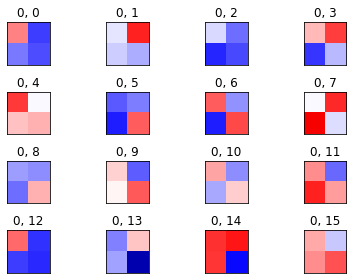

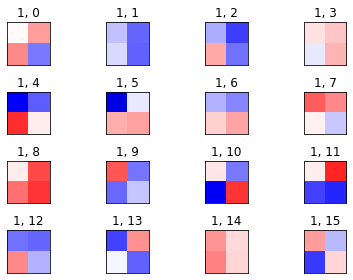

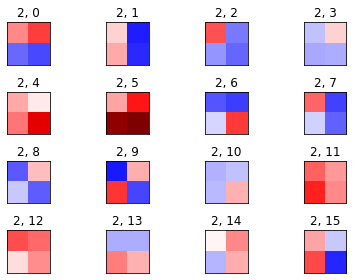

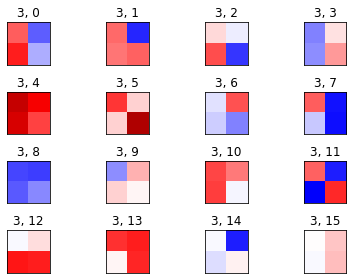

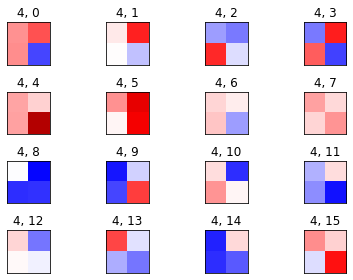

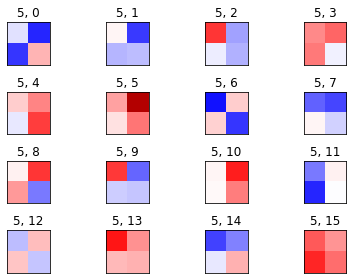

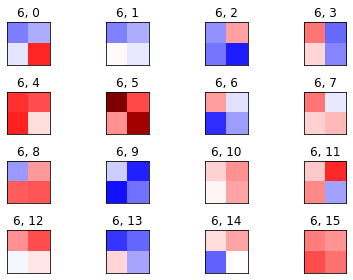

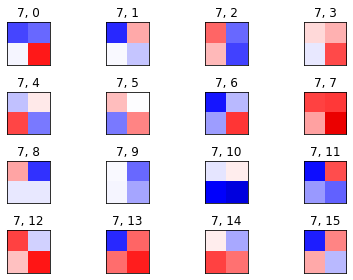

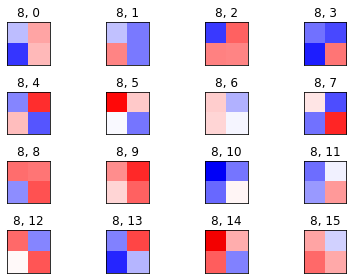

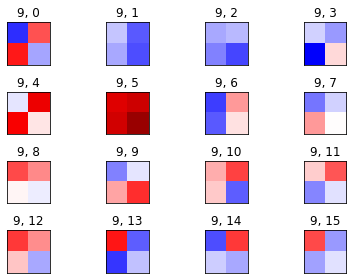

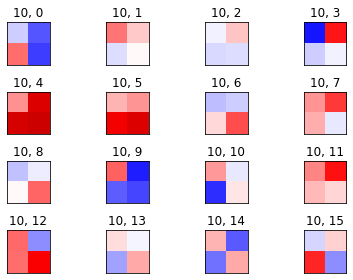

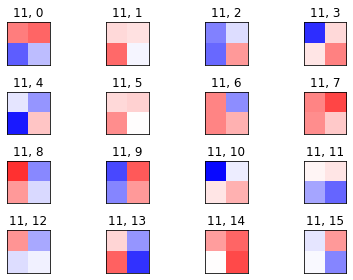

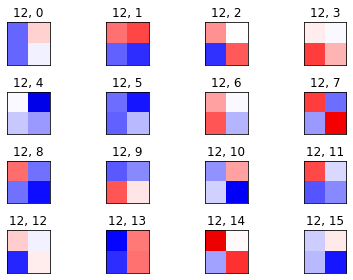

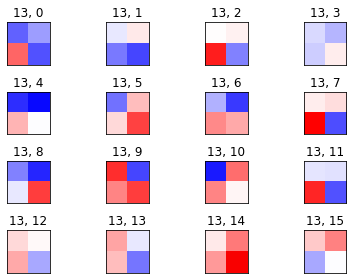

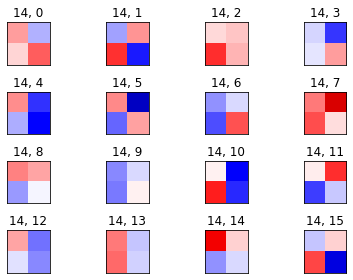

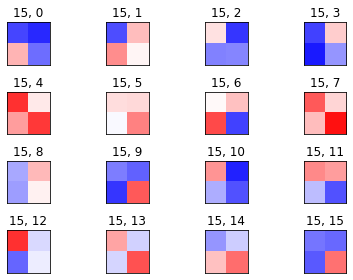

In [43]:
num_filters = conv_x2_kernel_np.shape[2]
channels = range(conv_x2_kernel_np.shape[2])
w_max = np.max(conv_x2_kernel_np)
w_min = np.min(conv_x2_kernel_np)

for channel in channels:
    # create figure and axes
    fig, axes = plt.subplots(4, 4)
    for idx, ax in enumerate(axes.flat):
        img = conv_x2_kernel_np[:, :, channel, idx]
        _ = ax.imshow(img, vmin=w_min, vmax=w_max, 
                      interpolation='nearest', cmap='seismic')
        _ = ax.set_xticks([])
        _ = ax.set_yticks([])
        _ = ax.set_title(f'{channel}, {idx}')
    fig.tight_layout()

In [ ]:

# iterate channels
for channel in channels:
    # iterate filters inside every channel
    for l, ax in enumerate(axes.flat):
        # get a single filter
        img = weights[:, :, channel, l]
        # put it on the grid
        ax.imshow(img, vmin=w_min, vmax=w_max, interpolation='nearest', cmap='seismic')
        # remove any labels from the axes
        ax.set_xticks([])
        ax.set_yticks([])
    # save figure
    plt.savefig(os.path.join(plot_dir, '{}-{}.png'.format(name, channel)), bbox_inches='tight')

[]

[]

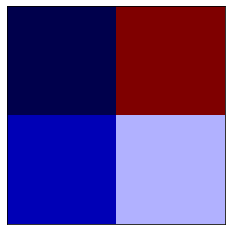

In [29]:
w0 = conv_x1_kernel_np[:, :, 0]
w_min = np.min(w0)
w_max = np.max(w0)

fig, ax = plt.subplots()
_ = ax.imshow(conv_x1_kernel_np[:, :, 0], vmin=w_min, vmax=w_max, 
          interpolation='nearest', cmap='seismic')
# remove any labels from the axes
_ = ax.set_xticks([])
_ = ax.set_yticks([])

In [ ]:
model.dynamics.position_fn.dense

In [39]:
import pickle

with open(model.files['parameters_pkl_file'], 'wb') as f:
    pickle.dump(model.params, f)

In [ ]:
model.sess.graph.collections

In [ ]:
model.sess.graph.get_collection

In [ ]:
model.dynamics.position_fn.summary()

In [ ]:
# Iterate over samples history and calculate observables for each sample.
# `lattice.calc_plaq_observables(samples)` calculates observables for each of
# the samples in the mini-batch.
actions_history = []
avg_plaquettes_history = []
top_charges_history = []
for idx, samples in enumerate(samples_history):
    t0 = time.time()
    observables = np.array(model.lattice.calc_plaq_observables(samples))
    actions, plaqs, charges = observables
    
    actions_history.append(actions)
    avg_plaquettes_history.append(plaqs)
    top_charges_history.append(charges)
    
    print(f'step: {idx}  '
          f'time / step: {time.time() - t0:^6.4g}  '
          f'avg action: {np.mean(actions):^6.4g}  '
          f'avg plaquette: {np.mean(plaqs):^6.4g} '
          f'top charge: {np.mean(charges):^6.4g}')

In [ ]:
_ = helpers.plot_run_data(model.data, 
                          model.params, 
                          model.steps_arr, 
                          model.figs_dir, 
                          skip_steps=1)

In [ ]:
#tf.reset_default_graph()
#model = GaugeModel(params=params,
#                   config=None,
#                   sess=None,
#                   conv_net=False,
#                   hmc=False,
#                   log_dir='../../gauge_logs_graph/run_25',
#                   restore=True)

In [ ]:
samples = np.random.randn(*model.samples.shape)
samples_history = []

In [ ]:
for i in range(500):
    t0 = time.time()
    samples = model.sess.run(model.x_out, feed_dict={model.x: samples})
    samples_history.append(samples)
    print(f'step: {i:^6.4g} time/step: {time.time() - t0:^6.4g}')

In [ ]:
samples_history_conv = np.array(samples_history_conv)
print(samples_history_conv.shape)

In [ ]:
import pickle
samples_history_file = os.path.join(model.info_dir, 'samples_history.pkl')
with open(samples_history_file, 'wb') as f:
    pickle.dump(samples_history_conv, f)